In [1]:
import gc
import glob
import os
import random
import re
import tarfile

import flash
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import sklearn
import torch
import torchvision
# import all the functions from dcgan.ipynb
from ipynb.fs.defs.dcgan import Generator, fix_seed
from PIL import Image
from sklearn.datasets import fetch_openml
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, tp_name):


In [2]:
SEED = 2913
fix_seed(SEED)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# GANによる画像生成(DCGAN)

本ノートブックでは、`5-dcgan.ipynb`で明らかになった問題の改良を行なっていくことにする。

## データオーギュメンテーション

`5-dcgan.ipynb`にはDiscriminatorに過学習の傾向が見られたので、データオーギュメンテーションを行うことでこれの改善を試みる。ただし、MNISTのデータは、中央にうまくデータを配置させてくれているので、Cropなどはしないことにする。

以下でデータオーギュメンテーションをすることにした。

- 画像データ拡大時の補間方法
- RandomRotation
- 各ピクセルへのランダムノイズ

In [4]:
class MnistTransform:
    interpolation_modes = [
        torchvision.transforms.InterpolationMode.NEAREST,
        torchvision.transforms.InterpolationMode.NEAREST_EXACT,
        torchvision.transforms.InterpolationMode.BILINEAR,
        torchvision.transforms.InterpolationMode.BICUBIC,
    ]

    def __init__(self):
        self.transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomChoice(
                    [
                        torchvision.transforms.Resize((64, 64), interpolation=mode)
                        for mode in self.interpolation_modes
                    ]
                ),
                torchvision.transforms.RandomRotation(10),
                torchvision.transforms.ToTensor(),
                # add random noize, std=0.1
                torchvision.transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            ]
        )

    def __call__(self, x):
        return self.transform(x)

In [5]:
transform = MnistTransform()
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, target_transform=None, download=True
)
val_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    target_transform=None,
    download=True,
)
dataset = train_dataset + val_dataset

Text(0.5, 0.98, 'MNIST Dataset')

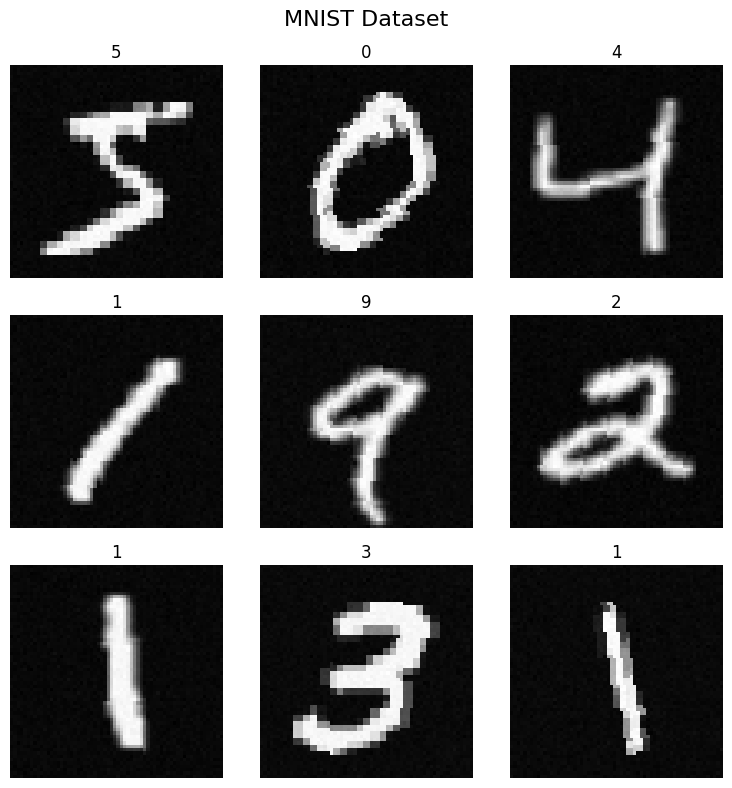

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_dataset[i][0].squeeze(), cmap="gray")
    ax.set_title(train_dataset[i][1])
    ax.set_axis_off()
fig.set_tight_layout(True)
fig.suptitle("MNIST Dataset", fontsize=16)

In [7]:
batch_size = 2048
train_data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
    persistent_workers=True,
)

In [8]:
# show generated
z_for_show = None


def show_generated(generator, z_dim, device, title="Generated Images", save_path=None):
    global z_for_show
    if z_for_show is None:
        z_for_show = torch.randn(9, z_dim, 1, 1, device=device)
    outputs = generator(z_for_show).detach()
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(outputs[i].squeeze().cpu().numpy(), cmap="gray")
        ax.set_axis_off()
    fig.set_tight_layout(True)
    fig.suptitle(title, fontsize=16)
    plt.show()
    if save_path is not None:
        fig.savefig(save_path)

## Wasserstein lossを使う

Wasserstein lossを使用すると、モード崩壊を避けることができるとのこと。`dcgan.ipynb`の実装では、Discriminatorは最後の層でsigmoid関数を使用していたので、出力の値は$[0,1]$の範囲に収まっていた。

Wasserstein lossを使用する場合、Discriminatorの出力は$[-\infty,\infty]$となる。すると、DCGANで可能であった、0.5以上であれば本物の画像で、0.5未満であればfake画像であるといった判定はできないことになる。そのため、Discriminatorは判別能力を持たないことになり、"Critic"とも呼ばれる。ここでは、Discriminatorに名前を統一して説明する。

Discriminatorの目標は、D(x)の出力が、D(G(z))の出力よりも大きくなるようにすることである。したがって、Discriminatorの損失関数は$-(D(x)-D(G(x)))$となり、これを最小化する。

一方で、Generatorは、$D(G(z))$が大きくなればいいので、$-D(G(z))$を最小化する。

理論的には、Discriminatorの重みが大きくなりすぎないようにする必要がある。書籍で使用されているSelf Attention GANでは、Spectral Normalizationで重みを調整している。ここでは重みの調整は行わないでやってみる。

## Unrolled GAN

Unrolled GANでは、各ミニバッチで、n_criticに1回しかGeneratorの学習を行わない。これにより、DiscriminatorはGeneratorよりも相対的に賢くなるため、モード崩壊が起きにくくなるらしい。

## その他

- 学習がうまくいかず、学習率とbetasを変更。
- AMPを使用すると、学習時間が半分程度に短縮されるので、採用する。
- 学習の安定化を目指してDiscriminatorにBatchNorm2dを入れる。
- バッチサイズは2048から小さくする。

In [9]:
class Discriminator(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            # sigmoid was removed
        )

    def forward(self, x):
        # convert (batch_size, 1, 1, 1) to (batch_size)
        return super().forward(x).view(-1)

In [10]:
_batch_size = 4
_inputs = torch.randn(_batch_size, 1, 64, 64)
_outputs = Discriminator()(_inputs)
assert _outputs.shape == (_batch_size,)
del _batch_size, _inputs, _outputs

In [11]:
def init_weight(m: torch.nn.Module):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [12]:
gc.collect()
torch.cuda.empty_cache()

In [13]:
generator = Generator(in_channels=20)
discriminator = Discriminator()
generator.apply(init_weight)
discriminator.apply(init_weight)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 1000

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

lr_d, betas_d = 0.001, (0.5, 0.999)
lr_g, betas_g = 0.001, (0.5, 0.999)
optimizer_d = flash.core.optimizers.LAMB(
    discriminator.parameters(), lr=lr_d, betas=betas_d
)
optimizer_g = flash.core.optimizers.LAMB(generator.parameters(), lr=lr_g, betas=betas_g)

z_dim = 20
n_critics = 3

torch.backends.cudnn.benchmark = True

save_dir = "./results"
os.makedirs(save_dir, exist_ok=True)

Start training


Epoch: 1/1000, d_loss: -0.0568, g_loss: -0.0110, time: 19.1009 sec


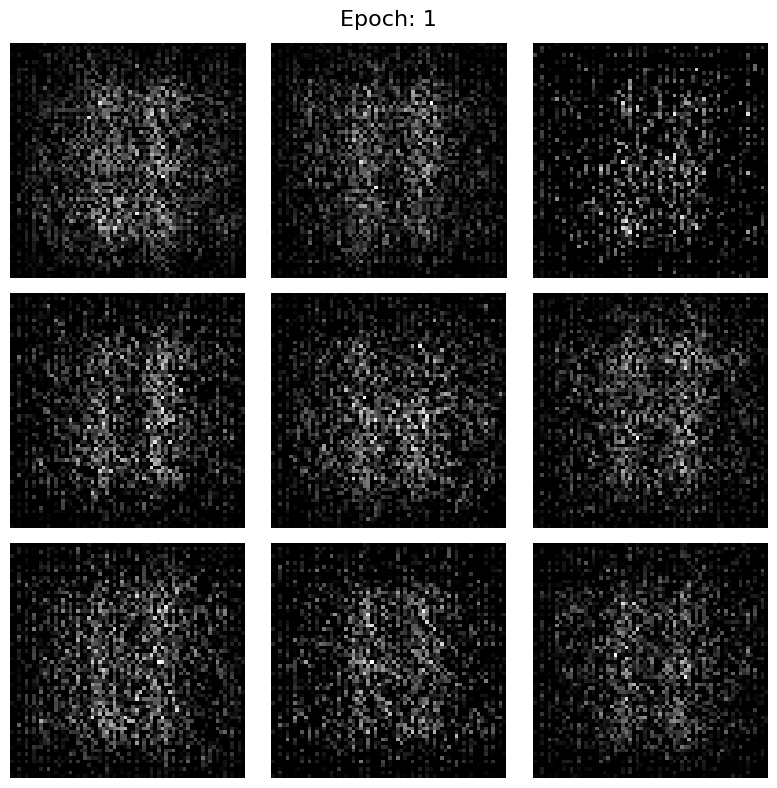

Epoch: 2/1000, d_loss: -0.1180, g_loss: -0.0001, time: 14.8788 sec


Epoch: 3/1000, d_loss: -0.1853, g_loss: 0.0460, time: 14.6996 sec


Epoch: 4/1000, d_loss: -0.1826, g_loss: 0.0646, time: 14.6658 sec


Epoch: 5/1000, d_loss: -0.1835, g_loss: 0.0808, time: 14.8095 sec


Epoch: 6/1000, d_loss: -0.1794, g_loss: 0.0710, time: 14.7514 sec


Epoch: 7/1000, d_loss: -0.1532, g_loss: 0.0591, time: 14.8425 sec


Epoch: 8/1000, d_loss: -0.2015, g_loss: 0.0870, time: 14.7453 sec


Epoch: 9/1000, d_loss: -0.2393, g_loss: 0.1086, time: 14.7717 sec


Epoch: 10/1000, d_loss: -0.2288, g_loss: 0.1078, time: 14.7769 sec


Epoch: 11/1000, d_loss: -0.2760, g_loss: 0.1464, time: 14.7782 sec


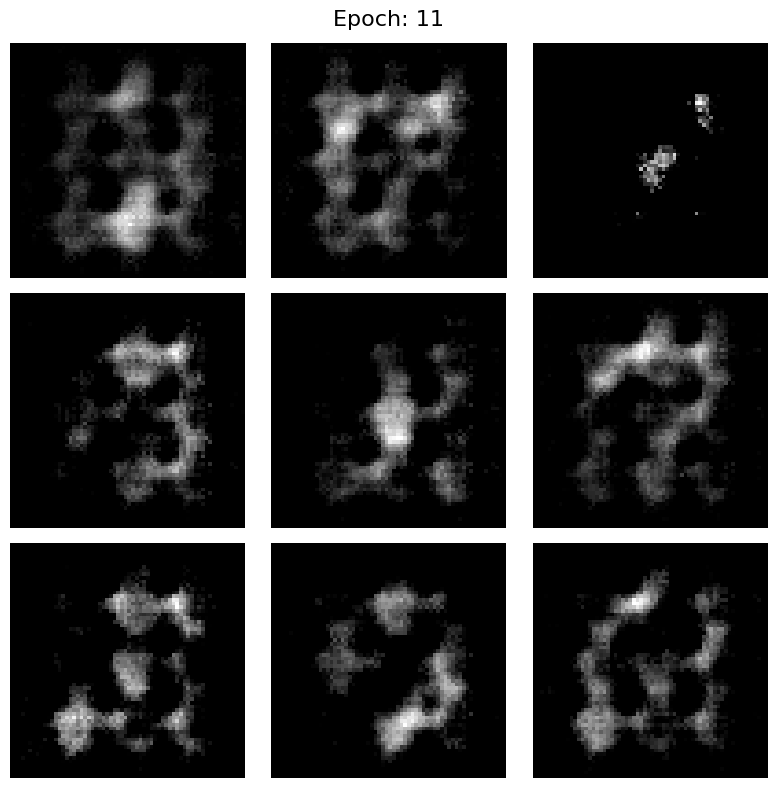

Epoch: 12/1000, d_loss: -0.3219, g_loss: 0.1720, time: 14.9050 sec


Epoch: 13/1000, d_loss: -0.3822, g_loss: 0.2009, time: 14.6894 sec


Epoch: 14/1000, d_loss: -0.3450, g_loss: 0.1852, time: 14.7687 sec


Epoch: 15/1000, d_loss: -0.4312, g_loss: 0.2301, time: 14.7397 sec


Epoch: 16/1000, d_loss: -0.4107, g_loss: 0.2213, time: 14.7638 sec


Epoch: 17/1000, d_loss: -0.4358, g_loss: 0.2403, time: 14.7818 sec


Epoch: 18/1000, d_loss: -0.4463, g_loss: 0.2352, time: 14.7654 sec


Epoch: 19/1000, d_loss: -0.4483, g_loss: 0.2385, time: 14.7069 sec


Epoch: 20/1000, d_loss: -0.4147, g_loss: 0.2236, time: 14.6991 sec


Epoch: 21/1000, d_loss: -0.3795, g_loss: 0.2048, time: 14.7160 sec


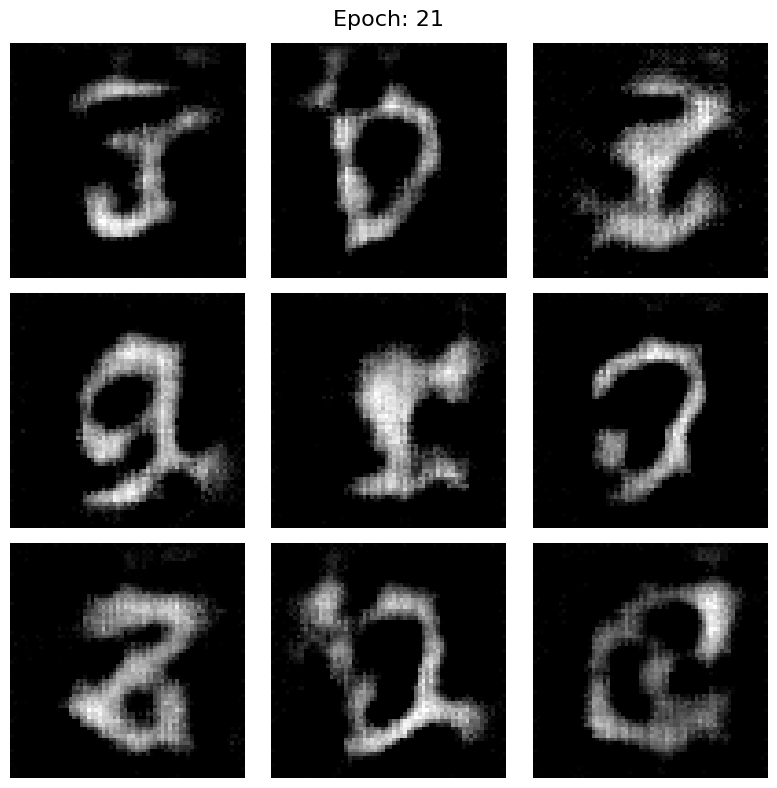

Epoch: 22/1000, d_loss: -0.3560, g_loss: 0.1955, time: 14.8096 sec


Epoch: 23/1000, d_loss: -0.3681, g_loss: 0.2114, time: 14.7723 sec


Epoch: 24/1000, d_loss: -0.3642, g_loss: 0.2049, time: 14.6883 sec


Epoch: 25/1000, d_loss: -0.3610, g_loss: 0.2057, time: 14.7313 sec


Epoch: 26/1000, d_loss: -0.3613, g_loss: 0.2053, time: 14.8303 sec


Epoch: 27/1000, d_loss: -0.3520, g_loss: 0.1982, time: 14.8084 sec


Epoch: 28/1000, d_loss: -0.3424, g_loss: 0.2010, time: 14.7788 sec


Epoch: 29/1000, d_loss: -0.3288, g_loss: 0.1806, time: 14.6608 sec


Epoch: 30/1000, d_loss: -0.3166, g_loss: 0.1808, time: 14.7873 sec


Epoch: 31/1000, d_loss: -0.3001, g_loss: 0.1621, time: 14.7510 sec


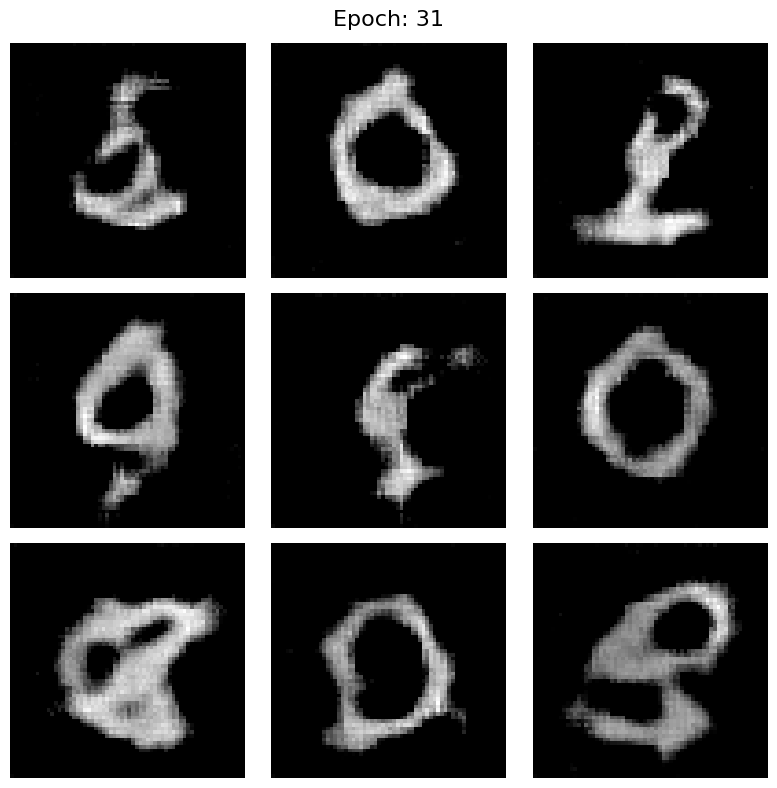

Epoch: 32/1000, d_loss: -0.2930, g_loss: 0.1613, time: 14.8967 sec


Epoch: 33/1000, d_loss: -0.2931, g_loss: 0.1507, time: 14.7489 sec


Epoch: 34/1000, d_loss: -0.2852, g_loss: 0.1524, time: 14.7943 sec


Epoch: 35/1000, d_loss: -0.2776, g_loss: 0.1375, time: 14.7457 sec


Epoch: 36/1000, d_loss: -0.2654, g_loss: 0.1384, time: 14.6946 sec


Epoch: 37/1000, d_loss: -0.2600, g_loss: 0.1273, time: 14.7794 sec


Epoch: 38/1000, d_loss: -0.2583, g_loss: 0.1252, time: 14.7320 sec


Epoch: 39/1000, d_loss: -0.2598, g_loss: 0.1338, time: 14.7042 sec


Epoch: 40/1000, d_loss: -0.2684, g_loss: 0.1271, time: 14.7740 sec


Epoch: 41/1000, d_loss: -0.2811, g_loss: 0.1466, time: 14.7161 sec


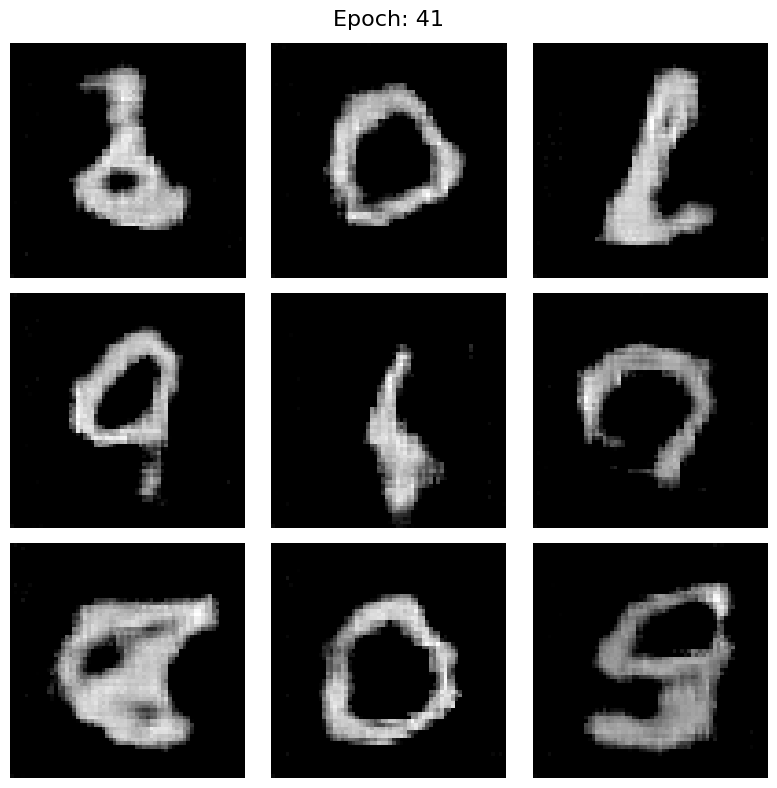

Epoch: 42/1000, d_loss: -0.2916, g_loss: 0.1440, time: 14.7425 sec


Epoch: 43/1000, d_loss: -0.2953, g_loss: 0.1519, time: 14.7580 sec


Epoch: 44/1000, d_loss: -0.2997, g_loss: 0.1459, time: 14.6923 sec


Epoch: 45/1000, d_loss: -0.3041, g_loss: 0.1571, time: 14.7646 sec


Epoch: 46/1000, d_loss: -0.3081, g_loss: 0.1519, time: 14.7338 sec


Epoch: 47/1000, d_loss: -0.3193, g_loss: 0.1677, time: 14.8424 sec


Epoch: 48/1000, d_loss: -0.3278, g_loss: 0.1622, time: 14.7956 sec


Epoch: 49/1000, d_loss: -0.3340, g_loss: 0.1761, time: 14.7549 sec


Epoch: 50/1000, d_loss: -0.3377, g_loss: 0.1661, time: 14.7496 sec


Epoch: 51/1000, d_loss: -0.3371, g_loss: 0.1752, time: 14.6975 sec


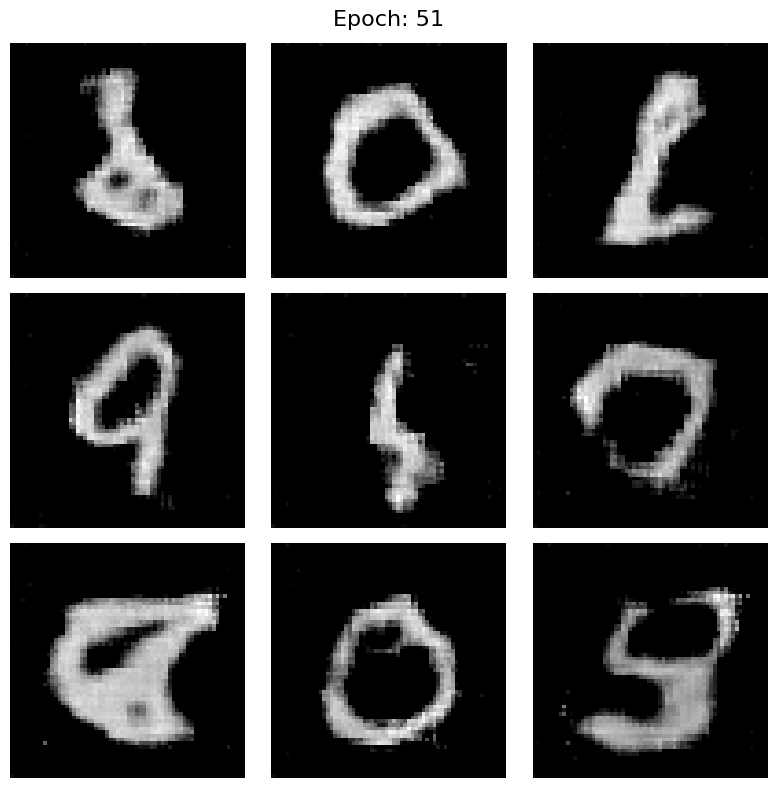

Epoch: 52/1000, d_loss: -0.3408, g_loss: 0.1769, time: 14.9809 sec


Epoch: 53/1000, d_loss: -0.3382, g_loss: 0.1642, time: 14.8872 sec


Epoch: 54/1000, d_loss: -0.3364, g_loss: 0.1726, time: 14.7910 sec


Epoch: 55/1000, d_loss: -0.3375, g_loss: 0.1669, time: 14.7746 sec


Epoch: 56/1000, d_loss: -0.3396, g_loss: 0.1766, time: 14.7707 sec


Epoch: 57/1000, d_loss: -0.3430, g_loss: 0.1677, time: 14.7383 sec


Epoch: 58/1000, d_loss: -0.3452, g_loss: 0.1785, time: 14.7997 sec


Epoch: 59/1000, d_loss: -0.3522, g_loss: 0.1739, time: 14.6865 sec


Epoch: 60/1000, d_loss: -0.3546, g_loss: 0.1833, time: 14.6966 sec


Epoch: 61/1000, d_loss: -0.3571, g_loss: 0.1732, time: 14.8092 sec


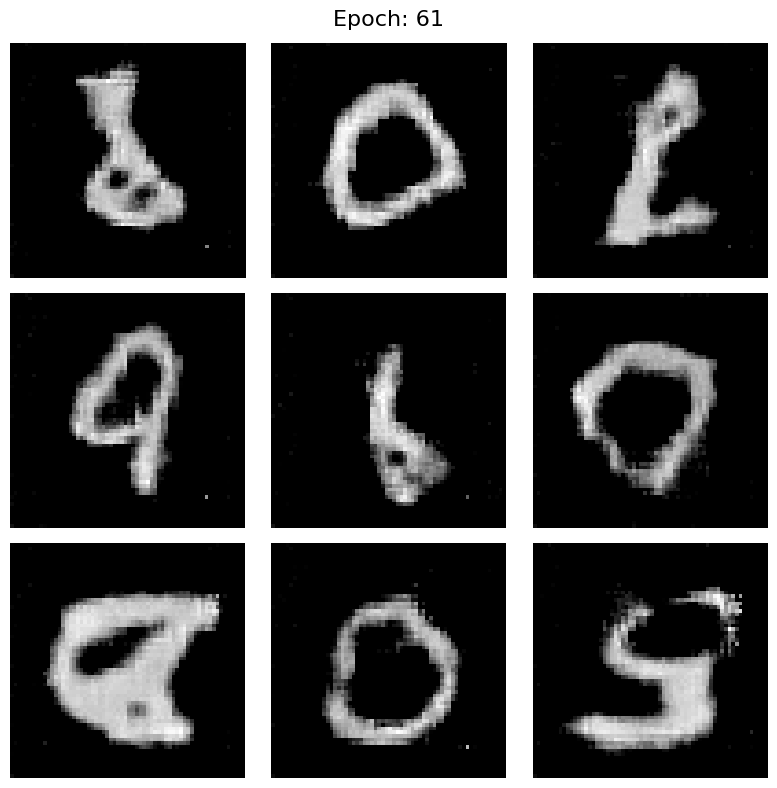

Epoch: 62/1000, d_loss: -0.3604, g_loss: 0.1898, time: 14.8801 sec


Epoch: 63/1000, d_loss: -0.3648, g_loss: 0.1820, time: 14.7308 sec


Epoch: 64/1000, d_loss: -0.3655, g_loss: 0.1920, time: 14.7565 sec


Epoch: 65/1000, d_loss: -0.3683, g_loss: 0.1836, time: 14.8134 sec


Epoch: 66/1000, d_loss: -0.3721, g_loss: 0.1875, time: 14.7147 sec


Epoch: 67/1000, d_loss: -0.3765, g_loss: 0.1875, time: 14.8183 sec


Epoch: 68/1000, d_loss: -0.3828, g_loss: 0.1980, time: 14.7225 sec


Epoch: 69/1000, d_loss: -0.3836, g_loss: 0.1929, time: 14.7305 sec


Epoch: 70/1000, d_loss: -0.3791, g_loss: 0.1947, time: 14.7617 sec


Epoch: 71/1000, d_loss: -0.3762, g_loss: 0.1813, time: 14.7335 sec


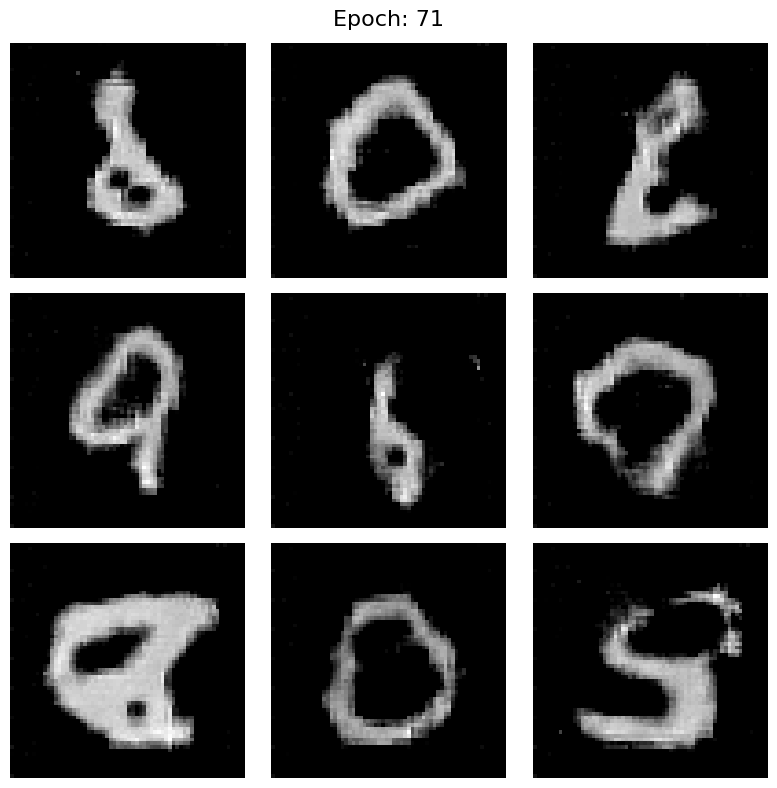

Epoch: 72/1000, d_loss: -0.3773, g_loss: 0.1902, time: 14.8657 sec


Epoch: 73/1000, d_loss: -0.3814, g_loss: 0.1842, time: 14.7514 sec


Epoch: 74/1000, d_loss: -0.3805, g_loss: 0.1936, time: 14.8310 sec


Epoch: 75/1000, d_loss: -0.3830, g_loss: 0.1836, time: 14.7139 sec


Epoch: 76/1000, d_loss: -0.3843, g_loss: 0.2024, time: 14.7598 sec


Epoch: 77/1000, d_loss: -0.3810, g_loss: 0.1902, time: 14.7328 sec


Epoch: 78/1000, d_loss: -0.3835, g_loss: 0.1995, time: 14.7773 sec


Epoch: 79/1000, d_loss: -0.3837, g_loss: 0.1931, time: 14.6609 sec


Epoch: 80/1000, d_loss: -0.3827, g_loss: 0.1996, time: 14.7061 sec


Epoch: 81/1000, d_loss: -0.3847, g_loss: 0.1922, time: 14.8291 sec


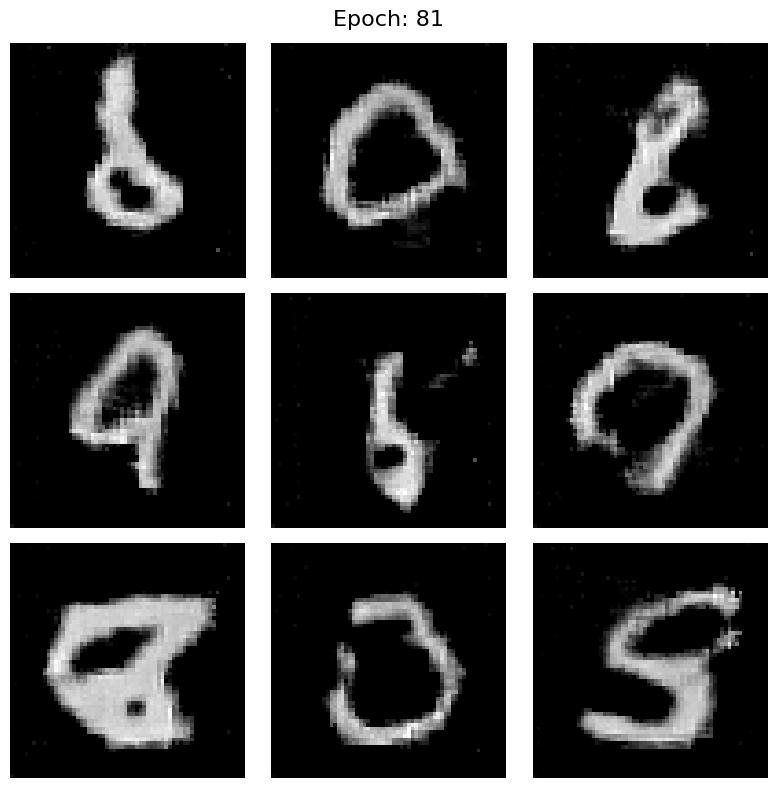

Epoch: 82/1000, d_loss: -0.3834, g_loss: 0.2014, time: 14.8304 sec


Epoch: 83/1000, d_loss: -0.3860, g_loss: 0.2036, time: 14.7391 sec


Epoch: 84/1000, d_loss: -0.3857, g_loss: 0.1954, time: 14.7339 sec


Epoch: 85/1000, d_loss: -0.3851, g_loss: 0.2056, time: 14.9113 sec


Epoch: 86/1000, d_loss: -0.3859, g_loss: 0.1980, time: 14.7915 sec


Epoch: 87/1000, d_loss: -0.3852, g_loss: 0.2034, time: 14.6820 sec


Epoch: 88/1000, d_loss: -0.3849, g_loss: 0.1943, time: 14.8014 sec


Epoch: 89/1000, d_loss: -0.3841, g_loss: 0.2023, time: 14.6644 sec


Epoch: 90/1000, d_loss: -0.3836, g_loss: 0.1924, time: 14.7151 sec


Epoch: 91/1000, d_loss: -0.3875, g_loss: 0.2071, time: 14.7336 sec


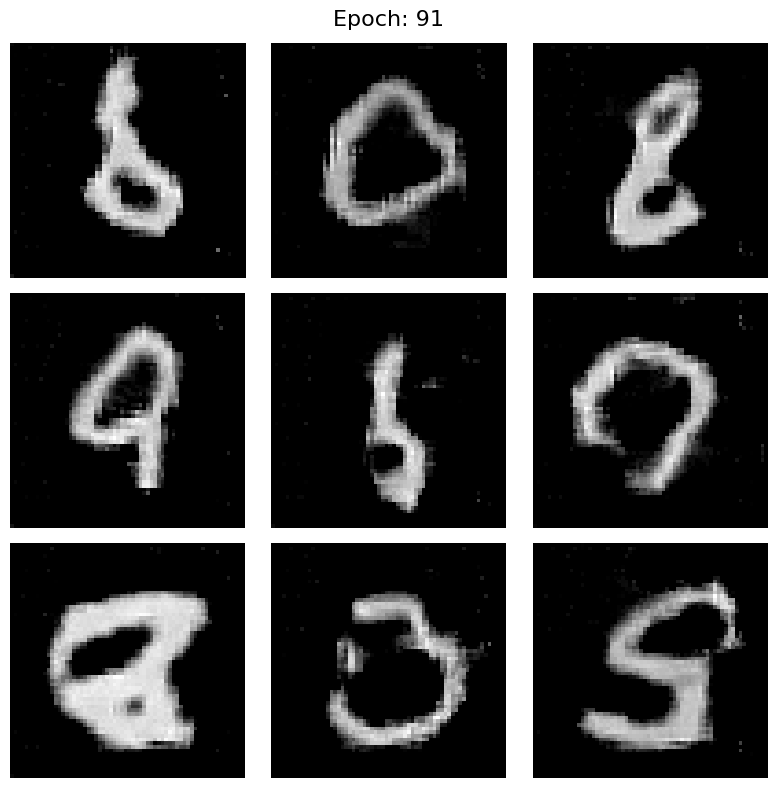

Epoch: 92/1000, d_loss: -0.3917, g_loss: 0.2021, time: 14.7875 sec


Epoch: 93/1000, d_loss: -0.3951, g_loss: 0.2139, time: 14.8563 sec


Epoch: 94/1000, d_loss: -0.4023, g_loss: 0.2085, time: 14.7407 sec


Epoch: 95/1000, d_loss: -0.4054, g_loss: 0.2190, time: 14.8835 sec


Epoch: 96/1000, d_loss: -0.4107, g_loss: 0.2130, time: 14.7863 sec


Epoch: 97/1000, d_loss: -0.4153, g_loss: 0.2162, time: 14.8164 sec


Epoch: 98/1000, d_loss: -0.4154, g_loss: 0.2238, time: 14.7748 sec


Epoch: 99/1000, d_loss: -0.4172, g_loss: 0.2149, time: 14.7088 sec


Epoch: 100/1000, d_loss: -0.4238, g_loss: 0.2281, time: 14.6795 sec


Epoch: 101/1000, d_loss: -0.4263, g_loss: 0.2194, time: 14.7112 sec


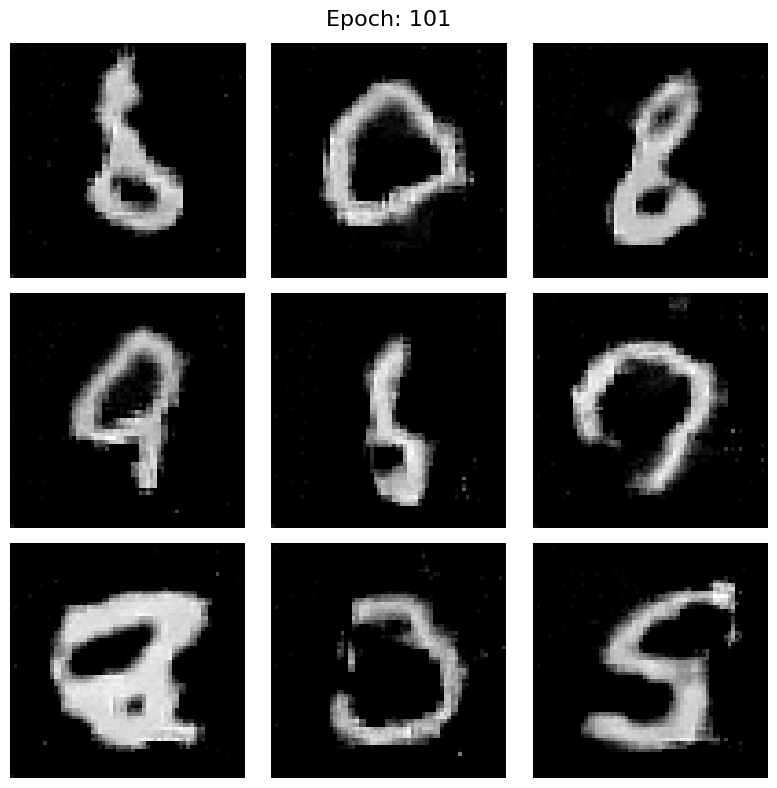

Epoch: 102/1000, d_loss: -0.4273, g_loss: 0.2268, time: 14.8578 sec


Epoch: 103/1000, d_loss: -0.4338, g_loss: 0.2232, time: 14.8015 sec


Epoch: 104/1000, d_loss: -0.4344, g_loss: 0.2318, time: 14.8014 sec


Epoch: 105/1000, d_loss: -0.4348, g_loss: 0.2255, time: 14.8090 sec


Epoch: 106/1000, d_loss: -0.4404, g_loss: 0.2369, time: 14.7293 sec


Epoch: 107/1000, d_loss: -0.4475, g_loss: 0.2311, time: 14.7107 sec


Epoch: 108/1000, d_loss: -0.4505, g_loss: 0.2418, time: 14.7199 sec


Epoch: 109/1000, d_loss: -0.4515, g_loss: 0.2322, time: 14.7216 sec


Epoch: 110/1000, d_loss: -0.4513, g_loss: 0.2323, time: 14.7638 sec


Epoch: 111/1000, d_loss: -0.4492, g_loss: 0.2387, time: 14.8111 sec


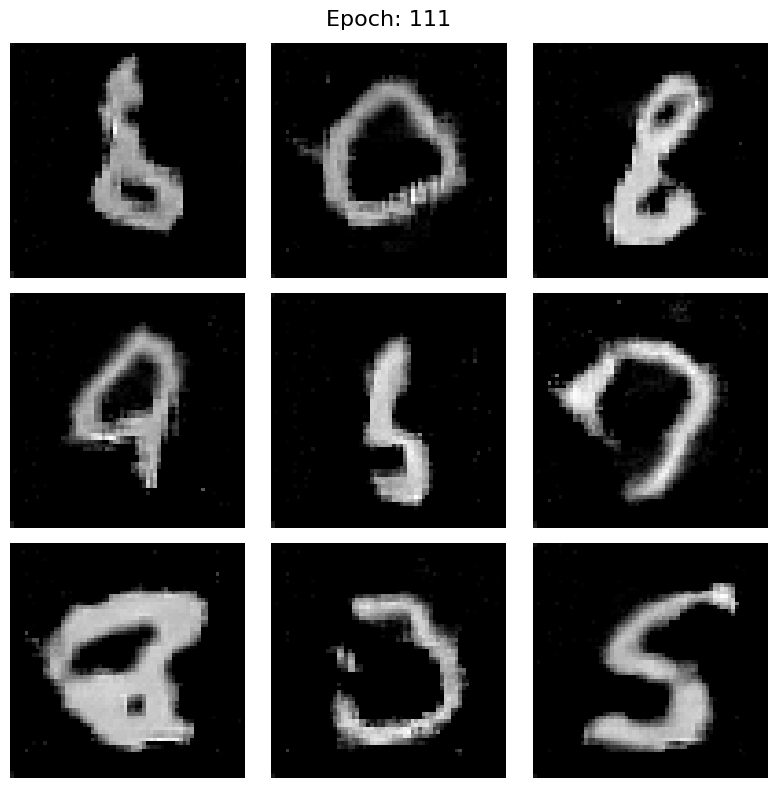

Epoch: 112/1000, d_loss: -0.4495, g_loss: 0.2330, time: 14.9202 sec


Epoch: 113/1000, d_loss: -0.4573, g_loss: 0.2435, time: 14.8394 sec


Epoch: 114/1000, d_loss: -0.4636, g_loss: 0.2408, time: 14.6767 sec


Epoch: 115/1000, d_loss: -0.4666, g_loss: 0.2471, time: 14.7713 sec


Epoch: 116/1000, d_loss: -0.4662, g_loss: 0.2401, time: 14.8014 sec


Epoch: 117/1000, d_loss: -0.4658, g_loss: 0.2473, time: 14.7039 sec


Epoch: 118/1000, d_loss: -0.4660, g_loss: 0.2388, time: 14.7419 sec


Epoch: 119/1000, d_loss: -0.4653, g_loss: 0.2470, time: 14.7356 sec


Epoch: 120/1000, d_loss: -0.4656, g_loss: 0.2393, time: 14.6730 sec


Epoch: 121/1000, d_loss: -0.4631, g_loss: 0.2473, time: 14.7134 sec


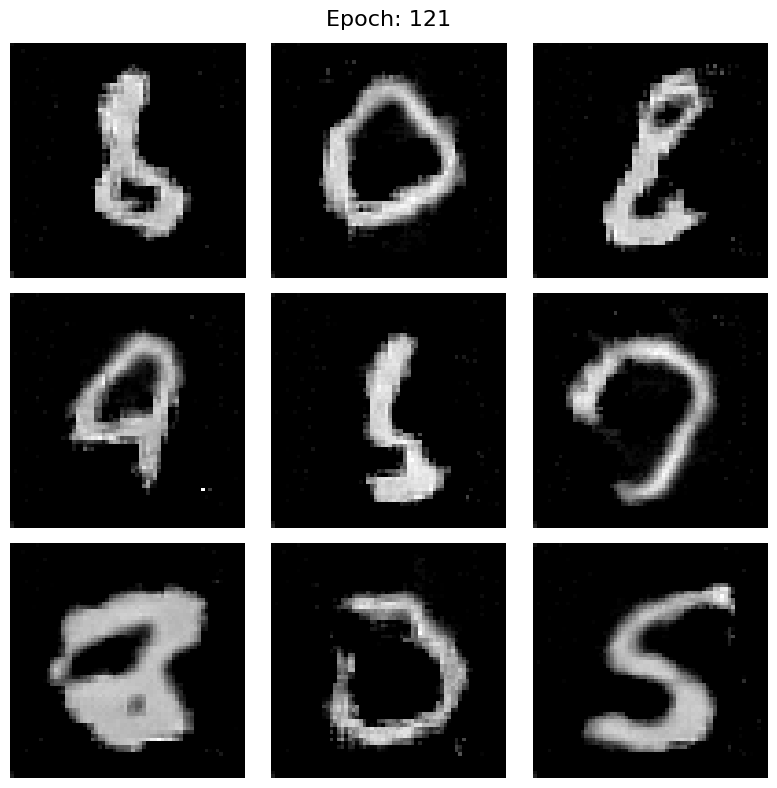

Epoch: 122/1000, d_loss: -0.4638, g_loss: 0.2387, time: 14.7262 sec


Epoch: 123/1000, d_loss: -0.4659, g_loss: 0.2495, time: 14.6979 sec


Epoch: 124/1000, d_loss: -0.4563, g_loss: 0.2314, time: 14.7540 sec


Epoch: 125/1000, d_loss: -0.4563, g_loss: 0.2411, time: 14.7440 sec


Epoch: 126/1000, d_loss: -0.4554, g_loss: 0.2393, time: 14.6573 sec


Epoch: 127/1000, d_loss: -0.4586, g_loss: 0.2329, time: 14.7526 sec


Epoch: 128/1000, d_loss: -0.4626, g_loss: 0.2437, time: 14.7546 sec


Epoch: 129/1000, d_loss: -0.4576, g_loss: 0.2303, time: 14.7156 sec


Epoch: 130/1000, d_loss: -0.4613, g_loss: 0.2411, time: 14.7747 sec


Epoch: 131/1000, d_loss: -0.4616, g_loss: 0.2314, time: 14.7934 sec


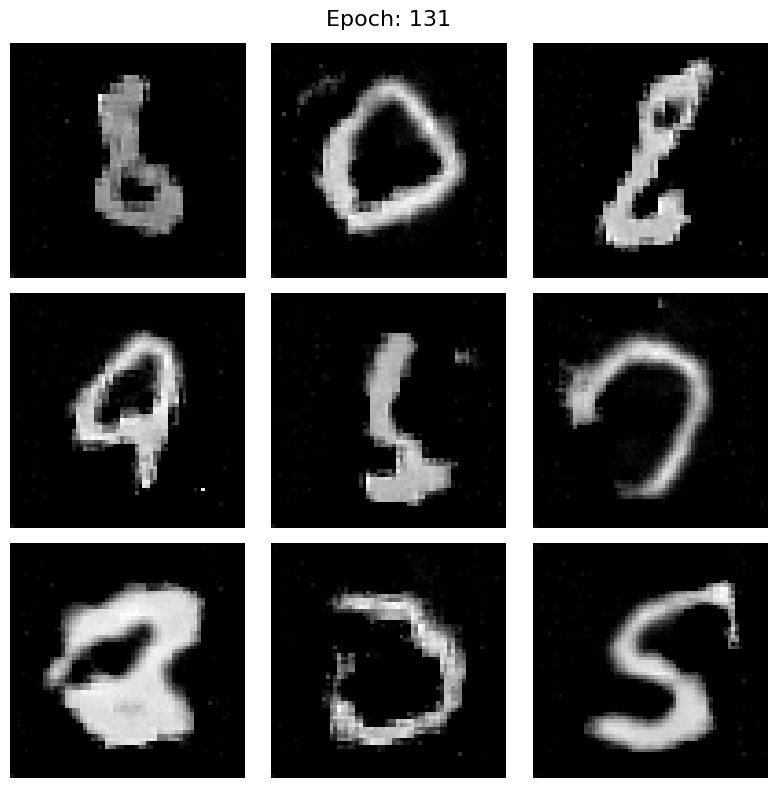

Epoch: 132/1000, d_loss: -0.4659, g_loss: 0.2414, time: 14.8105 sec


Epoch: 133/1000, d_loss: -0.4686, g_loss: 0.2355, time: 14.7454 sec


Epoch: 134/1000, d_loss: -0.4666, g_loss: 0.2416, time: 14.7077 sec


Epoch: 135/1000, d_loss: -0.4656, g_loss: 0.2335, time: 14.7085 sec


Epoch: 136/1000, d_loss: -0.4662, g_loss: 0.2416, time: 14.7007 sec


Epoch: 137/1000, d_loss: -0.4673, g_loss: 0.2367, time: 14.6275 sec


Epoch: 138/1000, d_loss: -0.4686, g_loss: 0.2419, time: 14.6540 sec


Epoch: 139/1000, d_loss: -0.4721, g_loss: 0.2352, time: 14.7390 sec


Epoch: 140/1000, d_loss: -0.4743, g_loss: 0.2370, time: 14.7481 sec


Epoch: 141/1000, d_loss: -0.4779, g_loss: 0.2480, time: 14.6962 sec


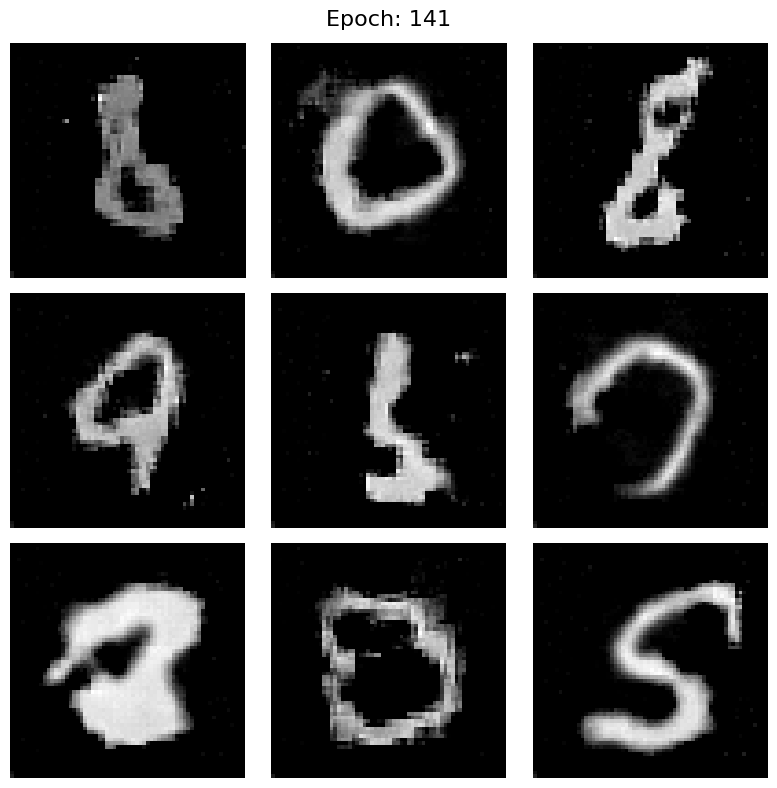

Epoch: 142/1000, d_loss: -0.4740, g_loss: 0.2359, time: 14.7550 sec


Epoch: 143/1000, d_loss: -0.4697, g_loss: 0.2411, time: 14.7375 sec


Epoch: 144/1000, d_loss: -0.4648, g_loss: 0.2315, time: 14.7248 sec


Epoch: 145/1000, d_loss: -0.4670, g_loss: 0.2398, time: 14.7899 sec


Epoch: 146/1000, d_loss: -0.4736, g_loss: 0.2345, time: 14.7342 sec


Epoch: 147/1000, d_loss: -0.4820, g_loss: 0.2483, time: 14.6726 sec


Epoch: 148/1000, d_loss: -0.4840, g_loss: 0.2417, time: 14.7596 sec


Epoch: 149/1000, d_loss: -0.4825, g_loss: 0.2497, time: 14.7811 sec


Epoch: 150/1000, d_loss: -0.4841, g_loss: 0.2397, time: 14.7425 sec


Epoch: 151/1000, d_loss: -0.4850, g_loss: 0.2511, time: 14.6911 sec


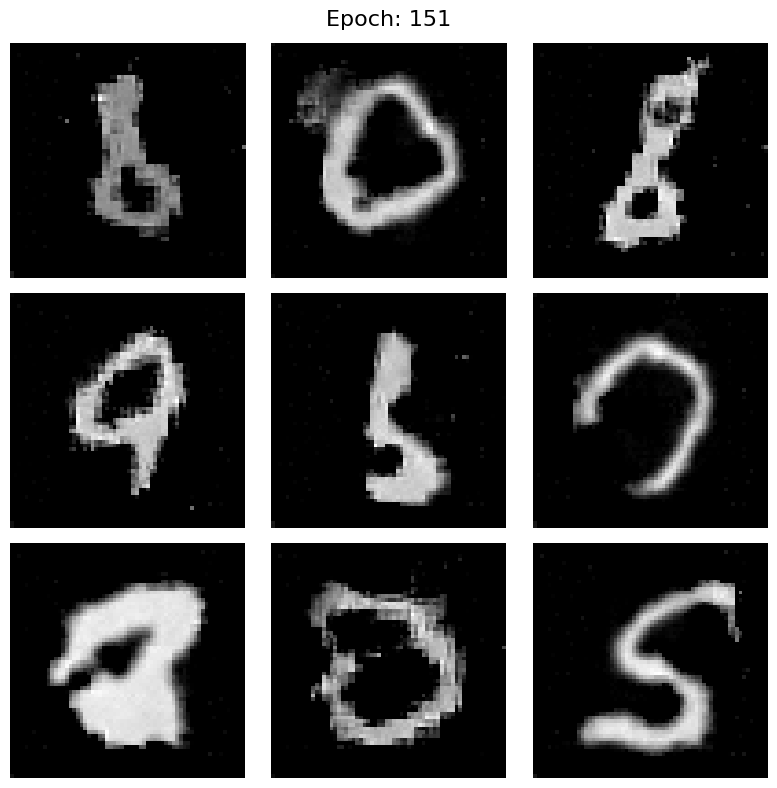

Epoch: 152/1000, d_loss: -0.4857, g_loss: 0.2417, time: 14.7515 sec


Epoch: 153/1000, d_loss: -0.4883, g_loss: 0.2431, time: 14.7996 sec


Epoch: 154/1000, d_loss: -0.4884, g_loss: 0.2520, time: 14.7576 sec


Epoch: 155/1000, d_loss: -0.4885, g_loss: 0.2442, time: 14.6987 sec


Epoch: 156/1000, d_loss: -0.4866, g_loss: 0.2517, time: 14.7083 sec


Epoch: 157/1000, d_loss: -0.4856, g_loss: 0.2440, time: 14.6729 sec


Epoch: 158/1000, d_loss: -0.4894, g_loss: 0.2540, time: 14.7767 sec


Epoch: 159/1000, d_loss: -0.4910, g_loss: 0.2462, time: 14.7766 sec


Epoch: 160/1000, d_loss: -0.4888, g_loss: 0.2527, time: 14.7505 sec


Epoch: 161/1000, d_loss: -0.4848, g_loss: 0.2423, time: 14.7629 sec


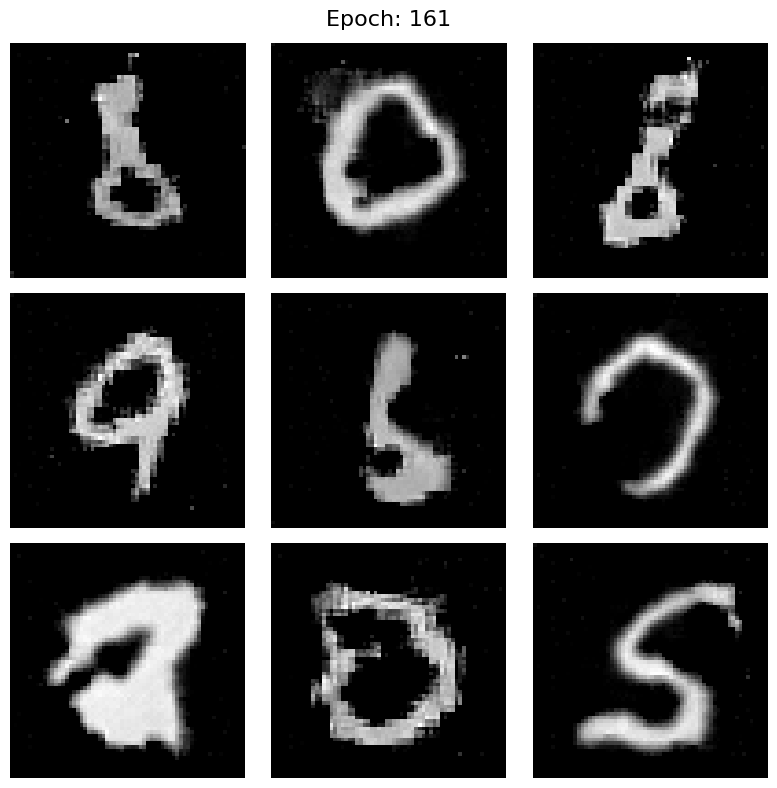

Epoch: 162/1000, d_loss: -0.4887, g_loss: 0.2535, time: 14.8402 sec


Epoch: 163/1000, d_loss: -0.4930, g_loss: 0.2464, time: 14.7421 sec


Epoch: 164/1000, d_loss: -0.4971, g_loss: 0.2556, time: 14.7510 sec


Epoch: 165/1000, d_loss: -0.5010, g_loss: 0.2507, time: 14.6985 sec


Epoch: 166/1000, d_loss: -0.5049, g_loss: 0.2604, time: 14.7158 sec


Epoch: 167/1000, d_loss: -0.5060, g_loss: 0.2629, time: 14.6917 sec


Epoch: 168/1000, d_loss: -0.5075, g_loss: 0.2537, time: 14.7395 sec


Epoch: 169/1000, d_loss: -0.5046, g_loss: 0.2603, time: 14.8180 sec


Epoch: 170/1000, d_loss: -0.5035, g_loss: 0.2499, time: 14.7534 sec


Epoch: 171/1000, d_loss: -0.4997, g_loss: 0.2537, time: 14.7122 sec


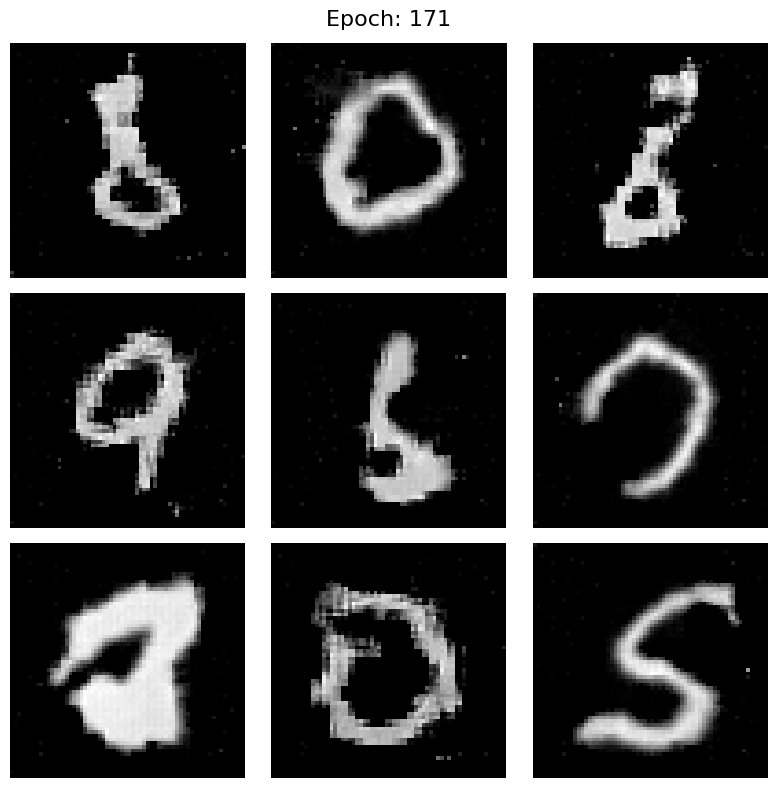

Epoch: 172/1000, d_loss: -0.5048, g_loss: 0.2512, time: 14.7611 sec


Epoch: 173/1000, d_loss: -0.5056, g_loss: 0.2608, time: 14.7701 sec


Epoch: 174/1000, d_loss: -0.5103, g_loss: 0.2577, time: 14.6816 sec


Epoch: 175/1000, d_loss: -0.5099, g_loss: 0.2652, time: 14.6434 sec


Epoch: 176/1000, d_loss: -0.5095, g_loss: 0.2539, time: 14.6982 sec


Epoch: 177/1000, d_loss: -0.5112, g_loss: 0.2638, time: 14.7230 sec


Epoch: 178/1000, d_loss: -0.5102, g_loss: 0.2531, time: 14.6961 sec


Epoch: 179/1000, d_loss: -0.5129, g_loss: 0.2645, time: 14.7011 sec


Epoch: 180/1000, d_loss: -0.5043, g_loss: 0.2518, time: 14.8283 sec


Epoch: 181/1000, d_loss: -0.4977, g_loss: 0.2571, time: 14.7976 sec


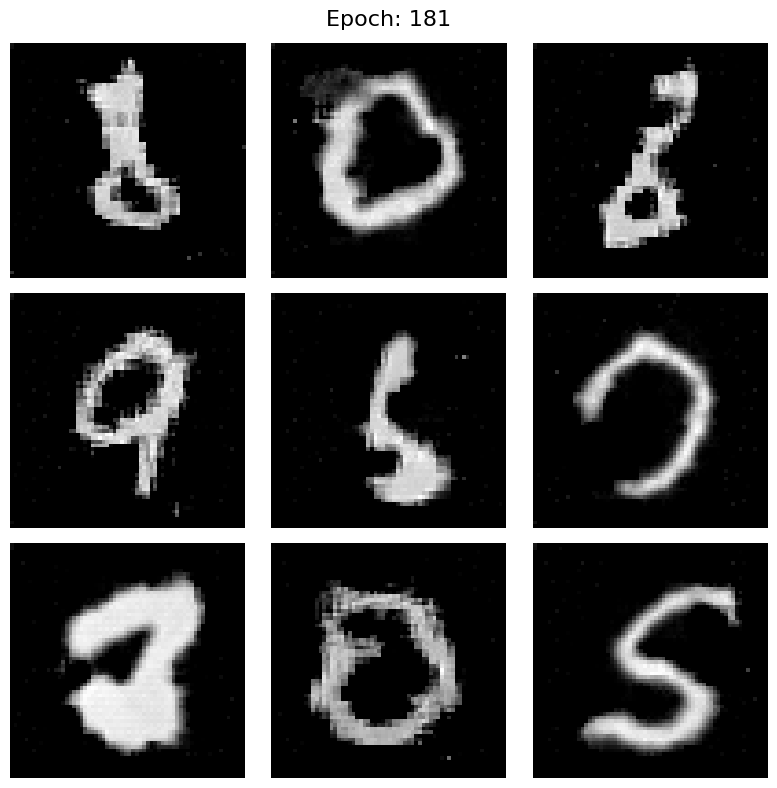

Epoch: 182/1000, d_loss: -0.4997, g_loss: 0.2514, time: 14.8634 sec


Epoch: 183/1000, d_loss: -0.4994, g_loss: 0.2499, time: 14.7510 sec


Epoch: 184/1000, d_loss: -0.4991, g_loss: 0.2607, time: 14.7068 sec


Epoch: 185/1000, d_loss: -0.5076, g_loss: 0.2547, time: 14.7034 sec


Epoch: 186/1000, d_loss: -0.5091, g_loss: 0.2634, time: 14.6609 sec


Epoch: 187/1000, d_loss: -0.5122, g_loss: 0.2573, time: 14.6921 sec


Epoch: 188/1000, d_loss: -0.5128, g_loss: 0.2668, time: 14.8171 sec


Epoch: 189/1000, d_loss: -0.5170, g_loss: 0.2591, time: 14.6825 sec


Epoch: 190/1000, d_loss: -0.5207, g_loss: 0.2721, time: 14.6561 sec


Epoch: 191/1000, d_loss: -0.5197, g_loss: 0.2617, time: 14.7918 sec


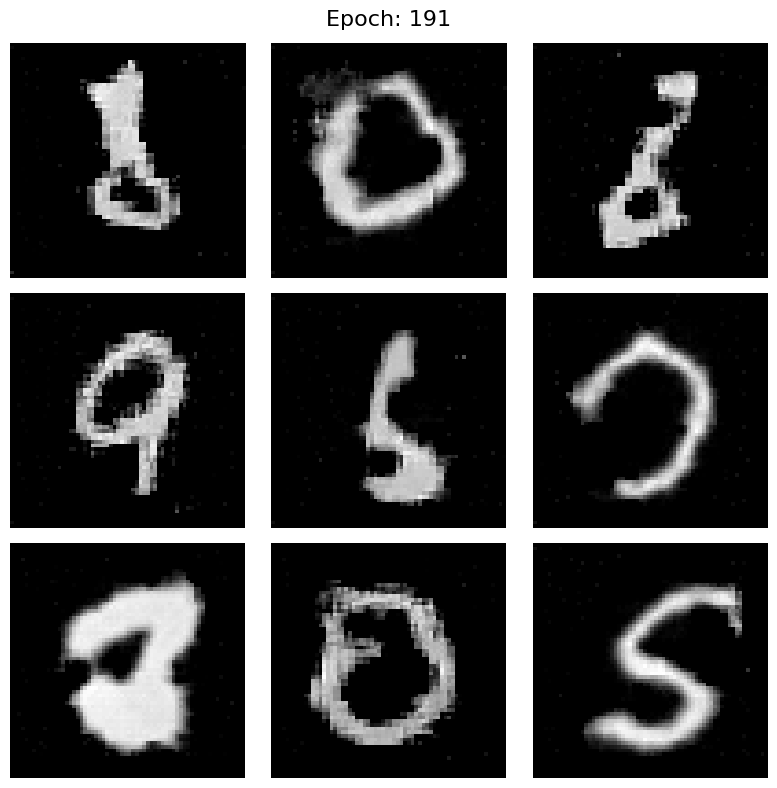

Epoch: 192/1000, d_loss: -0.5136, g_loss: 0.2646, time: 14.7745 sec


Epoch: 193/1000, d_loss: -0.5089, g_loss: 0.2555, time: 14.6874 sec


Epoch: 194/1000, d_loss: -0.5069, g_loss: 0.2625, time: 14.7420 sec


Epoch: 195/1000, d_loss: -0.5114, g_loss: 0.2592, time: 14.7230 sec


Epoch: 196/1000, d_loss: -0.5124, g_loss: 0.2593, time: 14.7810 sec


Epoch: 197/1000, d_loss: -0.5100, g_loss: 0.2648, time: 14.8324 sec


Epoch: 198/1000, d_loss: -0.5110, g_loss: 0.2598, time: 14.7696 sec


Epoch: 199/1000, d_loss: -0.5170, g_loss: 0.2694, time: 14.7234 sec


Epoch: 200/1000, d_loss: -0.5151, g_loss: 0.2591, time: 14.7499 sec


Epoch: 201/1000, d_loss: -0.5111, g_loss: 0.2659, time: 14.8317 sec


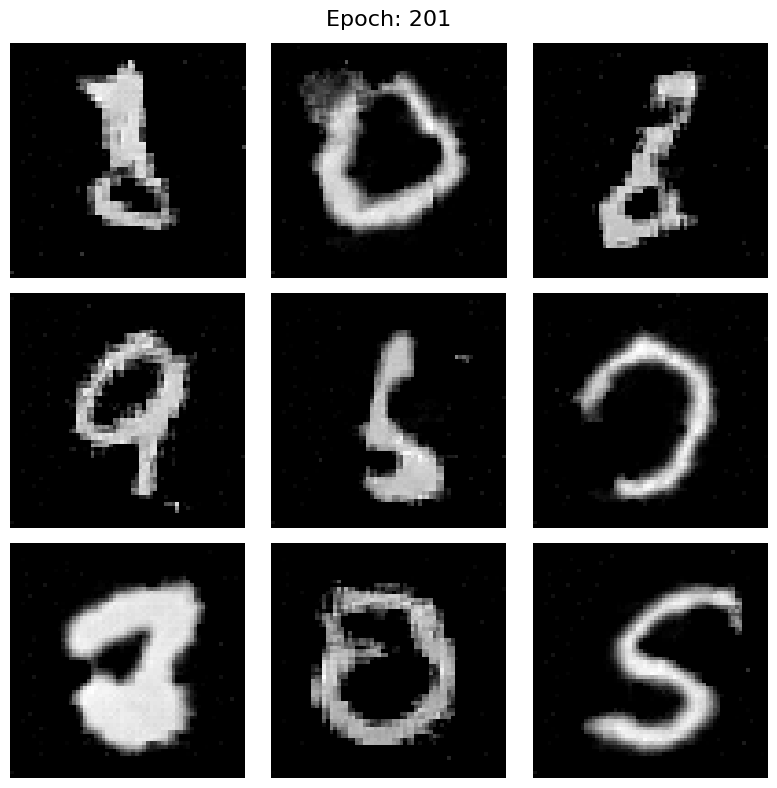

Epoch: 202/1000, d_loss: -0.5230, g_loss: 0.2671, time: 14.7321 sec


Epoch: 203/1000, d_loss: -0.5264, g_loss: 0.2746, time: 14.7613 sec


Epoch: 204/1000, d_loss: -0.5325, g_loss: 0.2705, time: 14.7168 sec


Epoch: 205/1000, d_loss: -0.5374, g_loss: 0.2815, time: 14.7217 sec


Epoch: 206/1000, d_loss: -0.5375, g_loss: 0.2729, time: 14.6905 sec


Epoch: 207/1000, d_loss: -0.5341, g_loss: 0.2766, time: 14.7375 sec


Epoch: 208/1000, d_loss: -0.5328, g_loss: 0.2697, time: 14.7853 sec


Epoch: 209/1000, d_loss: -0.5368, g_loss: 0.2817, time: 14.6890 sec


Epoch: 210/1000, d_loss: -0.5430, g_loss: 0.2857, time: 14.7238 sec


Epoch: 211/1000, d_loss: -0.5397, g_loss: 0.2748, time: 14.6250 sec


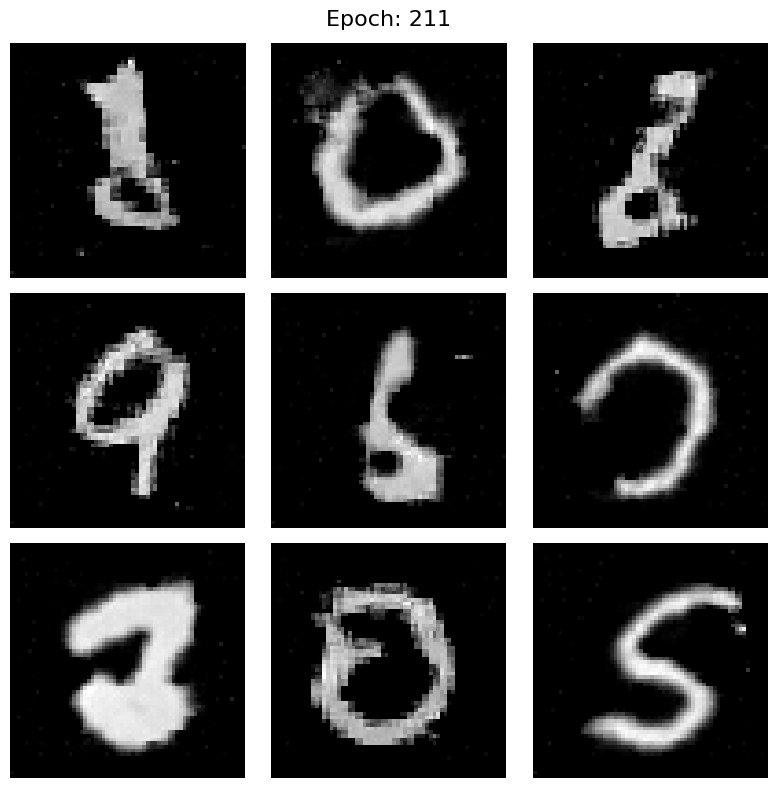

Epoch: 212/1000, d_loss: -0.5403, g_loss: 0.2835, time: 14.7471 sec


Epoch: 213/1000, d_loss: -0.5427, g_loss: 0.2744, time: 14.7573 sec


Epoch: 214/1000, d_loss: -0.5323, g_loss: 0.2790, time: 14.7704 sec


Epoch: 215/1000, d_loss: -0.5222, g_loss: 0.2647, time: 14.8148 sec


Epoch: 216/1000, d_loss: -0.5265, g_loss: 0.2749, time: 14.7515 sec


Epoch: 217/1000, d_loss: -0.5281, g_loss: 0.2674, time: 14.8127 sec


Epoch: 218/1000, d_loss: -0.5369, g_loss: 0.2807, time: 15.5917 sec


Epoch: 219/1000, d_loss: -0.5383, g_loss: 0.2753, time: 14.7738 sec


Epoch: 220/1000, d_loss: -0.5425, g_loss: 0.2851, time: 14.8578 sec


Epoch: 221/1000, d_loss: -0.5470, g_loss: 0.2774, time: 14.7239 sec


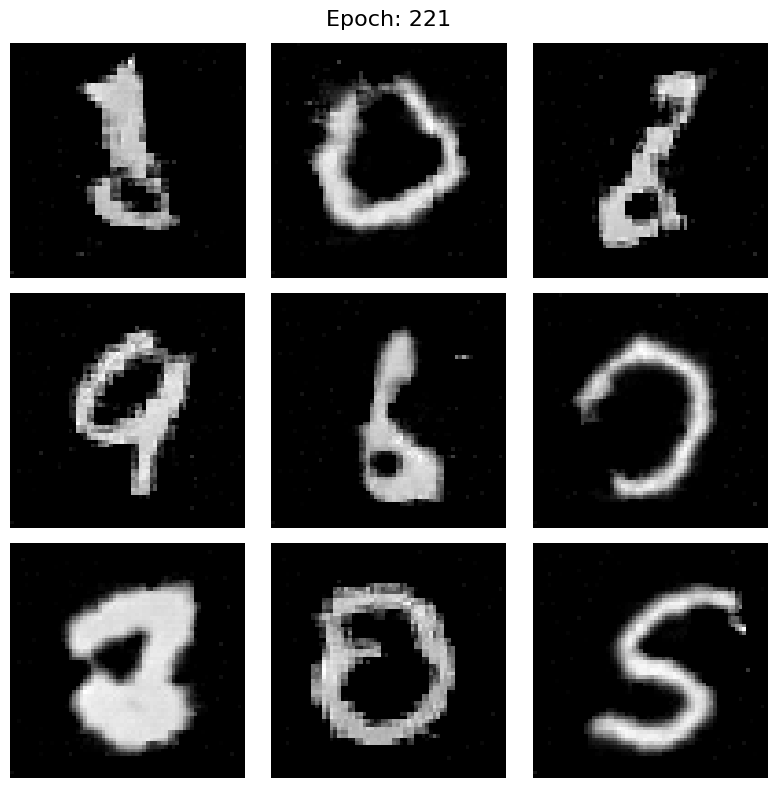

Epoch: 222/1000, d_loss: -0.5443, g_loss: 0.2852, time: 14.6869 sec


Epoch: 223/1000, d_loss: -0.5469, g_loss: 0.2789, time: 14.8283 sec


Epoch: 224/1000, d_loss: -0.5457, g_loss: 0.2860, time: 14.7214 sec


Epoch: 225/1000, d_loss: -0.5455, g_loss: 0.2755, time: 14.7919 sec


Epoch: 226/1000, d_loss: -0.5425, g_loss: 0.2748, time: 14.7141 sec


Epoch: 227/1000, d_loss: -0.5478, g_loss: 0.2864, time: 14.6740 sec


Epoch: 228/1000, d_loss: -0.5517, g_loss: 0.2788, time: 14.6549 sec


Epoch: 229/1000, d_loss: -0.5553, g_loss: 0.2889, time: 14.6629 sec


Epoch: 230/1000, d_loss: -0.5530, g_loss: 0.2793, time: 14.7741 sec


Epoch: 231/1000, d_loss: -0.5517, g_loss: 0.2883, time: 14.7394 sec


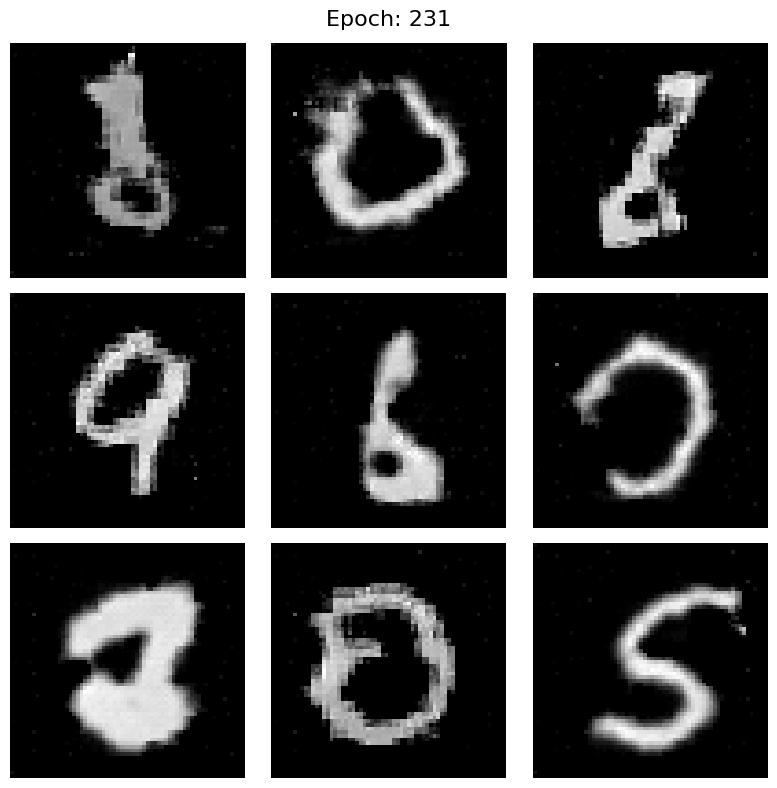

Epoch: 232/1000, d_loss: -0.5519, g_loss: 0.2795, time: 14.7557 sec


Epoch: 233/1000, d_loss: -0.5551, g_loss: 0.2826, time: 14.7163 sec


Epoch: 234/1000, d_loss: -0.5591, g_loss: 0.2928, time: 14.7477 sec


Epoch: 235/1000, d_loss: -0.5519, g_loss: 0.2793, time: 14.7085 sec


Epoch: 236/1000, d_loss: -0.5465, g_loss: 0.2856, time: 14.8154 sec


Epoch: 237/1000, d_loss: -0.5496, g_loss: 0.2801, time: 14.7279 sec


Epoch: 238/1000, d_loss: -0.5516, g_loss: 0.2903, time: 14.6998 sec


Epoch: 239/1000, d_loss: -0.5482, g_loss: 0.2809, time: 14.8047 sec


Epoch: 240/1000, d_loss: -0.5522, g_loss: 0.2923, time: 14.8488 sec


Epoch: 241/1000, d_loss: -0.5499, g_loss: 0.2787, time: 14.6724 sec


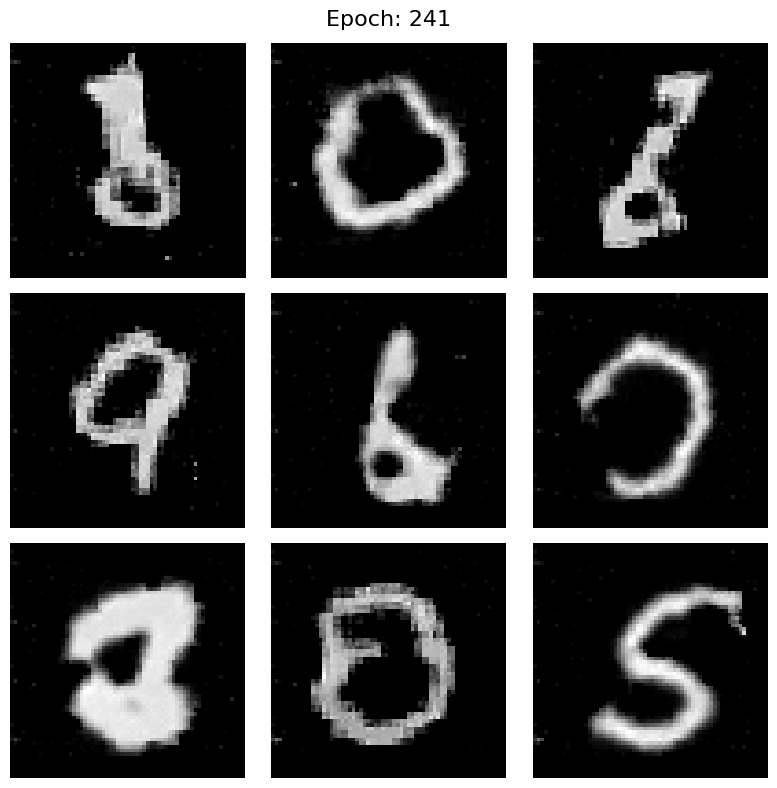

Epoch: 242/1000, d_loss: -0.5436, g_loss: 0.2872, time: 14.8486 sec


Epoch: 243/1000, d_loss: -0.5412, g_loss: 0.2752, time: 14.7203 sec


Epoch: 244/1000, d_loss: -0.5517, g_loss: 0.2905, time: 14.7853 sec


Epoch: 245/1000, d_loss: -0.5602, g_loss: 0.2842, time: 14.7141 sec


Epoch: 246/1000, d_loss: -0.5600, g_loss: 0.2941, time: 14.8075 sec


Epoch: 247/1000, d_loss: -0.5555, g_loss: 0.2807, time: 14.8161 sec


Epoch: 248/1000, d_loss: -0.5620, g_loss: 0.2948, time: 14.8017 sec


Epoch: 249/1000, d_loss: -0.5650, g_loss: 0.2944, time: 14.8074 sec


Epoch: 250/1000, d_loss: -0.5692, g_loss: 0.2875, time: 14.8039 sec


Epoch: 251/1000, d_loss: -0.5720, g_loss: 0.2993, time: 14.7784 sec


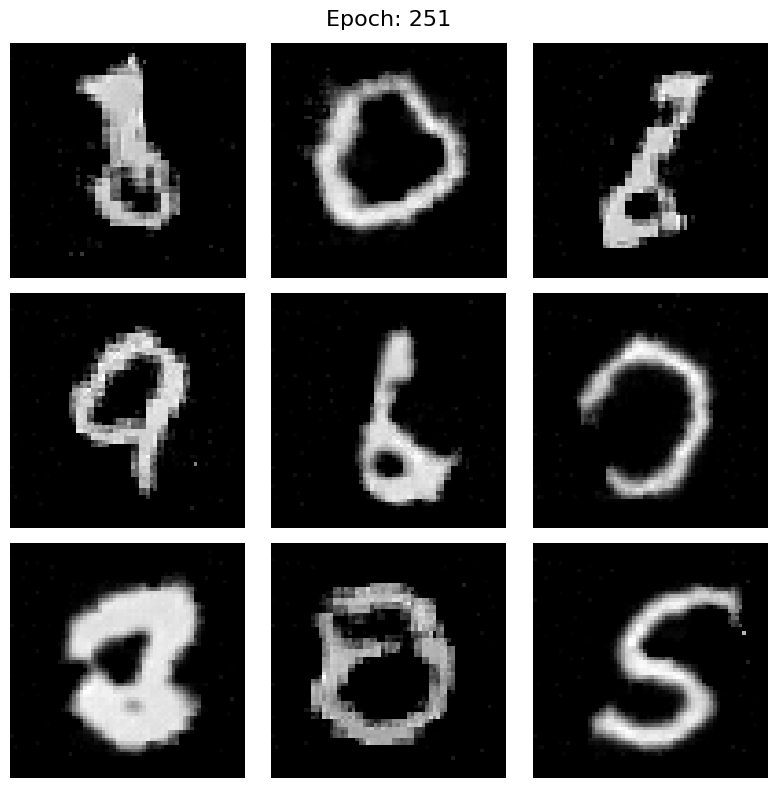

Epoch: 252/1000, d_loss: -0.5671, g_loss: 0.2849, time: 14.7771 sec


Epoch: 253/1000, d_loss: -0.5580, g_loss: 0.2917, time: 14.7646 sec


Epoch: 254/1000, d_loss: -0.5733, g_loss: 0.2906, time: 14.7945 sec


Epoch: 255/1000, d_loss: -0.5769, g_loss: 0.3014, time: 14.6637 sec


Epoch: 256/1000, d_loss: -0.5775, g_loss: 0.2932, time: 14.7200 sec


Epoch: 257/1000, d_loss: -0.5775, g_loss: 0.3013, time: 14.7291 sec


Epoch: 258/1000, d_loss: -0.5755, g_loss: 0.2934, time: 14.8244 sec


Epoch: 259/1000, d_loss: -0.5751, g_loss: 0.2999, time: 14.8509 sec


Epoch: 260/1000, d_loss: -0.5732, g_loss: 0.2899, time: 14.7984 sec


Epoch: 261/1000, d_loss: -0.5755, g_loss: 0.3014, time: 14.7833 sec


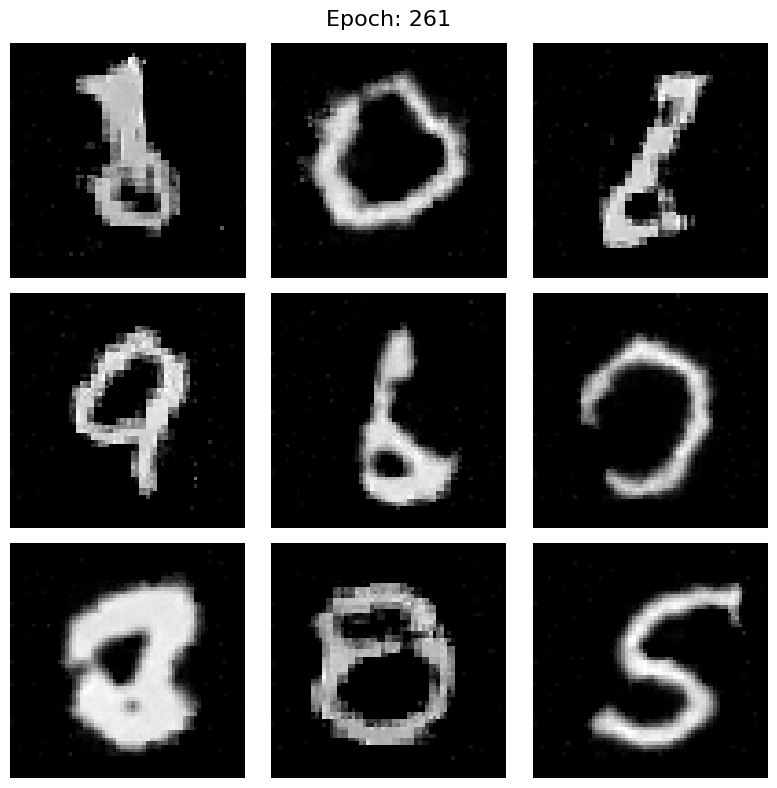

Epoch: 262/1000, d_loss: -0.5813, g_loss: 0.2943, time: 14.8221 sec


Epoch: 263/1000, d_loss: -0.5805, g_loss: 0.2917, time: 14.7797 sec


Epoch: 264/1000, d_loss: -0.5805, g_loss: 0.3008, time: 14.7276 sec


Epoch: 265/1000, d_loss: -0.5836, g_loss: 0.2960, time: 14.7459 sec


Epoch: 266/1000, d_loss: -0.5951, g_loss: 0.3095, time: 14.7585 sec


Epoch: 267/1000, d_loss: -0.5961, g_loss: 0.3031, time: 14.7263 sec


Epoch: 268/1000, d_loss: -0.5978, g_loss: 0.3135, time: 14.8503 sec


Epoch: 269/1000, d_loss: -0.5975, g_loss: 0.3037, time: 14.7946 sec


Epoch: 270/1000, d_loss: -0.6014, g_loss: 0.3131, time: 14.8299 sec


Epoch: 271/1000, d_loss: -0.5994, g_loss: 0.3032, time: 14.8148 sec


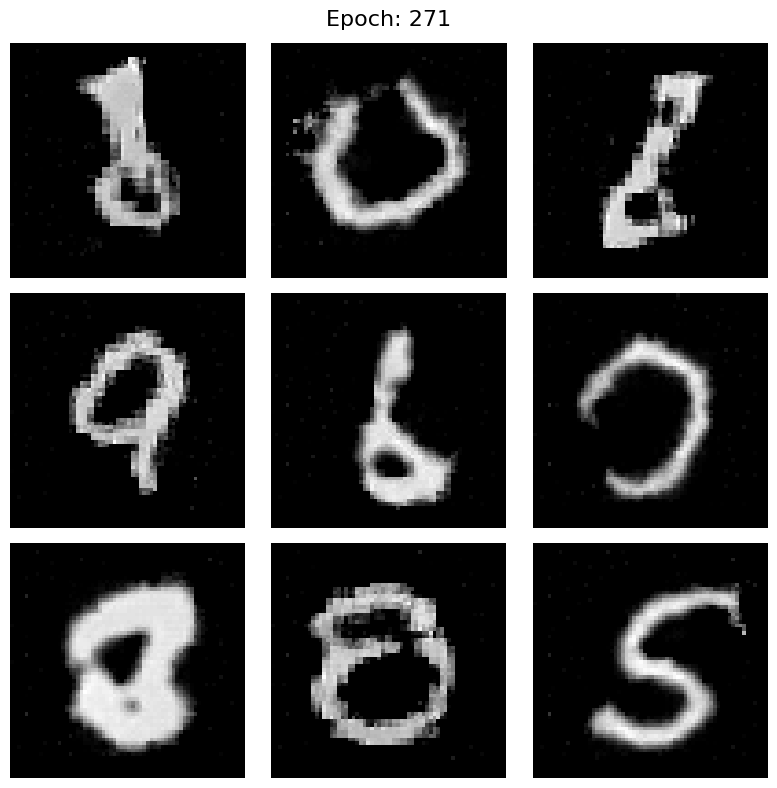

Epoch: 272/1000, d_loss: -0.6017, g_loss: 0.3133, time: 14.8516 sec


Epoch: 273/1000, d_loss: -0.6043, g_loss: 0.3068, time: 14.8033 sec


Epoch: 274/1000, d_loss: -0.6027, g_loss: 0.3134, time: 14.7517 sec


Epoch: 275/1000, d_loss: -0.6015, g_loss: 0.3026, time: 14.6900 sec


Epoch: 276/1000, d_loss: -0.6051, g_loss: 0.3060, time: 14.7984 sec


Epoch: 277/1000, d_loss: -0.6050, g_loss: 0.3123, time: 14.8375 sec


Epoch: 278/1000, d_loss: -0.6055, g_loss: 0.3054, time: 14.7749 sec


Epoch: 279/1000, d_loss: -0.5986, g_loss: 0.3122, time: 14.7165 sec


Epoch: 280/1000, d_loss: -0.5986, g_loss: 0.3010, time: 14.7685 sec


Epoch: 281/1000, d_loss: -0.6041, g_loss: 0.3130, time: 14.8093 sec


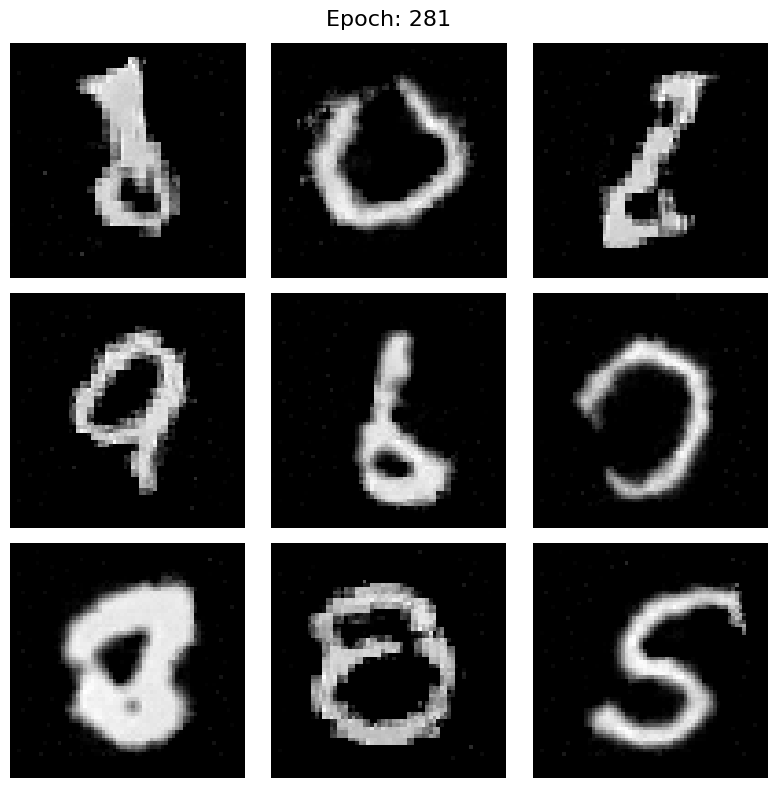

Epoch: 282/1000, d_loss: -0.6134, g_loss: 0.3068, time: 14.9002 sec


Epoch: 283/1000, d_loss: -0.6132, g_loss: 0.3191, time: 14.8635 sec


Epoch: 284/1000, d_loss: -0.6199, g_loss: 0.3142, time: 14.7736 sec


Epoch: 285/1000, d_loss: -0.6242, g_loss: 0.3240, time: 14.8016 sec


Epoch: 286/1000, d_loss: -0.6217, g_loss: 0.3123, time: 14.7316 sec


Epoch: 287/1000, d_loss: -0.6201, g_loss: 0.3232, time: 14.8096 sec


Epoch: 288/1000, d_loss: -0.6172, g_loss: 0.3112, time: 14.7785 sec


Epoch: 289/1000, d_loss: -0.6150, g_loss: 0.3188, time: 14.6857 sec


Epoch: 290/1000, d_loss: -0.6262, g_loss: 0.3237, time: 14.8498 sec


Epoch: 291/1000, d_loss: -0.6326, g_loss: 0.3200, time: 14.7749 sec


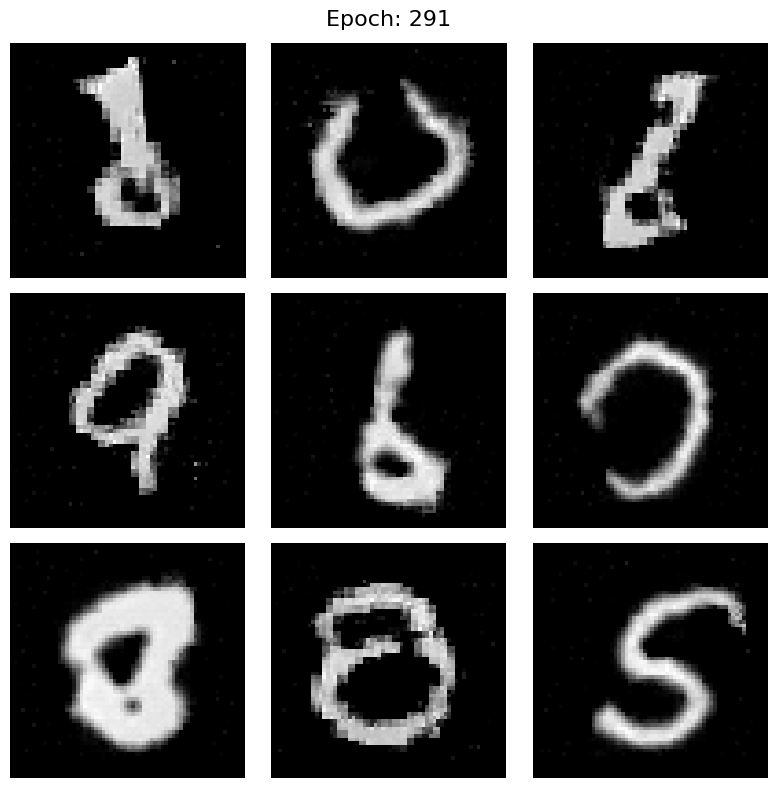

Epoch: 292/1000, d_loss: -0.6302, g_loss: 0.3261, time: 14.9082 sec


Epoch: 293/1000, d_loss: -0.6235, g_loss: 0.3133, time: 14.6830 sec


Epoch: 294/1000, d_loss: -0.6325, g_loss: 0.3279, time: 14.7363 sec


Epoch: 295/1000, d_loss: -0.6354, g_loss: 0.3223, time: 14.7669 sec


Epoch: 296/1000, d_loss: -0.6341, g_loss: 0.3278, time: 14.7458 sec


Epoch: 297/1000, d_loss: -0.6358, g_loss: 0.3233, time: 14.8687 sec


Epoch: 298/1000, d_loss: -0.6385, g_loss: 0.3295, time: 14.6828 sec


Epoch: 299/1000, d_loss: -0.6379, g_loss: 0.3225, time: 14.6895 sec


Epoch: 300/1000, d_loss: -0.6371, g_loss: 0.3322, time: 14.7143 sec


Epoch: 301/1000, d_loss: -0.6315, g_loss: 0.3179, time: 14.7435 sec


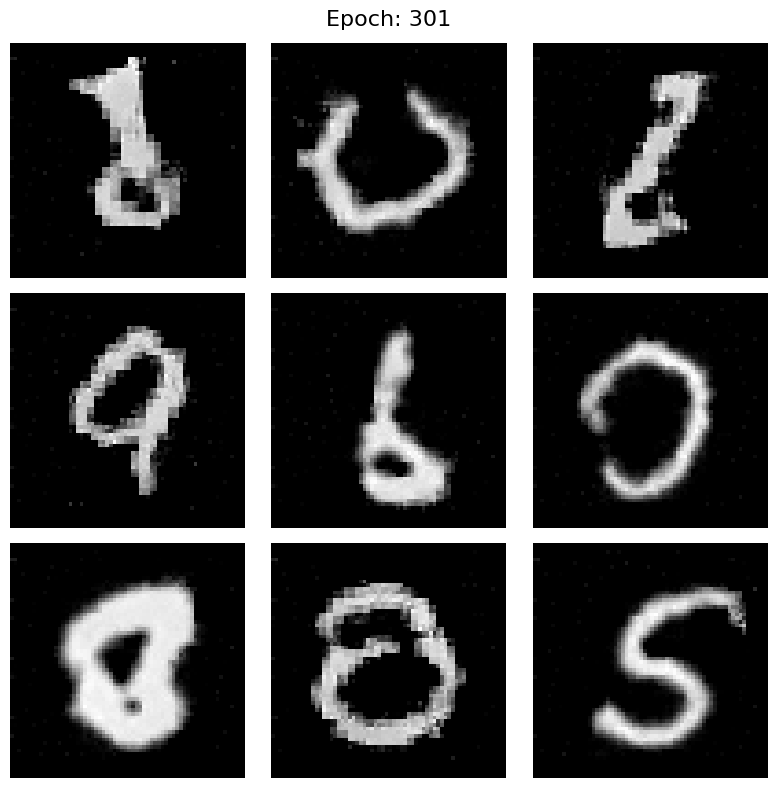

Epoch: 302/1000, d_loss: -0.6310, g_loss: 0.3267, time: 14.8701 sec


Epoch: 303/1000, d_loss: -0.6366, g_loss: 0.3245, time: 14.7343 sec


Epoch: 304/1000, d_loss: -0.6392, g_loss: 0.3322, time: 14.7059 sec


Epoch: 305/1000, d_loss: -0.6436, g_loss: 0.3267, time: 14.7192 sec


Epoch: 306/1000, d_loss: -0.6445, g_loss: 0.3275, time: 14.8226 sec


Epoch: 307/1000, d_loss: -0.6480, g_loss: 0.3379, time: 14.8038 sec


Epoch: 308/1000, d_loss: -0.6471, g_loss: 0.3290, time: 14.7934 sec


Epoch: 309/1000, d_loss: -0.6452, g_loss: 0.3365, time: 14.7302 sec


Epoch: 310/1000, d_loss: -0.6494, g_loss: 0.3303, time: 14.7696 sec


Epoch: 311/1000, d_loss: -0.6572, g_loss: 0.3412, time: 14.7414 sec


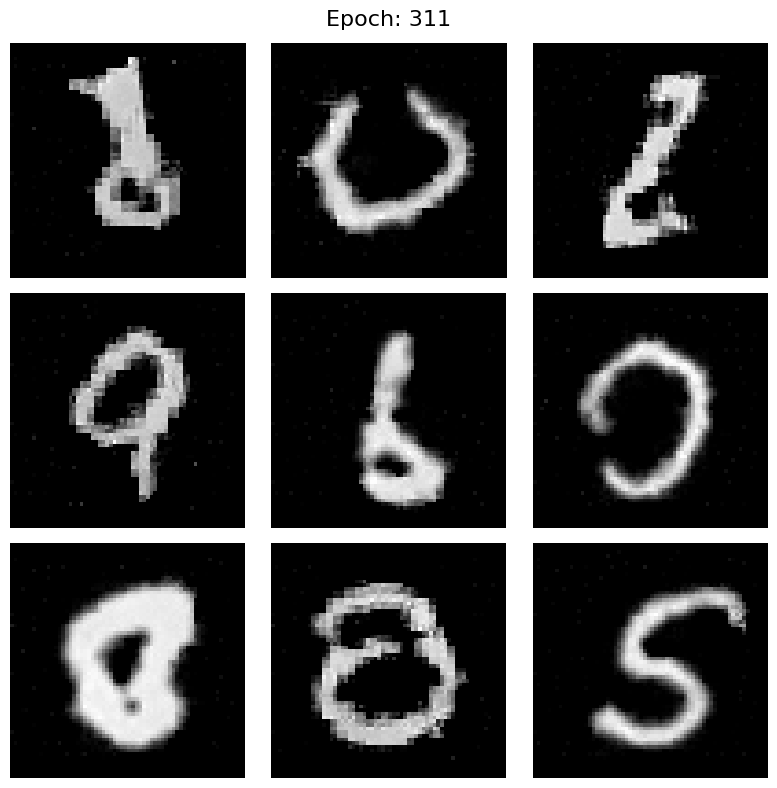

Epoch: 312/1000, d_loss: -0.6533, g_loss: 0.3325, time: 14.7563 sec


Epoch: 313/1000, d_loss: -0.6471, g_loss: 0.3337, time: 14.6829 sec


Epoch: 314/1000, d_loss: -0.6517, g_loss: 0.3325, time: 14.7734 sec


Epoch: 315/1000, d_loss: -0.6588, g_loss: 0.3416, time: 14.8051 sec


Epoch: 316/1000, d_loss: -0.6617, g_loss: 0.3329, time: 14.8512 sec


Epoch: 317/1000, d_loss: -0.6568, g_loss: 0.3414, time: 14.7558 sec


Epoch: 318/1000, d_loss: -0.6577, g_loss: 0.3318, time: 14.7965 sec


Epoch: 319/1000, d_loss: -0.6664, g_loss: 0.3357, time: 14.7807 sec


Epoch: 320/1000, d_loss: -0.6579, g_loss: 0.3400, time: 14.6889 sec


Epoch: 321/1000, d_loss: -0.6620, g_loss: 0.3384, time: 14.7661 sec


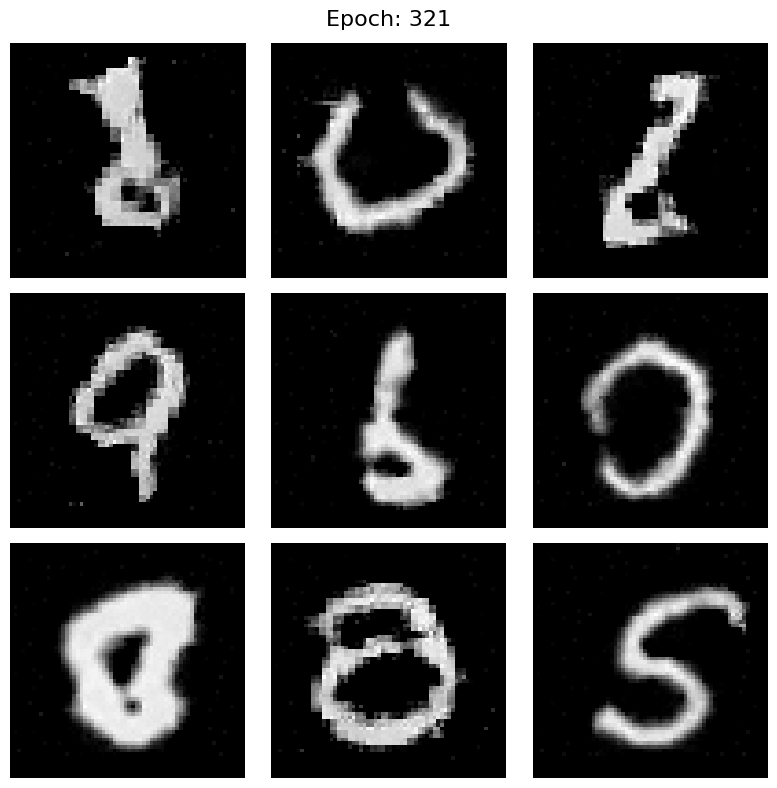

Epoch: 322/1000, d_loss: -0.6675, g_loss: 0.3484, time: 14.8318 sec


Epoch: 323/1000, d_loss: -0.6725, g_loss: 0.3412, time: 14.7591 sec


Epoch: 324/1000, d_loss: -0.6716, g_loss: 0.3491, time: 14.7781 sec


Epoch: 325/1000, d_loss: -0.6751, g_loss: 0.3418, time: 14.6931 sec


Epoch: 326/1000, d_loss: -0.6742, g_loss: 0.3486, time: 14.7257 sec


Epoch: 327/1000, d_loss: -0.6767, g_loss: 0.3450, time: 14.7323 sec


Epoch: 328/1000, d_loss: -0.6796, g_loss: 0.3556, time: 14.7501 sec


Epoch: 329/1000, d_loss: -0.6752, g_loss: 0.3451, time: 14.7608 sec


Epoch: 330/1000, d_loss: -0.6761, g_loss: 0.3539, time: 14.7719 sec


Epoch: 331/1000, d_loss: -0.6798, g_loss: 0.3440, time: 14.8026 sec


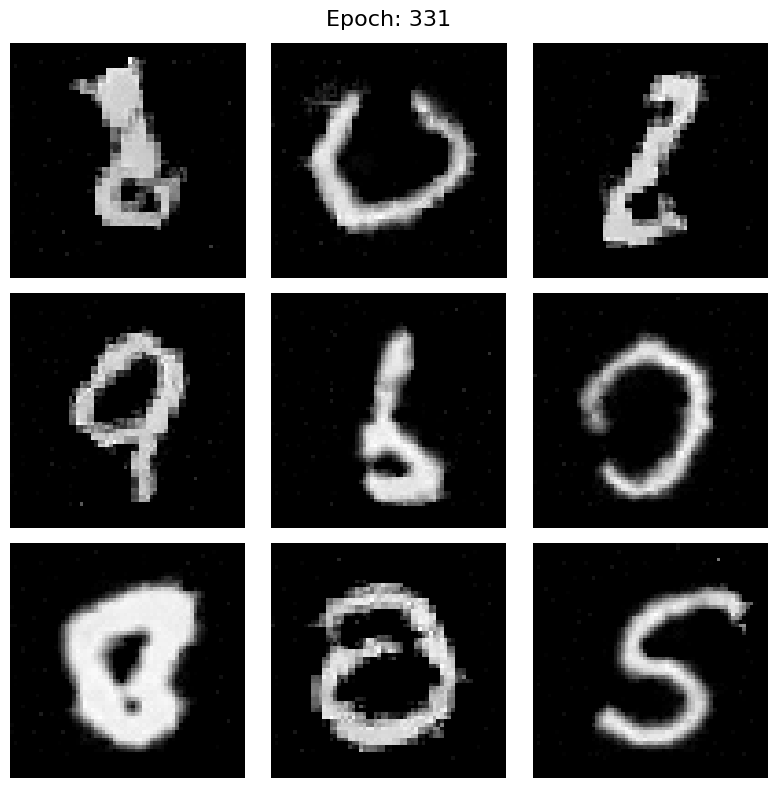

Epoch: 332/1000, d_loss: -0.6846, g_loss: 0.3598, time: 14.8007 sec


Epoch: 333/1000, d_loss: -0.6907, g_loss: 0.3640, time: 14.7330 sec


Epoch: 334/1000, d_loss: -0.6928, g_loss: 0.3568, time: 14.7924 sec


Epoch: 335/1000, d_loss: -0.6922, g_loss: 0.3665, time: 14.7165 sec


Epoch: 336/1000, d_loss: -0.6917, g_loss: 0.3540, time: 14.7537 sec


Epoch: 337/1000, d_loss: -0.6959, g_loss: 0.3640, time: 14.8033 sec


Epoch: 338/1000, d_loss: -0.6996, g_loss: 0.3559, time: 14.7490 sec


Epoch: 339/1000, d_loss: -0.6894, g_loss: 0.3606, time: 14.7507 sec


Epoch: 340/1000, d_loss: -0.6781, g_loss: 0.3468, time: 14.6845 sec


Epoch: 341/1000, d_loss: -0.6810, g_loss: 0.3581, time: 14.7361 sec


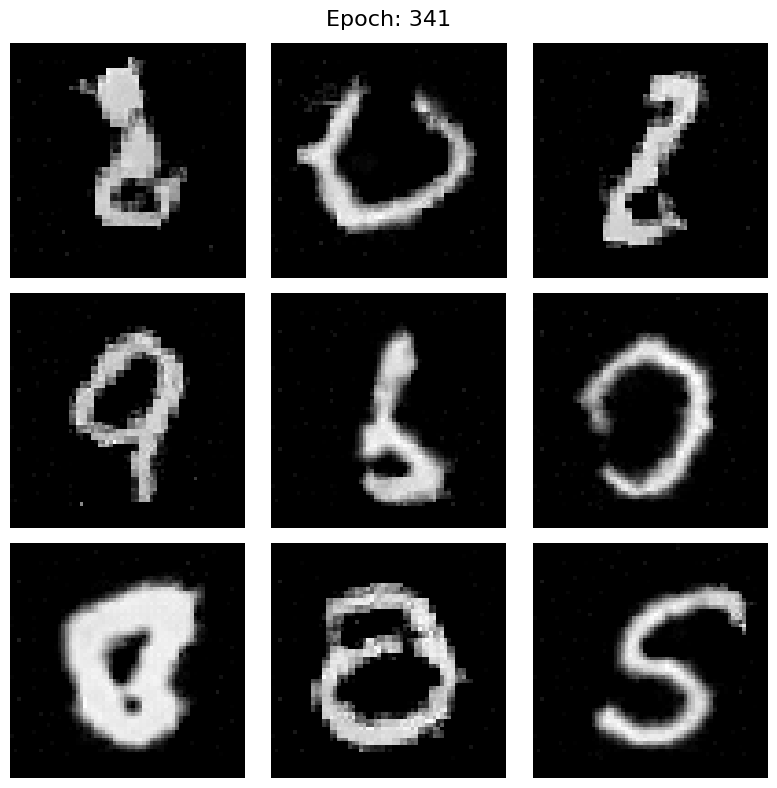

Epoch: 342/1000, d_loss: -0.6832, g_loss: 0.3512, time: 14.7056 sec


Epoch: 343/1000, d_loss: -0.6899, g_loss: 0.3618, time: 14.7475 sec


Epoch: 344/1000, d_loss: -0.6943, g_loss: 0.3580, time: 14.7234 sec


Epoch: 345/1000, d_loss: -0.6994, g_loss: 0.3692, time: 14.6957 sec


Epoch: 346/1000, d_loss: -0.7027, g_loss: 0.3579, time: 14.7497 sec


Epoch: 347/1000, d_loss: -0.6983, g_loss: 0.3662, time: 14.8047 sec


Epoch: 348/1000, d_loss: -0.6997, g_loss: 0.3591, time: 14.8117 sec


Epoch: 349/1000, d_loss: -0.6984, g_loss: 0.3601, time: 14.8427 sec


Epoch: 350/1000, d_loss: -0.7059, g_loss: 0.3740, time: 14.7180 sec


Epoch: 351/1000, d_loss: -0.7086, g_loss: 0.3642, time: 14.7147 sec


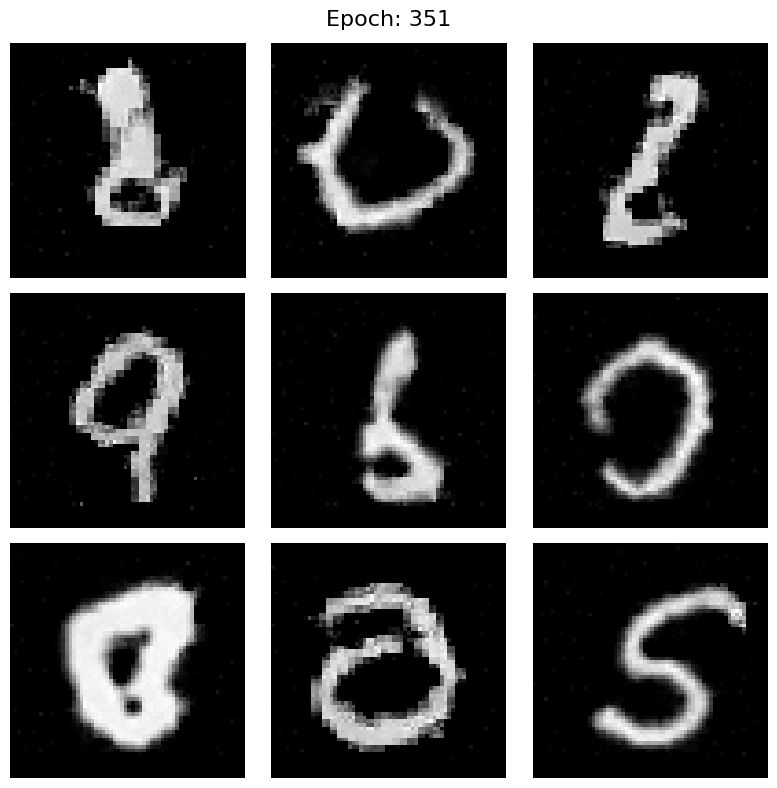

Epoch: 352/1000, d_loss: -0.7131, g_loss: 0.3747, time: 14.7901 sec


Epoch: 353/1000, d_loss: -0.7079, g_loss: 0.3652, time: 14.7880 sec


Epoch: 354/1000, d_loss: -0.7093, g_loss: 0.3737, time: 14.7121 sec


Epoch: 355/1000, d_loss: -0.7151, g_loss: 0.3685, time: 14.7731 sec


Epoch: 356/1000, d_loss: -0.7178, g_loss: 0.3811, time: 14.7059 sec


Epoch: 357/1000, d_loss: -0.7174, g_loss: 0.3741, time: 14.7329 sec


Epoch: 358/1000, d_loss: -0.7266, g_loss: 0.3835, time: 14.9107 sec


Epoch: 359/1000, d_loss: -0.7221, g_loss: 0.3714, time: 14.8060 sec


Epoch: 360/1000, d_loss: -0.7253, g_loss: 0.3822, time: 14.7153 sec


Epoch: 361/1000, d_loss: -0.7292, g_loss: 0.3760, time: 14.7350 sec


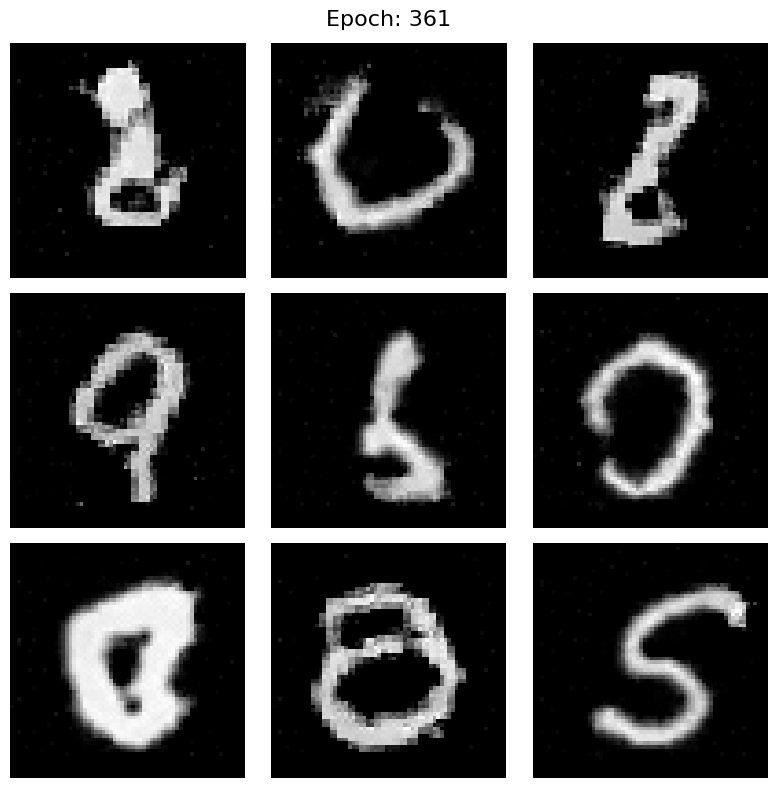

Epoch: 362/1000, d_loss: -0.7326, g_loss: 0.3787, time: 14.9108 sec


Epoch: 363/1000, d_loss: -0.7328, g_loss: 0.3854, time: 14.6899 sec


Epoch: 364/1000, d_loss: -0.7269, g_loss: 0.3748, time: 14.8647 sec


Epoch: 365/1000, d_loss: -0.7304, g_loss: 0.3839, time: 14.6881 sec


Epoch: 366/1000, d_loss: -0.7330, g_loss: 0.3794, time: 14.7146 sec


Epoch: 367/1000, d_loss: -0.7360, g_loss: 0.3883, time: 14.7827 sec


Epoch: 368/1000, d_loss: -0.7400, g_loss: 0.3816, time: 14.6963 sec


Epoch: 369/1000, d_loss: -0.7401, g_loss: 0.3890, time: 14.7798 sec


Epoch: 370/1000, d_loss: -0.7397, g_loss: 0.3816, time: 14.7521 sec


Epoch: 371/1000, d_loss: -0.7375, g_loss: 0.3862, time: 14.6464 sec


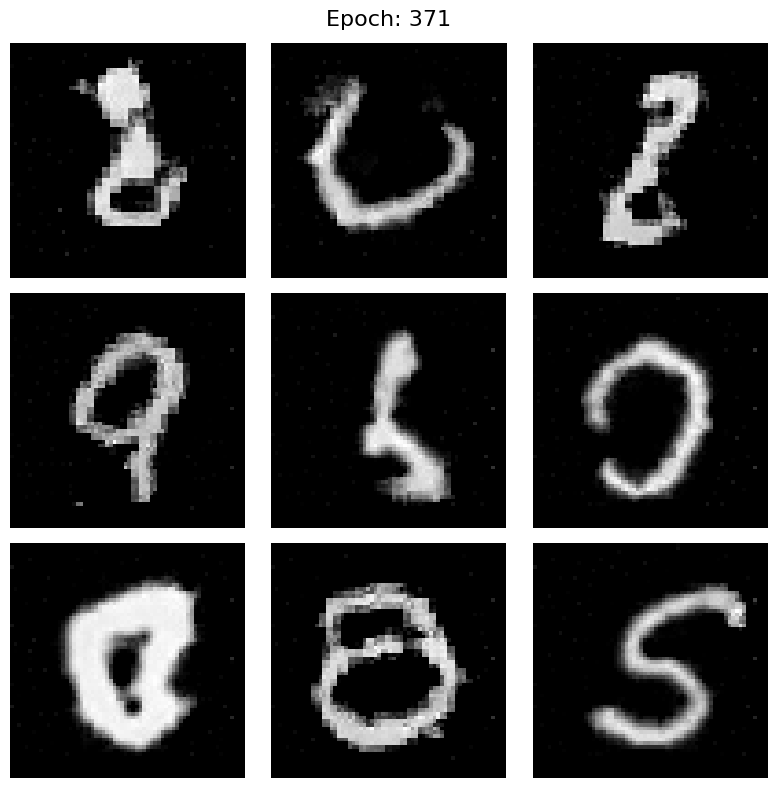

Epoch: 372/1000, d_loss: -0.7350, g_loss: 0.3785, time: 14.7856 sec


Epoch: 373/1000, d_loss: -0.7389, g_loss: 0.3890, time: 14.8456 sec


Epoch: 374/1000, d_loss: -0.7383, g_loss: 0.3804, time: 14.6941 sec


Epoch: 375/1000, d_loss: -0.7431, g_loss: 0.3899, time: 14.6481 sec


Epoch: 376/1000, d_loss: -0.7512, g_loss: 0.3935, time: 14.6965 sec


Epoch: 377/1000, d_loss: -0.7518, g_loss: 0.3838, time: 14.7620 sec


Epoch: 378/1000, d_loss: -0.7528, g_loss: 0.3916, time: 14.6950 sec


Epoch: 379/1000, d_loss: -0.7493, g_loss: 0.3840, time: 14.7461 sec


Epoch: 380/1000, d_loss: -0.7542, g_loss: 0.3947, time: 14.6859 sec


Epoch: 381/1000, d_loss: -0.7528, g_loss: 0.3841, time: 14.6767 sec


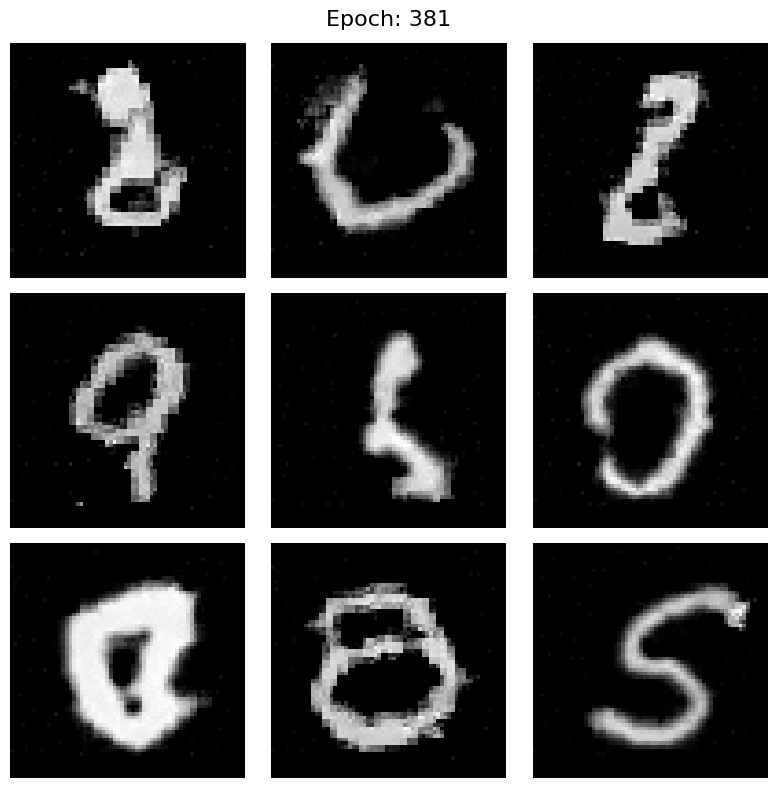

Epoch: 382/1000, d_loss: -0.7533, g_loss: 0.3939, time: 14.7043 sec


Epoch: 383/1000, d_loss: -0.7601, g_loss: 0.3878, time: 14.8271 sec


Epoch: 384/1000, d_loss: -0.7654, g_loss: 0.3975, time: 14.6967 sec


Epoch: 385/1000, d_loss: -0.7661, g_loss: 0.3935, time: 14.6834 sec


Epoch: 386/1000, d_loss: -0.7677, g_loss: 0.3963, time: 14.8175 sec


Epoch: 387/1000, d_loss: -0.7699, g_loss: 0.3894, time: 14.7578 sec


Epoch: 388/1000, d_loss: -0.7721, g_loss: 0.4006, time: 14.7953 sec


Epoch: 389/1000, d_loss: -0.7730, g_loss: 0.3914, time: 14.7439 sec


Epoch: 390/1000, d_loss: -0.7725, g_loss: 0.3986, time: 14.7967 sec


Epoch: 391/1000, d_loss: -0.7738, g_loss: 0.3938, time: 14.6832 sec


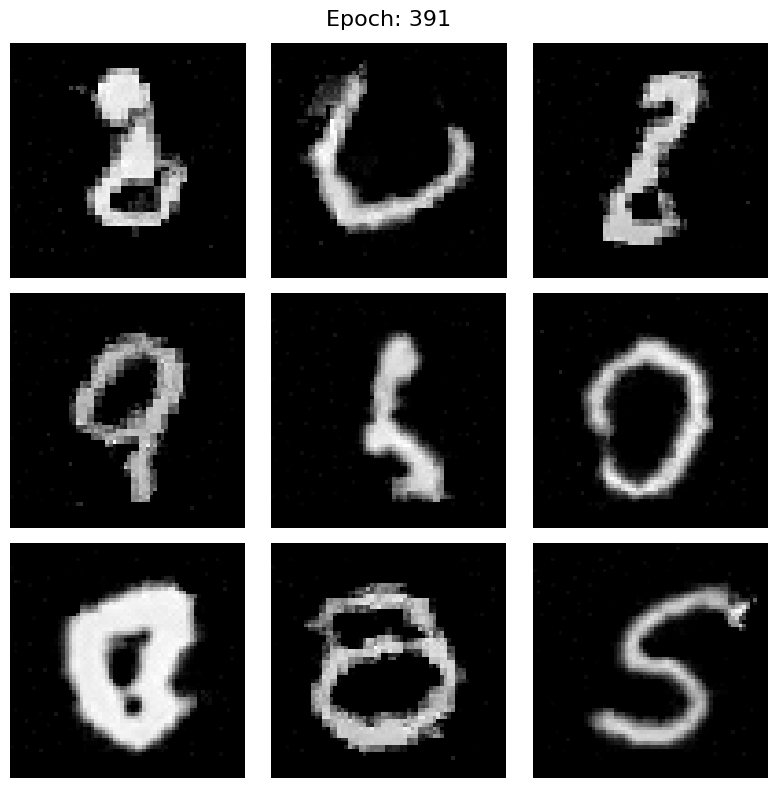

Epoch: 392/1000, d_loss: -0.7784, g_loss: 0.3970, time: 14.8667 sec


Epoch: 393/1000, d_loss: -0.7784, g_loss: 0.4027, time: 14.8756 sec


Epoch: 394/1000, d_loss: -0.7777, g_loss: 0.3961, time: 14.6633 sec


Epoch: 395/1000, d_loss: -0.7776, g_loss: 0.4039, time: 14.7798 sec


Epoch: 396/1000, d_loss: -0.7765, g_loss: 0.3947, time: 14.7710 sec


Epoch: 397/1000, d_loss: -0.7785, g_loss: 0.4024, time: 14.7387 sec


Epoch: 398/1000, d_loss: -0.7799, g_loss: 0.3957, time: 14.7702 sec


Epoch: 399/1000, d_loss: -0.7786, g_loss: 0.4031, time: 14.7839 sec


Epoch: 400/1000, d_loss: -0.7797, g_loss: 0.3953, time: 14.8306 sec


Epoch: 401/1000, d_loss: -0.7814, g_loss: 0.4058, time: 14.7560 sec


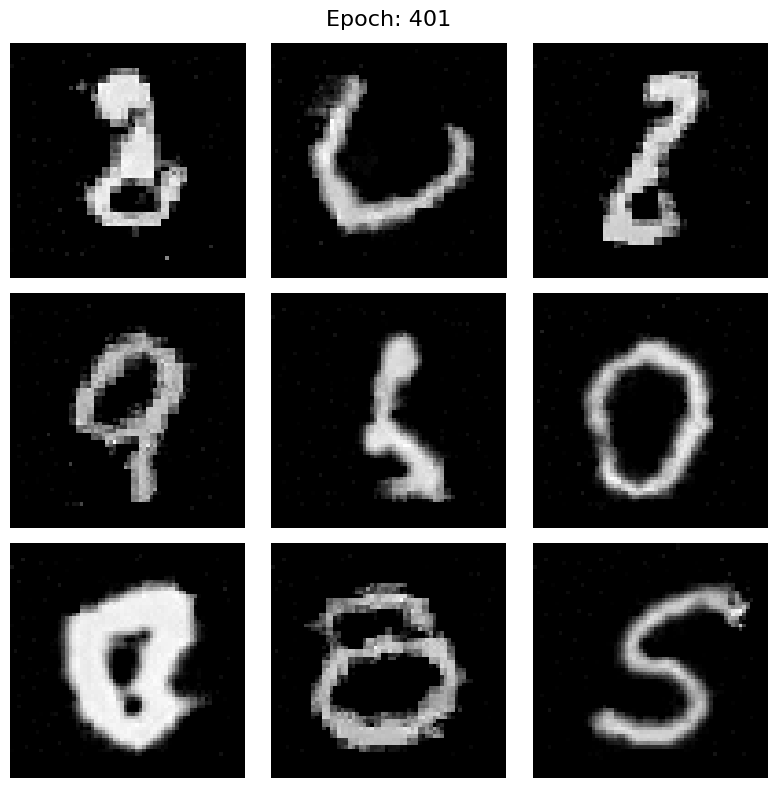

Epoch: 402/1000, d_loss: -0.7769, g_loss: 0.3940, time: 14.9031 sec


Epoch: 403/1000, d_loss: -0.7845, g_loss: 0.4072, time: 14.7545 sec


Epoch: 404/1000, d_loss: -0.7736, g_loss: 0.3913, time: 14.6533 sec


Epoch: 405/1000, d_loss: -0.7758, g_loss: 0.3946, time: 14.6579 sec


Epoch: 406/1000, d_loss: -0.7787, g_loss: 0.4032, time: 14.7541 sec


Epoch: 407/1000, d_loss: -0.7857, g_loss: 0.3984, time: 14.8357 sec


Epoch: 408/1000, d_loss: -0.7882, g_loss: 0.4077, time: 14.7176 sec


Epoch: 409/1000, d_loss: -0.7869, g_loss: 0.3993, time: 14.7638 sec


Epoch: 410/1000, d_loss: -0.7899, g_loss: 0.4090, time: 14.7212 sec


Epoch: 411/1000, d_loss: -0.7869, g_loss: 0.4006, time: 14.6656 sec


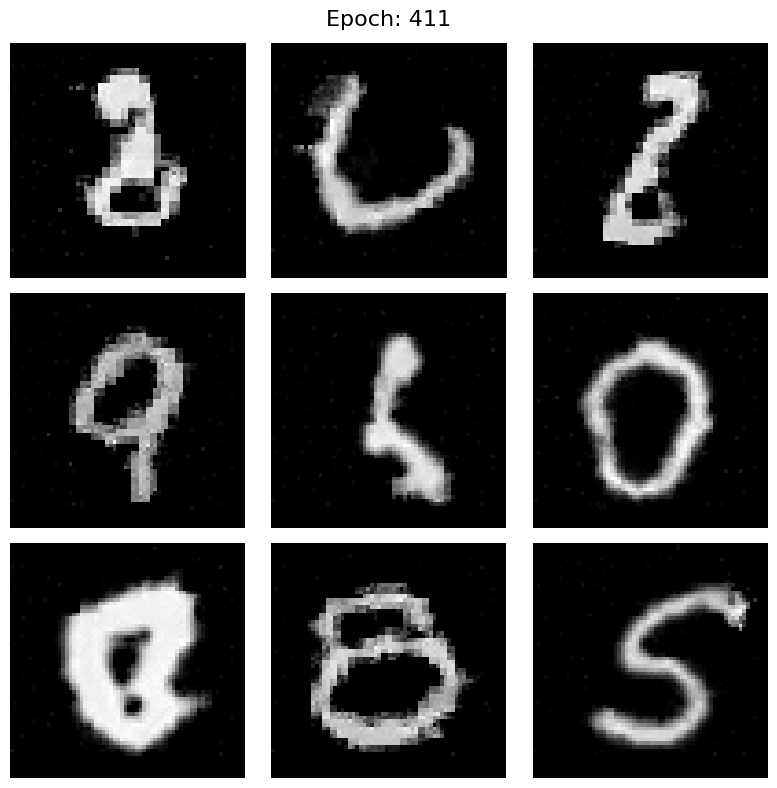

Epoch: 412/1000, d_loss: -0.7889, g_loss: 0.4081, time: 14.6900 sec


Epoch: 413/1000, d_loss: -0.7878, g_loss: 0.3984, time: 14.6943 sec


Epoch: 414/1000, d_loss: -0.7915, g_loss: 0.4096, time: 14.6968 sec


Epoch: 415/1000, d_loss: -0.7876, g_loss: 0.3989, time: 14.7565 sec


Epoch: 416/1000, d_loss: -0.7924, g_loss: 0.4095, time: 14.7487 sec


Epoch: 417/1000, d_loss: -0.7969, g_loss: 0.4052, time: 14.7710 sec


Epoch: 418/1000, d_loss: -0.7987, g_loss: 0.4162, time: 14.7282 sec


Epoch: 419/1000, d_loss: -0.7895, g_loss: 0.4080, time: 14.8444 sec


Epoch: 420/1000, d_loss: -0.7883, g_loss: 0.4002, time: 14.6874 sec


Epoch: 421/1000, d_loss: -0.8031, g_loss: 0.4154, time: 14.8952 sec


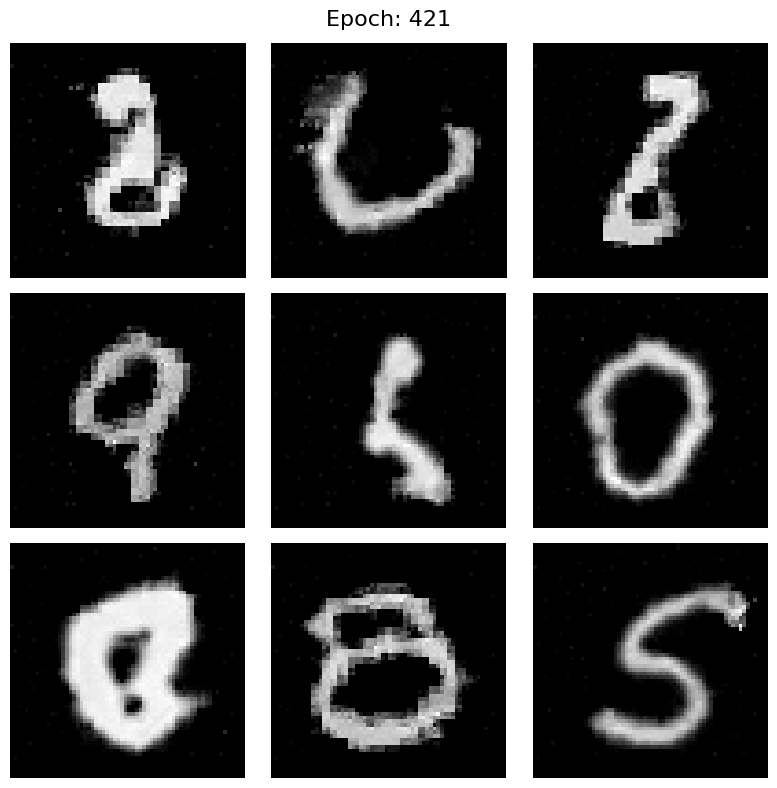

Epoch: 422/1000, d_loss: -0.7986, g_loss: 0.4044, time: 14.8833 sec


Epoch: 423/1000, d_loss: -0.7985, g_loss: 0.4129, time: 14.8469 sec


Epoch: 424/1000, d_loss: -0.7968, g_loss: 0.4037, time: 14.7878 sec


Epoch: 425/1000, d_loss: -0.7971, g_loss: 0.4102, time: 14.7534 sec


Epoch: 426/1000, d_loss: -0.8049, g_loss: 0.4110, time: 14.7844 sec


Epoch: 427/1000, d_loss: -0.8051, g_loss: 0.4141, time: 14.7921 sec


Epoch: 428/1000, d_loss: -0.8050, g_loss: 0.4099, time: 14.6600 sec


Epoch: 429/1000, d_loss: -0.8056, g_loss: 0.4173, time: 14.8017 sec


Epoch: 430/1000, d_loss: -0.8094, g_loss: 0.4122, time: 14.8978 sec


Epoch: 431/1000, d_loss: -0.8128, g_loss: 0.4176, time: 14.9097 sec


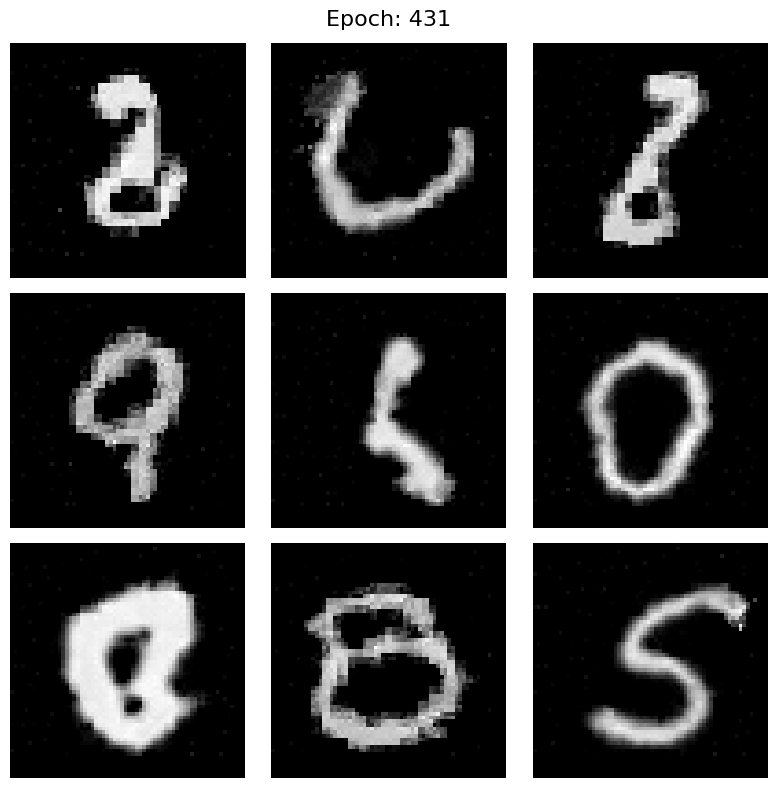

Epoch: 432/1000, d_loss: -0.8112, g_loss: 0.4107, time: 14.7363 sec


Epoch: 433/1000, d_loss: -0.8170, g_loss: 0.4172, time: 14.7326 sec


Epoch: 434/1000, d_loss: -0.8167, g_loss: 0.4213, time: 14.7254 sec


Epoch: 435/1000, d_loss: -0.8130, g_loss: 0.4129, time: 14.7778 sec


Epoch: 436/1000, d_loss: -0.8157, g_loss: 0.4223, time: 14.8719 sec


Epoch: 437/1000, d_loss: -0.8175, g_loss: 0.4157, time: 14.7290 sec


Epoch: 438/1000, d_loss: -0.8193, g_loss: 0.4223, time: 14.8877 sec


Epoch: 439/1000, d_loss: -0.8213, g_loss: 0.4202, time: 14.7917 sec


Epoch: 440/1000, d_loss: -0.8229, g_loss: 0.4260, time: 14.8287 sec


Epoch: 441/1000, d_loss: -0.8280, g_loss: 0.4197, time: 14.6766 sec


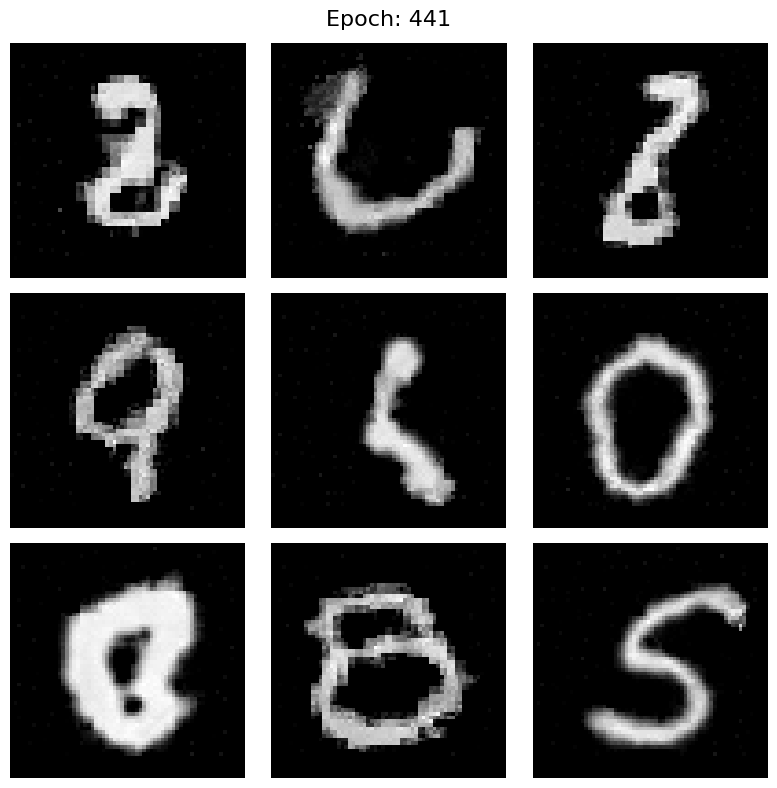

Epoch: 442/1000, d_loss: -0.8298, g_loss: 0.4273, time: 14.7592 sec


Epoch: 443/1000, d_loss: -0.8258, g_loss: 0.4195, time: 14.8228 sec


Epoch: 444/1000, d_loss: -0.8260, g_loss: 0.4261, time: 14.6942 sec


Epoch: 445/1000, d_loss: -0.8261, g_loss: 0.4197, time: 14.7696 sec


Epoch: 446/1000, d_loss: -0.8238, g_loss: 0.4244, time: 14.7575 sec


Epoch: 447/1000, d_loss: -0.8295, g_loss: 0.4196, time: 14.7433 sec


Epoch: 448/1000, d_loss: -0.8340, g_loss: 0.4255, time: 14.8144 sec


Epoch: 449/1000, d_loss: -0.8311, g_loss: 0.4301, time: 14.8339 sec


Epoch: 450/1000, d_loss: -0.8309, g_loss: 0.4238, time: 14.6356 sec


Epoch: 451/1000, d_loss: -0.8336, g_loss: 0.4309, time: 14.7411 sec


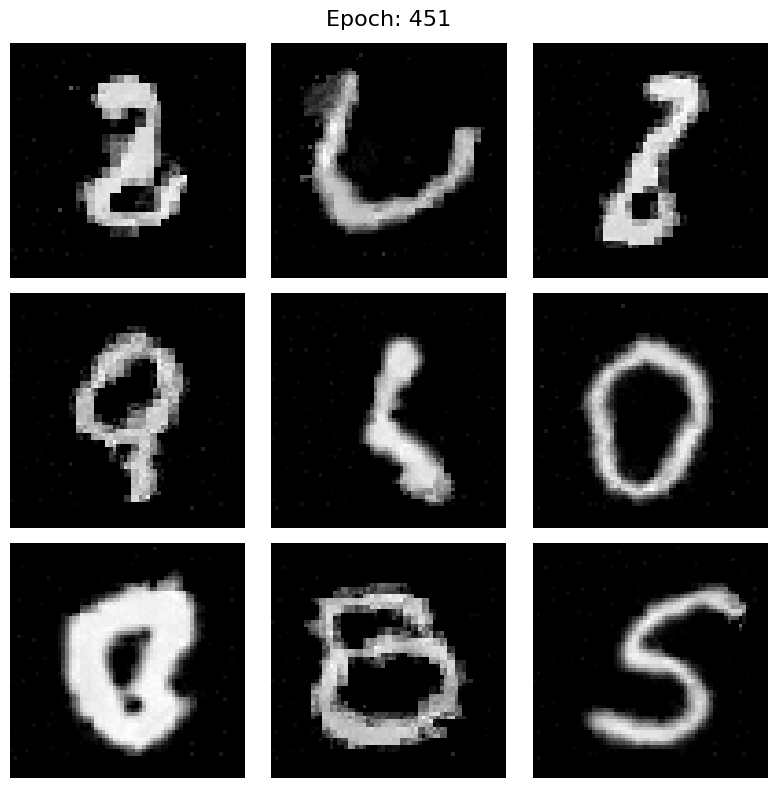

Epoch: 452/1000, d_loss: -0.8356, g_loss: 0.4267, time: 14.7237 sec


Epoch: 453/1000, d_loss: -0.8366, g_loss: 0.4342, time: 14.7804 sec


Epoch: 454/1000, d_loss: -0.8386, g_loss: 0.4264, time: 14.6740 sec


Epoch: 455/1000, d_loss: -0.8449, g_loss: 0.4400, time: 14.7492 sec


Epoch: 456/1000, d_loss: -0.8407, g_loss: 0.4284, time: 14.7568 sec


Epoch: 457/1000, d_loss: -0.8392, g_loss: 0.4359, time: 14.7572 sec


Epoch: 458/1000, d_loss: -0.8313, g_loss: 0.4261, time: 14.7775 sec


Epoch: 459/1000, d_loss: -0.8368, g_loss: 0.4365, time: 14.8074 sec


Epoch: 460/1000, d_loss: -0.8388, g_loss: 0.4294, time: 14.7936 sec


Epoch: 461/1000, d_loss: -0.8446, g_loss: 0.4420, time: 14.7772 sec


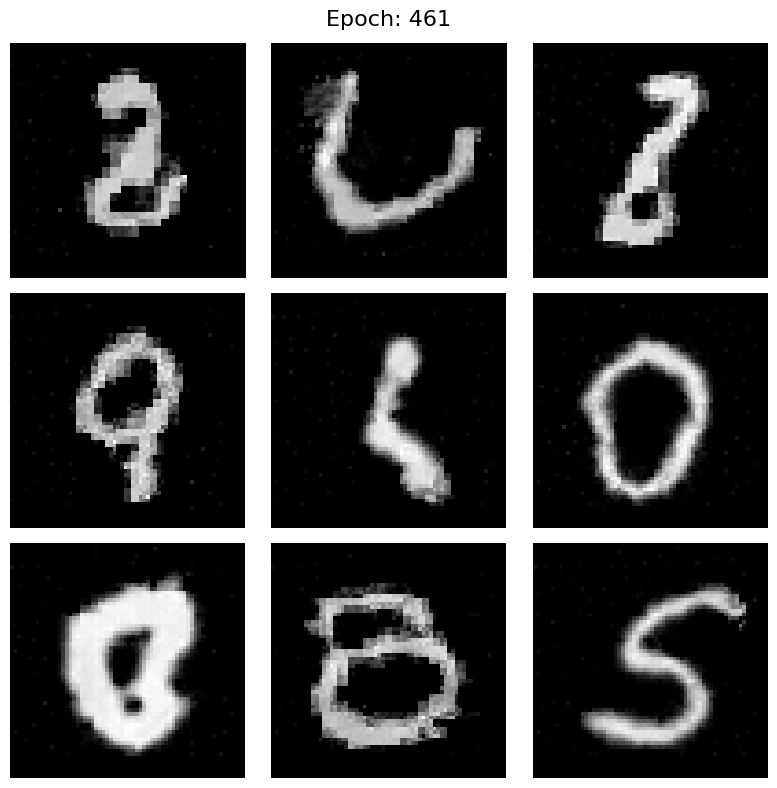

Epoch: 462/1000, d_loss: -0.8434, g_loss: 0.4400, time: 14.8024 sec


Epoch: 463/1000, d_loss: -0.8441, g_loss: 0.4352, time: 14.7399 sec


Epoch: 464/1000, d_loss: -0.8437, g_loss: 0.4417, time: 14.7374 sec


Epoch: 465/1000, d_loss: -0.8462, g_loss: 0.4380, time: 14.7343 sec


Epoch: 466/1000, d_loss: -0.8464, g_loss: 0.4427, time: 14.7077 sec


Epoch: 467/1000, d_loss: -0.8488, g_loss: 0.4425, time: 14.6760 sec


Epoch: 468/1000, d_loss: -0.8479, g_loss: 0.4490, time: 14.6885 sec


Epoch: 469/1000, d_loss: -0.8497, g_loss: 0.4442, time: 14.7750 sec


Epoch: 470/1000, d_loss: -0.8540, g_loss: 0.4538, time: 14.6674 sec


Epoch: 471/1000, d_loss: -0.8537, g_loss: 0.4492, time: 14.7865 sec


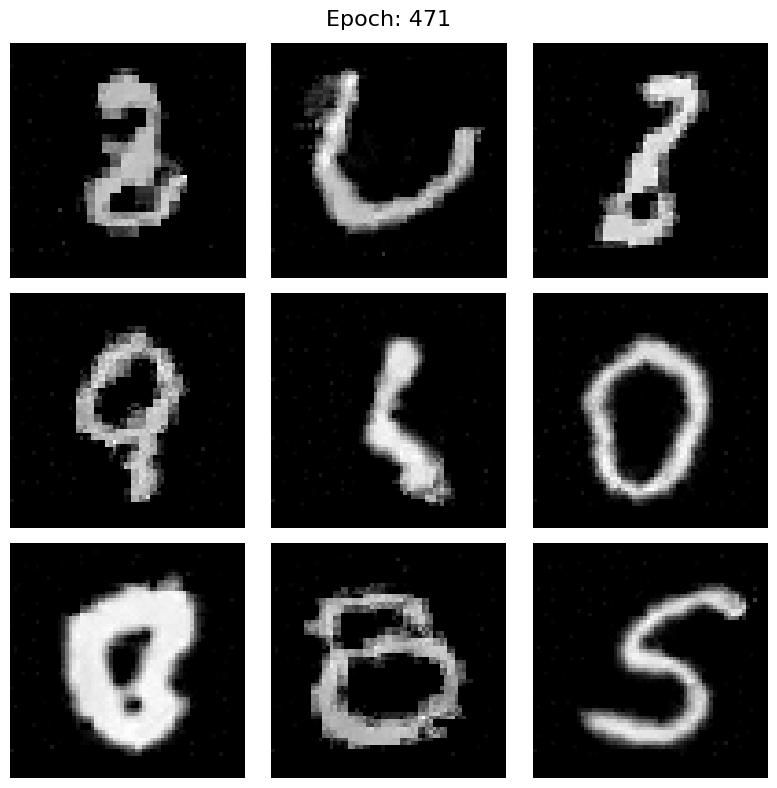

Epoch: 472/1000, d_loss: -0.8525, g_loss: 0.4569, time: 14.8085 sec


Epoch: 473/1000, d_loss: -0.8600, g_loss: 0.4557, time: 14.6651 sec


Epoch: 474/1000, d_loss: -0.8591, g_loss: 0.4617, time: 14.7774 sec


Epoch: 475/1000, d_loss: -0.8616, g_loss: 0.4582, time: 14.7741 sec


Epoch: 476/1000, d_loss: -0.8630, g_loss: 0.4599, time: 14.8272 sec


Epoch: 477/1000, d_loss: -0.8635, g_loss: 0.4668, time: 14.8096 sec


Epoch: 478/1000, d_loss: -0.8686, g_loss: 0.4640, time: 14.8331 sec


Epoch: 479/1000, d_loss: -0.8665, g_loss: 0.4684, time: 14.7731 sec


Epoch: 480/1000, d_loss: -0.8663, g_loss: 0.4621, time: 14.6603 sec


Epoch: 481/1000, d_loss: -0.8677, g_loss: 0.4690, time: 14.8379 sec


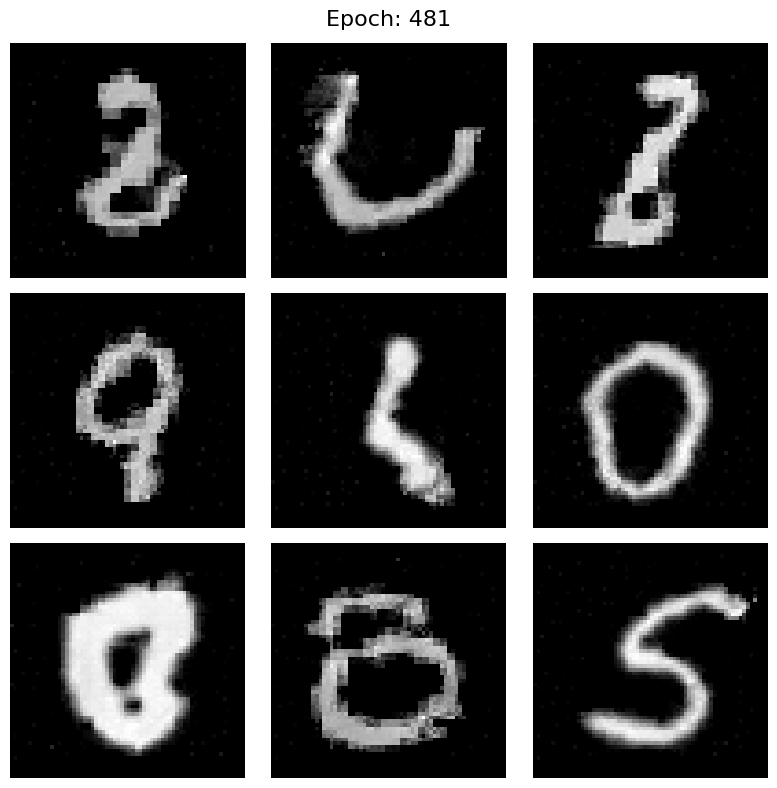

Epoch: 482/1000, d_loss: -0.8692, g_loss: 0.4614, time: 14.9024 sec


Epoch: 483/1000, d_loss: -0.8705, g_loss: 0.4662, time: 14.8297 sec


Epoch: 484/1000, d_loss: -0.8685, g_loss: 0.4601, time: 14.8275 sec


Epoch: 485/1000, d_loss: -0.8681, g_loss: 0.4656, time: 14.6779 sec


Epoch: 486/1000, d_loss: -0.8761, g_loss: 0.4593, time: 14.7391 sec


Epoch: 487/1000, d_loss: -0.8762, g_loss: 0.4633, time: 14.8020 sec


Epoch: 488/1000, d_loss: -0.8807, g_loss: 0.4591, time: 14.6701 sec


Epoch: 489/1000, d_loss: -0.8783, g_loss: 0.4585, time: 14.7726 sec


Epoch: 490/1000, d_loss: -0.8825, g_loss: 0.4578, time: 14.7187 sec


Epoch: 491/1000, d_loss: -0.8880, g_loss: 0.4613, time: 14.6558 sec


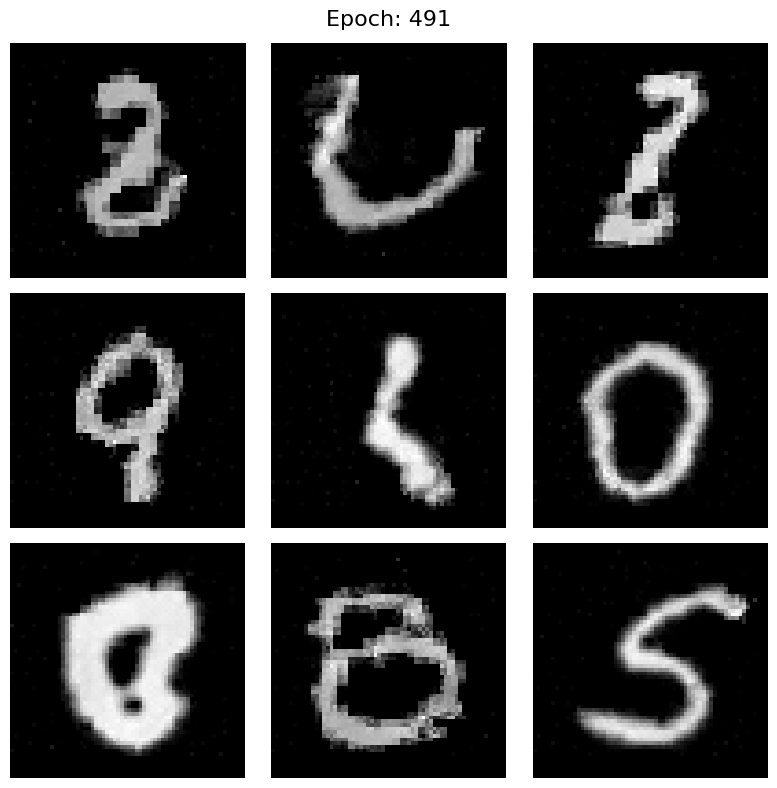

Epoch: 492/1000, d_loss: -0.8924, g_loss: 0.4659, time: 14.8210 sec


Epoch: 493/1000, d_loss: -0.8919, g_loss: 0.4589, time: 14.8563 sec


Epoch: 494/1000, d_loss: -0.8798, g_loss: 0.4588, time: 14.6973 sec


Epoch: 495/1000, d_loss: -0.8741, g_loss: 0.4489, time: 14.7316 sec


Epoch: 496/1000, d_loss: -0.8804, g_loss: 0.4582, time: 14.6887 sec


Epoch: 497/1000, d_loss: -0.8886, g_loss: 0.4584, time: 14.6999 sec


Epoch: 498/1000, d_loss: -0.8827, g_loss: 0.4594, time: 14.8138 sec


Epoch: 499/1000, d_loss: -0.8850, g_loss: 0.4561, time: 14.7424 sec


Epoch: 500/1000, d_loss: -0.8874, g_loss: 0.4627, time: 14.7349 sec


Epoch: 501/1000, d_loss: -0.8901, g_loss: 0.4567, time: 14.7072 sec


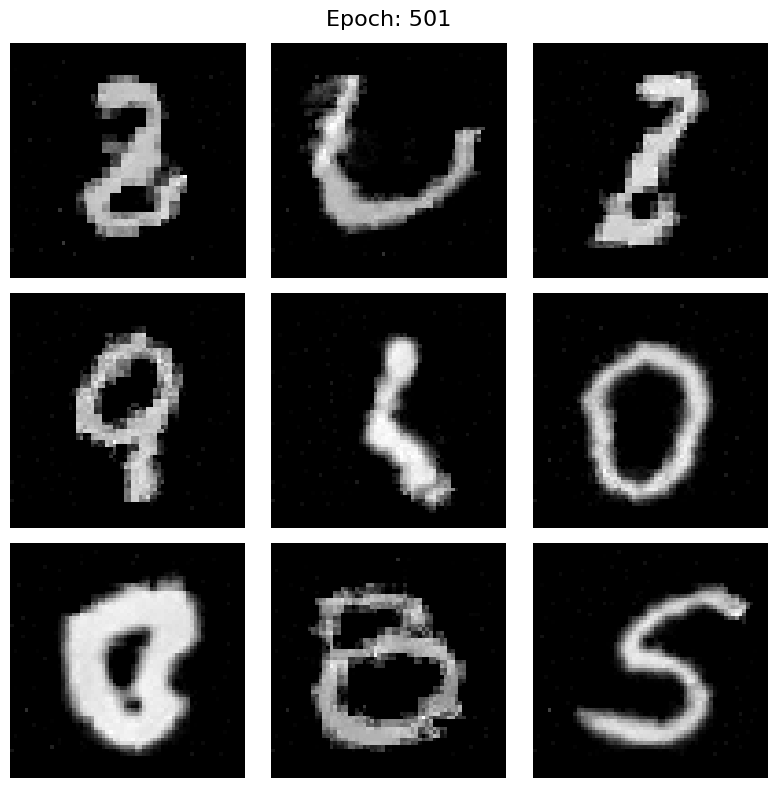

Epoch: 502/1000, d_loss: -0.8913, g_loss: 0.4642, time: 14.7959 sec


Epoch: 503/1000, d_loss: -0.8940, g_loss: 0.4571, time: 14.6746 sec


Epoch: 504/1000, d_loss: -0.8988, g_loss: 0.4687, time: 14.8165 sec


Epoch: 505/1000, d_loss: -0.9007, g_loss: 0.4637, time: 14.7883 sec


Epoch: 506/1000, d_loss: -0.9027, g_loss: 0.4656, time: 14.8416 sec


Epoch: 507/1000, d_loss: -0.9027, g_loss: 0.4710, time: 14.9264 sec


Epoch: 508/1000, d_loss: -0.9020, g_loss: 0.4623, time: 14.7394 sec


Epoch: 509/1000, d_loss: -0.9045, g_loss: 0.4710, time: 14.7957 sec


Epoch: 510/1000, d_loss: -0.9040, g_loss: 0.4648, time: 14.8001 sec


Epoch: 511/1000, d_loss: -0.9004, g_loss: 0.4687, time: 14.7809 sec


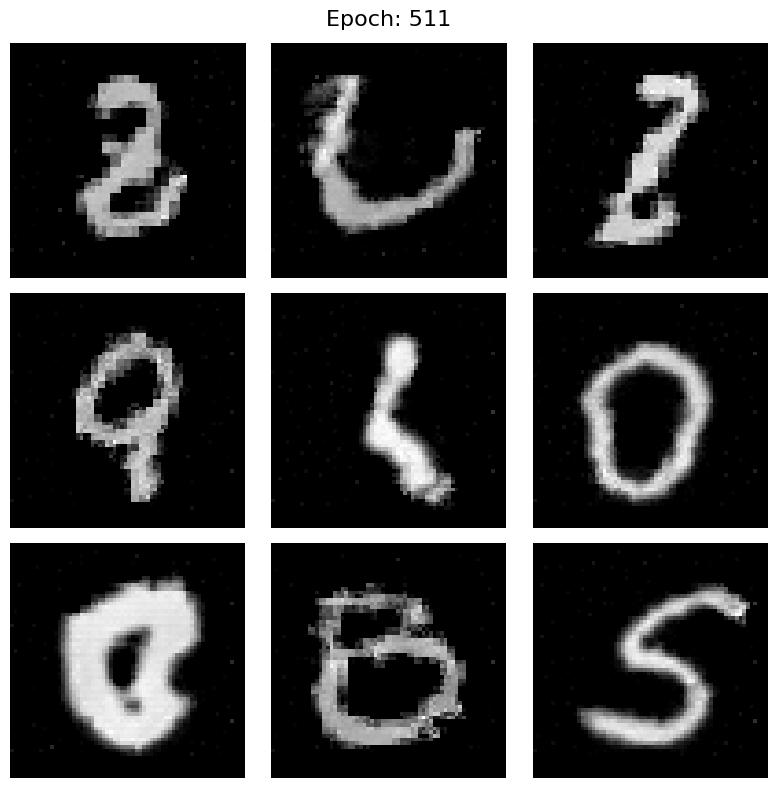

Epoch: 512/1000, d_loss: -0.9015, g_loss: 0.4647, time: 14.8754 sec


Epoch: 513/1000, d_loss: -0.9077, g_loss: 0.4728, time: 14.7586 sec


Epoch: 514/1000, d_loss: -0.9067, g_loss: 0.4667, time: 14.6557 sec


Epoch: 515/1000, d_loss: -0.9099, g_loss: 0.4752, time: 14.7690 sec


Epoch: 516/1000, d_loss: -0.9144, g_loss: 0.4740, time: 14.7580 sec


Epoch: 517/1000, d_loss: -0.9158, g_loss: 0.4771, time: 14.8545 sec


Epoch: 518/1000, d_loss: -0.9180, g_loss: 0.4726, time: 14.8653 sec


Epoch: 519/1000, d_loss: -0.9103, g_loss: 0.4755, time: 14.8744 sec


Epoch: 520/1000, d_loss: -0.9042, g_loss: 0.4728, time: 14.7552 sec


Epoch: 521/1000, d_loss: -0.9038, g_loss: 0.4652, time: 14.8102 sec


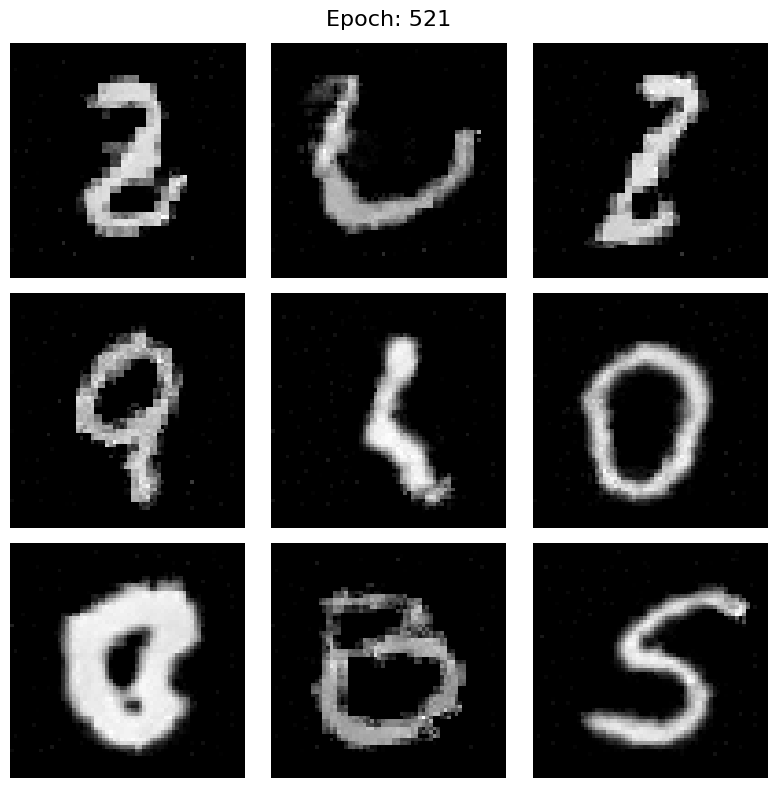

Epoch: 522/1000, d_loss: -0.9147, g_loss: 0.4790, time: 14.8843 sec


Epoch: 523/1000, d_loss: -0.9161, g_loss: 0.4737, time: 14.7765 sec


Epoch: 524/1000, d_loss: -0.9154, g_loss: 0.4750, time: 14.7658 sec


Epoch: 525/1000, d_loss: -0.9160, g_loss: 0.4719, time: 14.7286 sec


Epoch: 526/1000, d_loss: -0.9176, g_loss: 0.4793, time: 14.8530 sec


Epoch: 527/1000, d_loss: -0.9179, g_loss: 0.4723, time: 14.6509 sec


Epoch: 528/1000, d_loss: -0.9138, g_loss: 0.4743, time: 14.7129 sec


Epoch: 529/1000, d_loss: -0.9032, g_loss: 0.4647, time: 14.7175 sec


Epoch: 530/1000, d_loss: -0.9113, g_loss: 0.4750, time: 14.7881 sec


Epoch: 531/1000, d_loss: -0.9154, g_loss: 0.4723, time: 14.7340 sec


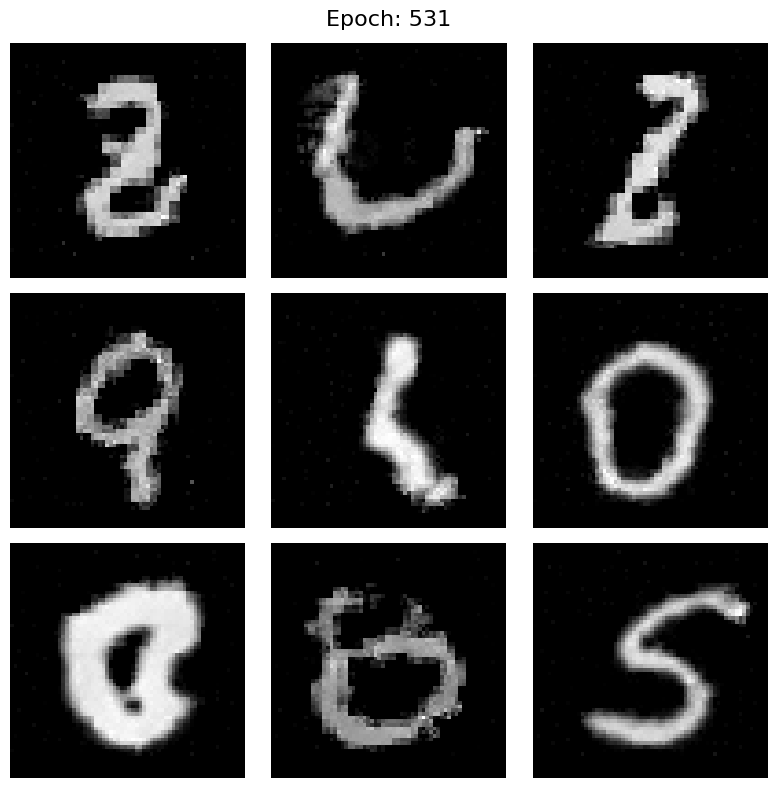

Epoch: 532/1000, d_loss: -0.9179, g_loss: 0.4770, time: 14.7520 sec


Epoch: 533/1000, d_loss: -0.9181, g_loss: 0.4723, time: 14.7726 sec


Epoch: 534/1000, d_loss: -0.9215, g_loss: 0.4760, time: 14.7341 sec


Epoch: 535/1000, d_loss: -0.9189, g_loss: 0.4782, time: 14.7938 sec


Epoch: 536/1000, d_loss: -0.9231, g_loss: 0.4766, time: 14.7995 sec


Epoch: 537/1000, d_loss: -0.9216, g_loss: 0.4779, time: 14.6951 sec


Epoch: 538/1000, d_loss: -0.9212, g_loss: 0.4721, time: 14.8255 sec


Epoch: 539/1000, d_loss: -0.9261, g_loss: 0.4808, time: 14.7572 sec


Epoch: 540/1000, d_loss: -0.9312, g_loss: 0.4807, time: 14.7318 sec


Epoch: 541/1000, d_loss: -0.9290, g_loss: 0.4824, time: 14.7798 sec


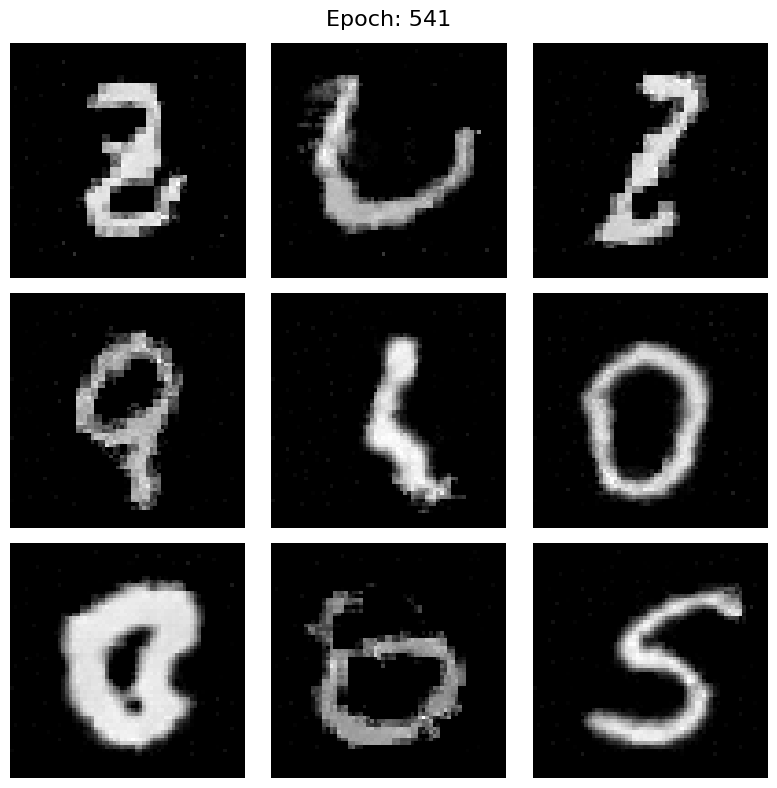

Epoch: 542/1000, d_loss: -0.9321, g_loss: 0.4801, time: 15.0123 sec


Epoch: 543/1000, d_loss: -0.9305, g_loss: 0.4819, time: 14.8652 sec


Epoch: 544/1000, d_loss: -0.9267, g_loss: 0.4754, time: 14.7268 sec


Epoch: 545/1000, d_loss: -0.9273, g_loss: 0.4808, time: 14.8406 sec


Epoch: 546/1000, d_loss: -0.9286, g_loss: 0.4764, time: 14.7869 sec


Epoch: 547/1000, d_loss: -0.9345, g_loss: 0.4839, time: 14.6269 sec


Epoch: 548/1000, d_loss: -0.9407, g_loss: 0.4879, time: 14.6555 sec


Epoch: 549/1000, d_loss: -0.9382, g_loss: 0.4822, time: 14.8501 sec


Epoch: 550/1000, d_loss: -0.9374, g_loss: 0.4860, time: 14.8316 sec


Epoch: 551/1000, d_loss: -0.9430, g_loss: 0.4834, time: 14.7865 sec


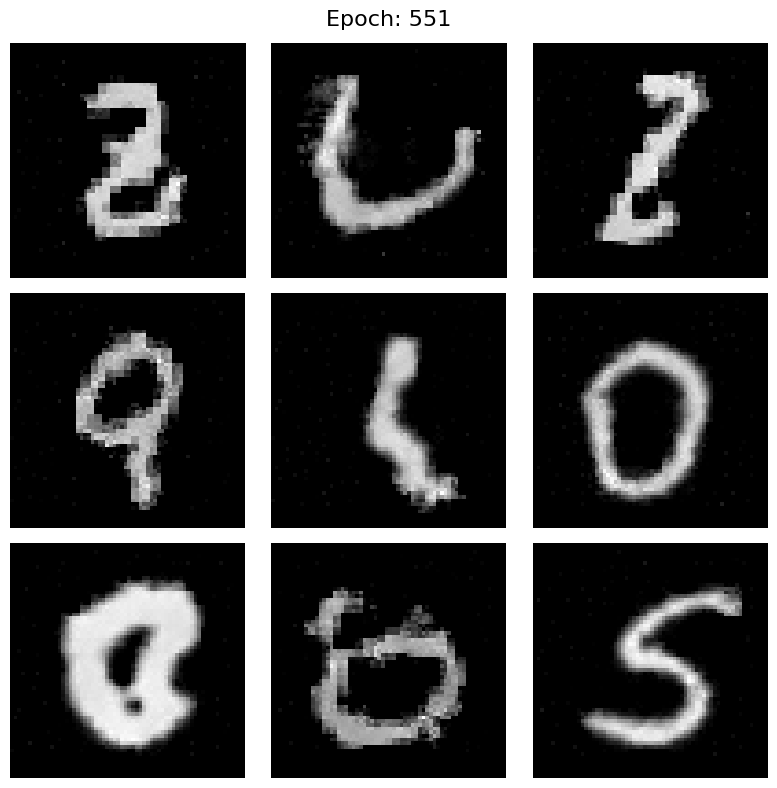

Epoch: 552/1000, d_loss: -0.9425, g_loss: 0.4867, time: 14.7205 sec


Epoch: 553/1000, d_loss: -0.9455, g_loss: 0.4820, time: 14.6341 sec


Epoch: 554/1000, d_loss: -0.9476, g_loss: 0.4888, time: 14.8820 sec


Epoch: 555/1000, d_loss: -0.9462, g_loss: 0.4831, time: 14.7499 sec


Epoch: 556/1000, d_loss: -0.9462, g_loss: 0.4855, time: 14.7872 sec


Epoch: 557/1000, d_loss: -0.9483, g_loss: 0.4854, time: 14.8245 sec


Epoch: 558/1000, d_loss: -0.9515, g_loss: 0.4905, time: 14.8142 sec


Epoch: 559/1000, d_loss: -0.9530, g_loss: 0.4852, time: 14.6753 sec


Epoch: 560/1000, d_loss: -0.9540, g_loss: 0.4919, time: 14.8152 sec


Epoch: 561/1000, d_loss: -0.9546, g_loss: 0.4863, time: 14.6953 sec


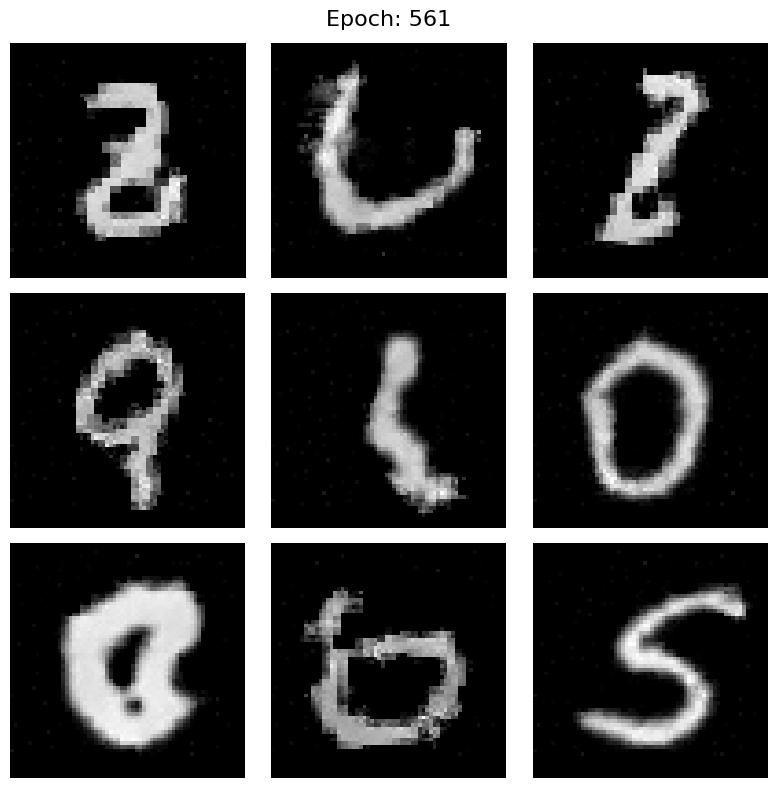

Epoch: 562/1000, d_loss: -0.9554, g_loss: 0.4873, time: 14.7574 sec


Epoch: 563/1000, d_loss: -0.9510, g_loss: 0.4906, time: 14.7530 sec


Epoch: 564/1000, d_loss: -0.9522, g_loss: 0.4847, time: 14.6743 sec


Epoch: 565/1000, d_loss: -0.9599, g_loss: 0.4918, time: 14.7420 sec


Epoch: 566/1000, d_loss: -0.9638, g_loss: 0.4993, time: 14.7639 sec


Epoch: 567/1000, d_loss: -0.9619, g_loss: 0.4915, time: 14.7378 sec


Epoch: 568/1000, d_loss: -0.9635, g_loss: 0.4985, time: 14.7643 sec


Epoch: 569/1000, d_loss: -0.9610, g_loss: 0.4910, time: 14.7671 sec


Epoch: 570/1000, d_loss: -0.9590, g_loss: 0.4957, time: 14.7204 sec


Epoch: 571/1000, d_loss: -0.9560, g_loss: 0.4872, time: 14.7463 sec


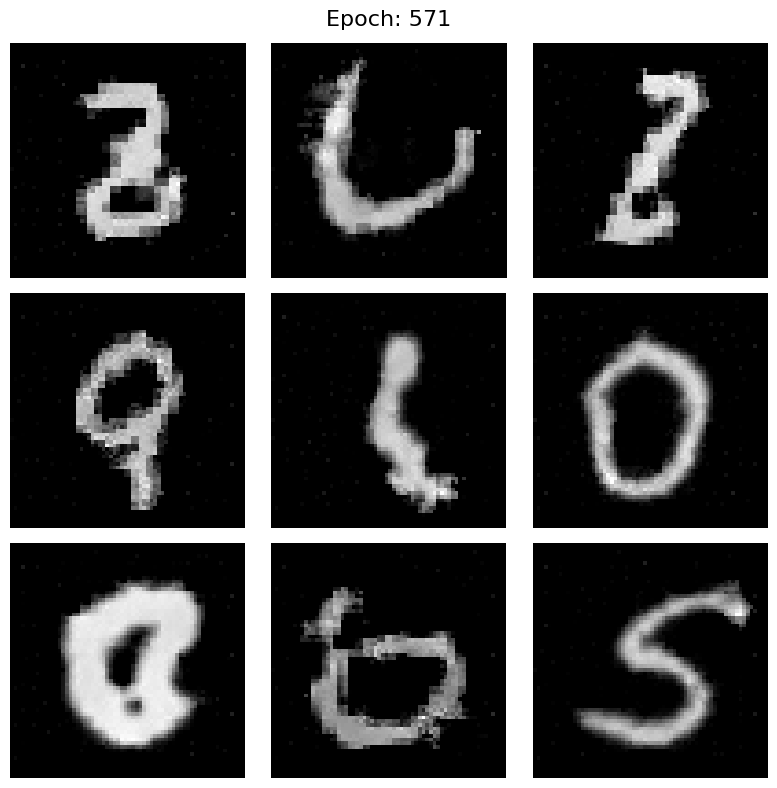

Epoch: 572/1000, d_loss: -0.9588, g_loss: 0.4945, time: 14.7626 sec


Epoch: 573/1000, d_loss: -0.9595, g_loss: 0.4909, time: 14.6989 sec


Epoch: 574/1000, d_loss: -0.9614, g_loss: 0.4956, time: 14.6442 sec


Epoch: 575/1000, d_loss: -0.9635, g_loss: 0.4892, time: 14.6690 sec


Epoch: 576/1000, d_loss: -0.9674, g_loss: 0.4997, time: 14.7706 sec


Epoch: 577/1000, d_loss: -0.9703, g_loss: 0.4945, time: 14.6600 sec


Epoch: 578/1000, d_loss: -0.9670, g_loss: 0.4926, time: 14.7901 sec


Epoch: 579/1000, d_loss: -0.9677, g_loss: 0.4983, time: 14.8064 sec


Epoch: 580/1000, d_loss: -0.9676, g_loss: 0.4925, time: 14.7636 sec


Epoch: 581/1000, d_loss: -0.9737, g_loss: 0.5031, time: 14.7633 sec


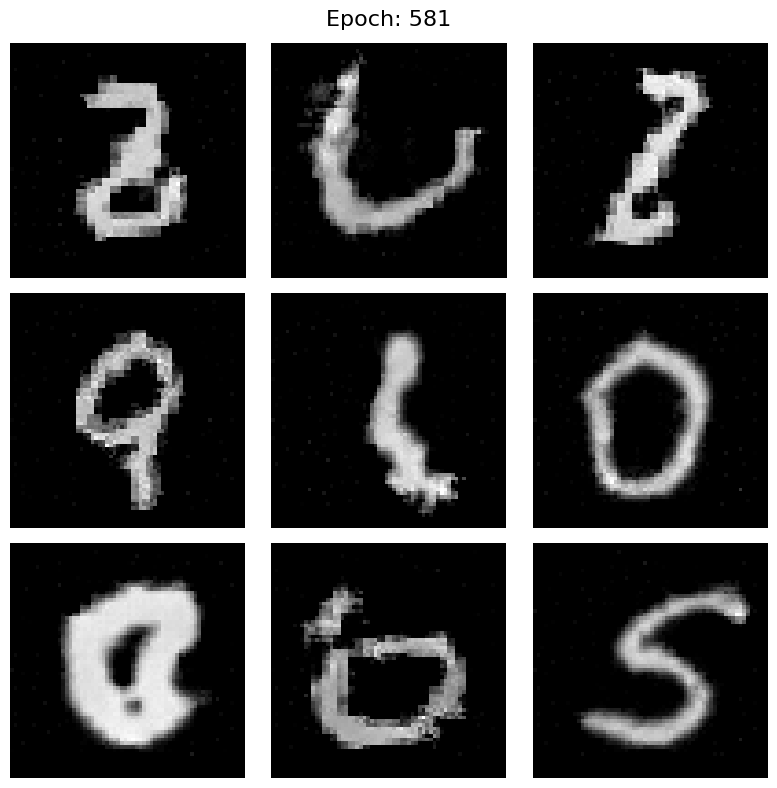

Epoch: 582/1000, d_loss: -0.9746, g_loss: 0.4980, time: 14.8178 sec


Epoch: 583/1000, d_loss: -0.9763, g_loss: 0.5023, time: 14.7344 sec


Epoch: 584/1000, d_loss: -0.9758, g_loss: 0.4983, time: 14.7634 sec


Epoch: 585/1000, d_loss: -0.9766, g_loss: 0.5044, time: 14.6355 sec


Epoch: 586/1000, d_loss: -0.9794, g_loss: 0.4970, time: 14.7956 sec


Epoch: 587/1000, d_loss: -0.9805, g_loss: 0.5039, time: 14.6851 sec


Epoch: 588/1000, d_loss: -0.9817, g_loss: 0.5010, time: 14.7065 sec


Epoch: 589/1000, d_loss: -0.9799, g_loss: 0.5024, time: 14.8196 sec


Epoch: 590/1000, d_loss: -0.9815, g_loss: 0.5030, time: 14.6975 sec


Epoch: 591/1000, d_loss: -0.9802, g_loss: 0.5004, time: 14.6089 sec


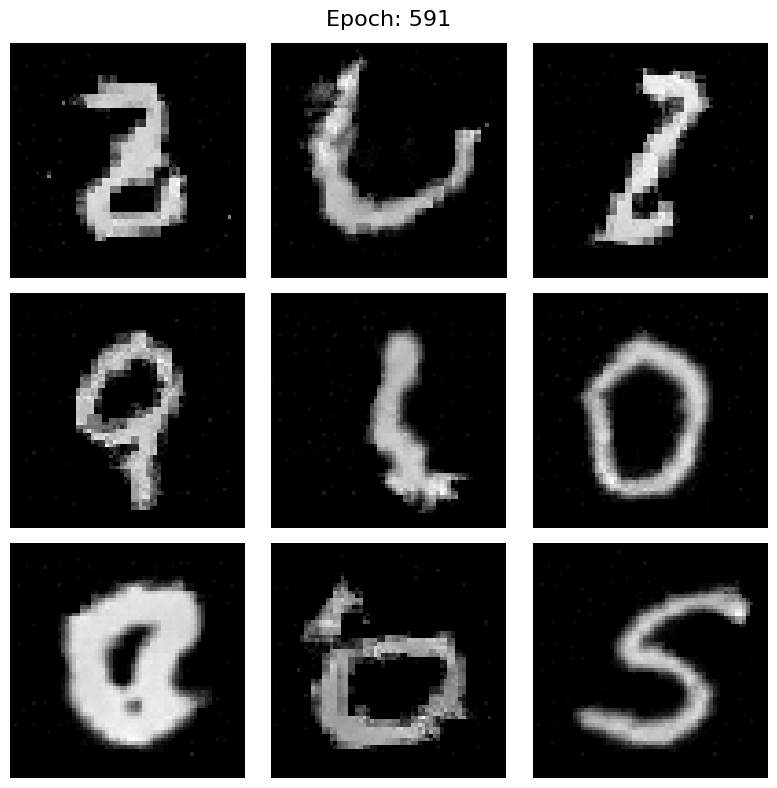

Epoch: 592/1000, d_loss: -0.9768, g_loss: 0.5047, time: 14.8598 sec


Epoch: 593/1000, d_loss: -0.9739, g_loss: 0.4968, time: 14.7212 sec


Epoch: 594/1000, d_loss: -0.9765, g_loss: 0.5034, time: 14.6645 sec


Epoch: 595/1000, d_loss: -0.9822, g_loss: 0.4993, time: 14.6663 sec


Epoch: 596/1000, d_loss: -0.9845, g_loss: 0.5085, time: 14.7573 sec


Epoch: 597/1000, d_loss: -0.9831, g_loss: 0.5007, time: 14.6892 sec


Epoch: 598/1000, d_loss: -0.9840, g_loss: 0.5056, time: 14.8211 sec


Epoch: 599/1000, d_loss: -0.9846, g_loss: 0.5044, time: 14.8236 sec


Epoch: 600/1000, d_loss: -0.9815, g_loss: 0.5061, time: 14.7230 sec


Epoch: 601/1000, d_loss: -0.9851, g_loss: 0.5032, time: 14.6901 sec


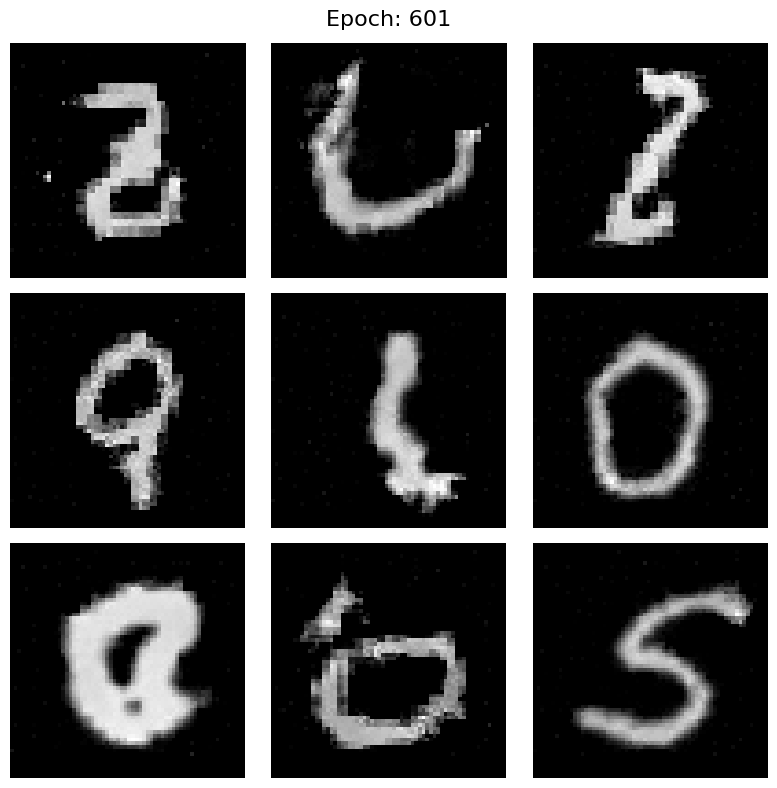

Epoch: 602/1000, d_loss: -0.9878, g_loss: 0.5079, time: 14.8067 sec


Epoch: 603/1000, d_loss: -0.9926, g_loss: 0.5081, time: 14.6346 sec


Epoch: 604/1000, d_loss: -0.9920, g_loss: 0.5106, time: 14.6362 sec


Epoch: 605/1000, d_loss: -0.9937, g_loss: 0.5076, time: 14.7878 sec


Epoch: 606/1000, d_loss: -0.9910, g_loss: 0.5048, time: 14.6971 sec


Epoch: 607/1000, d_loss: -0.9913, g_loss: 0.5109, time: 14.8383 sec


Epoch: 608/1000, d_loss: -0.9897, g_loss: 0.5069, time: 14.7052 sec


Epoch: 609/1000, d_loss: -0.9915, g_loss: 0.5107, time: 14.7339 sec


Epoch: 610/1000, d_loss: -0.9940, g_loss: 0.5081, time: 14.7130 sec


Epoch: 611/1000, d_loss: -0.9947, g_loss: 0.5140, time: 14.6508 sec


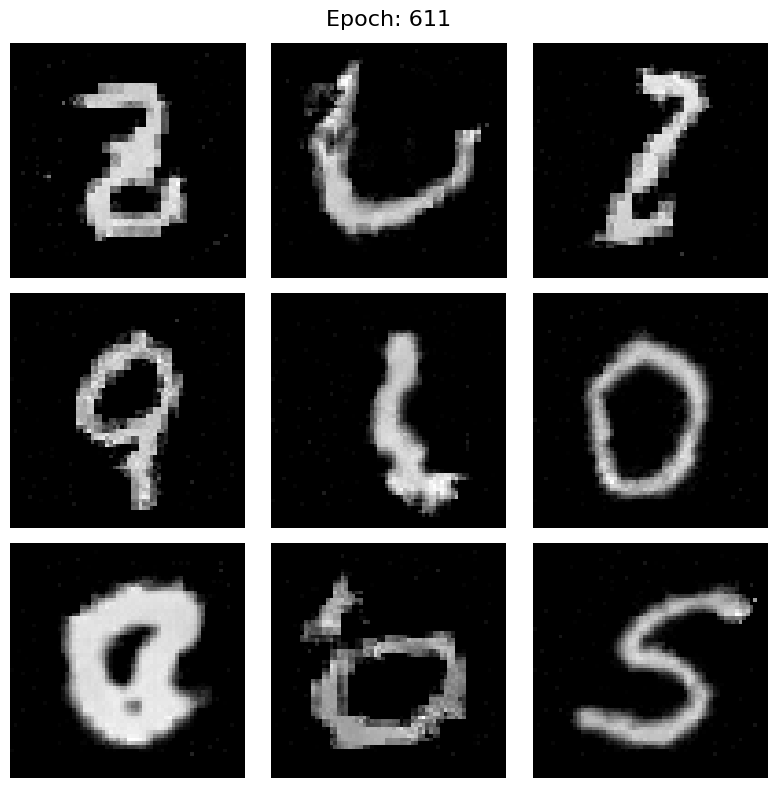

Epoch: 612/1000, d_loss: -0.9911, g_loss: 0.5053, time: 14.8489 sec


Epoch: 613/1000, d_loss: -0.9926, g_loss: 0.5111, time: 14.7937 sec


Epoch: 614/1000, d_loss: -0.9954, g_loss: 0.5073, time: 14.7256 sec


Epoch: 615/1000, d_loss: -0.9960, g_loss: 0.5125, time: 14.6948 sec


Epoch: 616/1000, d_loss: -0.9985, g_loss: 0.5098, time: 14.7293 sec


Epoch: 617/1000, d_loss: -0.9970, g_loss: 0.5125, time: 14.6911 sec


Epoch: 618/1000, d_loss: -0.9985, g_loss: 0.5070, time: 14.6895 sec


Epoch: 619/1000, d_loss: -1.0017, g_loss: 0.5170, time: 14.7148 sec


Epoch: 620/1000, d_loss: -1.0020, g_loss: 0.5119, time: 14.7206 sec


Epoch: 621/1000, d_loss: -1.0020, g_loss: 0.5074, time: 14.7849 sec


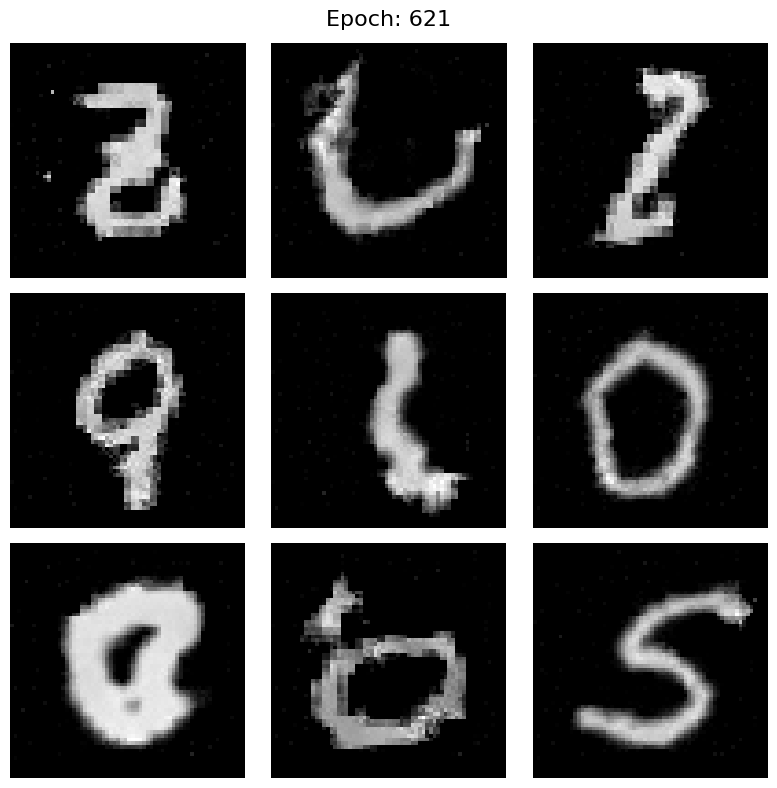

Epoch: 622/1000, d_loss: -1.0035, g_loss: 0.5148, time: 14.6932 sec


Epoch: 623/1000, d_loss: -1.0048, g_loss: 0.5140, time: 14.7055 sec


Epoch: 624/1000, d_loss: -1.0023, g_loss: 0.5152, time: 14.6480 sec


Epoch: 625/1000, d_loss: -1.0039, g_loss: 0.5077, time: 14.7082 sec


Epoch: 626/1000, d_loss: -1.0082, g_loss: 0.5152, time: 14.7302 sec


Epoch: 627/1000, d_loss: -1.0123, g_loss: 0.5157, time: 14.7100 sec


Epoch: 628/1000, d_loss: -1.0093, g_loss: 0.5176, time: 14.6795 sec


Epoch: 629/1000, d_loss: -1.0109, g_loss: 0.5136, time: 14.6479 sec


Epoch: 630/1000, d_loss: -1.0142, g_loss: 0.5219, time: 14.7786 sec


Epoch: 631/1000, d_loss: -1.0143, g_loss: 0.5177, time: 14.6751 sec


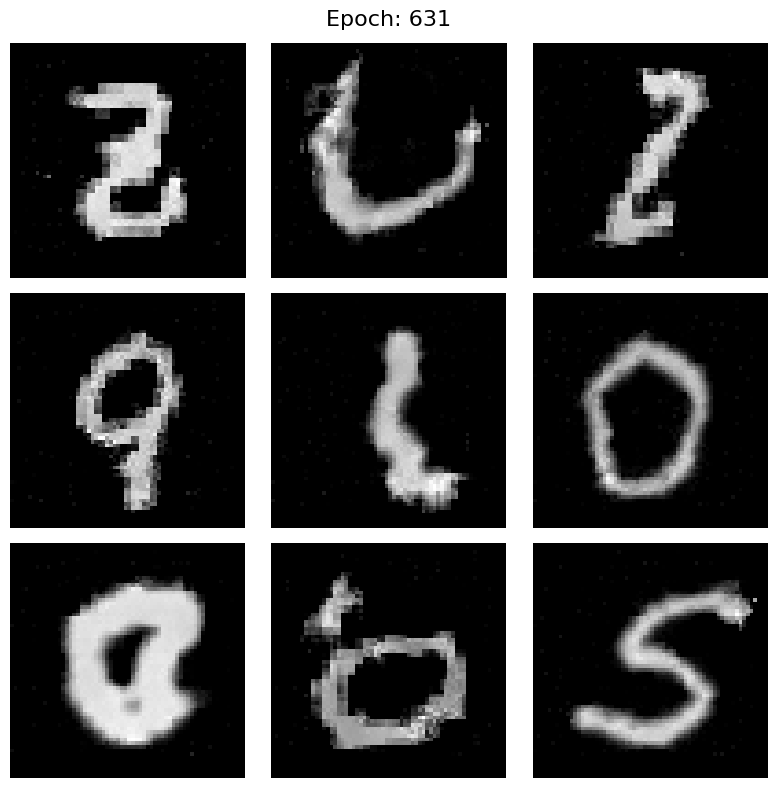

Epoch: 632/1000, d_loss: -1.0181, g_loss: 0.5243, time: 14.8112 sec


Epoch: 633/1000, d_loss: -1.0135, g_loss: 0.5146, time: 14.8155 sec


Epoch: 634/1000, d_loss: -1.0145, g_loss: 0.5150, time: 14.6715 sec


Epoch: 635/1000, d_loss: -1.0179, g_loss: 0.5241, time: 14.6368 sec


Epoch: 636/1000, d_loss: -1.0172, g_loss: 0.5183, time: 14.8177 sec


Epoch: 637/1000, d_loss: -1.0187, g_loss: 0.5221, time: 14.7014 sec


Epoch: 638/1000, d_loss: -1.0210, g_loss: 0.5197, time: 14.8078 sec


Epoch: 639/1000, d_loss: -1.0203, g_loss: 0.5220, time: 14.7109 sec


Epoch: 640/1000, d_loss: -1.0217, g_loss: 0.5200, time: 14.7656 sec


Epoch: 641/1000, d_loss: -1.0235, g_loss: 0.5253, time: 14.7536 sec


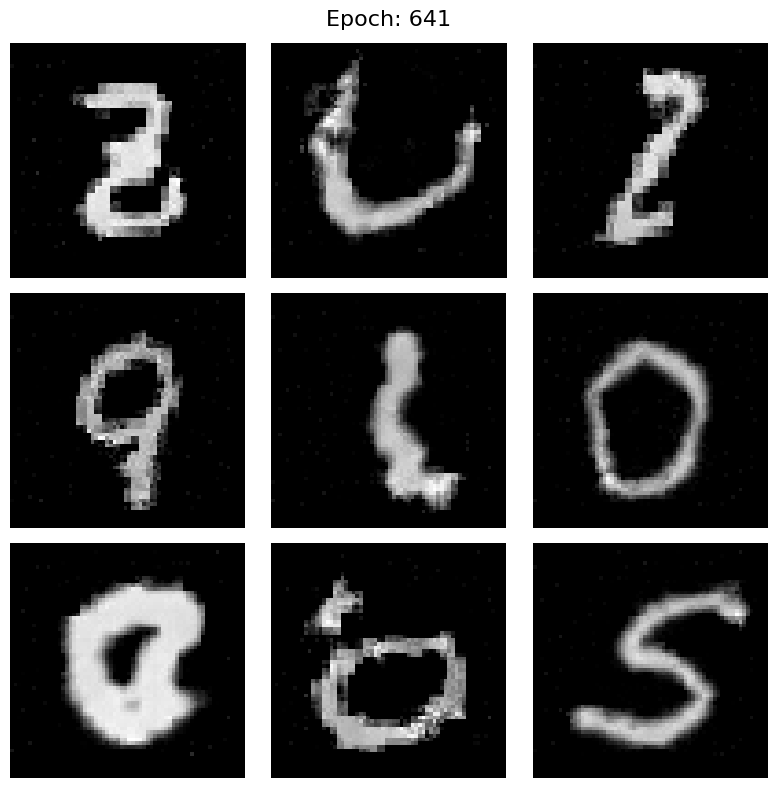

Epoch: 642/1000, d_loss: -1.0245, g_loss: 0.5206, time: 14.9453 sec


Epoch: 643/1000, d_loss: -1.0239, g_loss: 0.5262, time: 14.6816 sec


Epoch: 644/1000, d_loss: -1.0229, g_loss: 0.5216, time: 14.7572 sec


Epoch: 645/1000, d_loss: -1.0259, g_loss: 0.5250, time: 14.7901 sec


Epoch: 646/1000, d_loss: -1.0269, g_loss: 0.5232, time: 14.7367 sec


Epoch: 647/1000, d_loss: -1.0296, g_loss: 0.5291, time: 14.8229 sec


Epoch: 648/1000, d_loss: -1.0300, g_loss: 0.5241, time: 14.6627 sec


Epoch: 649/1000, d_loss: -1.0337, g_loss: 0.5236, time: 14.6654 sec


Epoch: 650/1000, d_loss: -1.0336, g_loss: 0.5302, time: 14.7620 sec


Epoch: 651/1000, d_loss: -1.0342, g_loss: 0.5249, time: 14.8209 sec


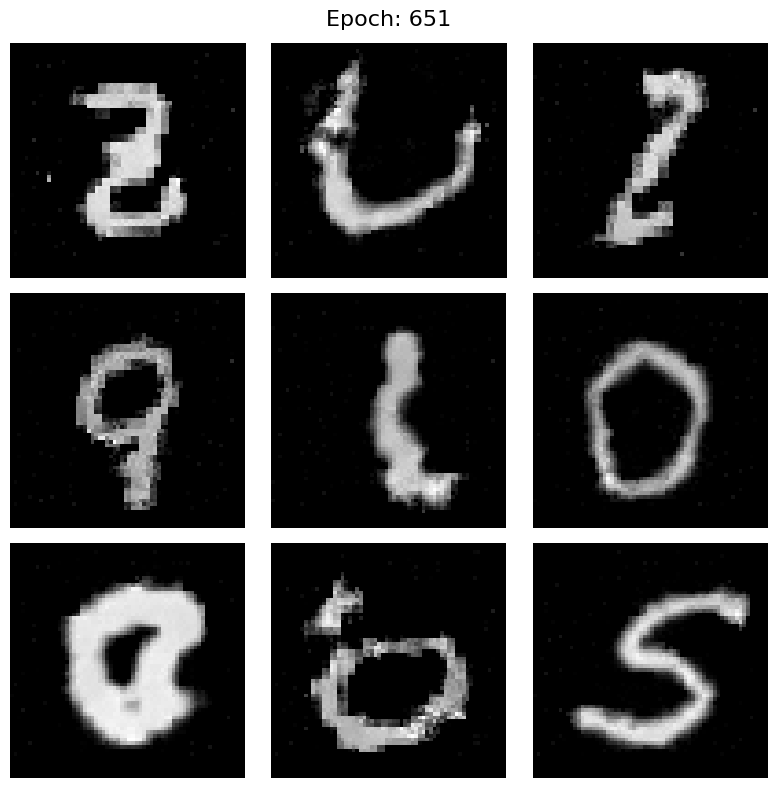

Epoch: 652/1000, d_loss: -1.0364, g_loss: 0.5325, time: 14.8542 sec


Epoch: 653/1000, d_loss: -1.0376, g_loss: 0.5268, time: 14.7252 sec


Epoch: 654/1000, d_loss: -1.0343, g_loss: 0.5314, time: 14.7024 sec


Epoch: 655/1000, d_loss: -1.0362, g_loss: 0.5291, time: 14.7381 sec


Epoch: 656/1000, d_loss: -1.0386, g_loss: 0.5338, time: 14.6753 sec


Epoch: 657/1000, d_loss: -1.0384, g_loss: 0.5289, time: 14.7619 sec


Epoch: 658/1000, d_loss: -1.0416, g_loss: 0.5293, time: 14.6948 sec


Epoch: 659/1000, d_loss: -1.0450, g_loss: 0.5267, time: 14.7429 sec


Epoch: 660/1000, d_loss: -1.0417, g_loss: 0.5331, time: 14.8624 sec


Epoch: 661/1000, d_loss: -1.0421, g_loss: 0.5301, time: 14.6763 sec


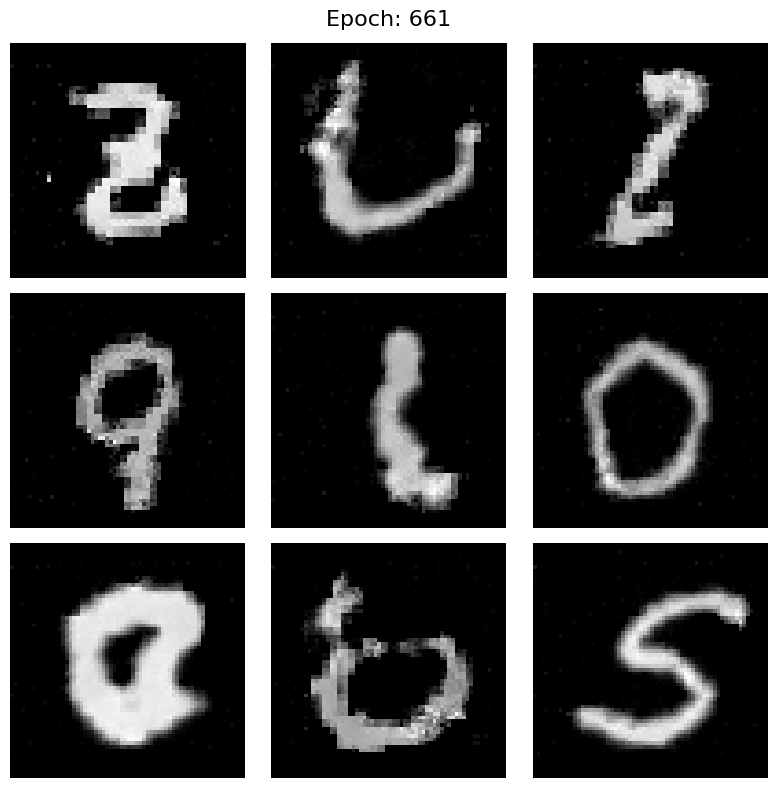

Epoch: 662/1000, d_loss: -1.0461, g_loss: 0.5340, time: 15.3891 sec


Epoch: 663/1000, d_loss: -1.0470, g_loss: 0.5349, time: 14.6985 sec


Epoch: 664/1000, d_loss: -1.0485, g_loss: 0.5322, time: 14.6958 sec


Epoch: 665/1000, d_loss: -1.0463, g_loss: 0.5362, time: 14.7690 sec


Epoch: 666/1000, d_loss: -1.0489, g_loss: 0.5326, time: 14.6778 sec


Epoch: 667/1000, d_loss: -1.0512, g_loss: 0.5395, time: 14.6576 sec


Epoch: 668/1000, d_loss: -1.0502, g_loss: 0.5311, time: 14.7441 sec


Epoch: 669/1000, d_loss: -1.0510, g_loss: 0.5373, time: 14.7239 sec


Epoch: 670/1000, d_loss: -1.0515, g_loss: 0.5327, time: 14.6603 sec


Epoch: 671/1000, d_loss: -1.0527, g_loss: 0.5392, time: 14.6154 sec


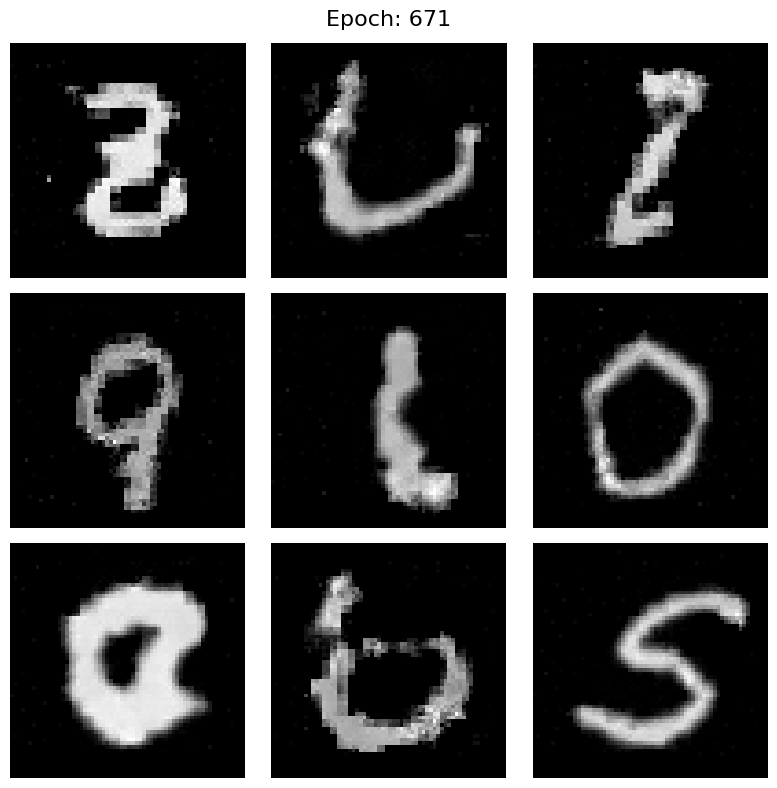

Epoch: 672/1000, d_loss: -1.0524, g_loss: 0.5354, time: 14.8288 sec


Epoch: 673/1000, d_loss: -1.0546, g_loss: 0.5377, time: 14.8311 sec


Epoch: 674/1000, d_loss: -1.0564, g_loss: 0.5360, time: 14.8156 sec


Epoch: 675/1000, d_loss: -1.0604, g_loss: 0.5421, time: 14.7610 sec


Epoch: 676/1000, d_loss: -1.0579, g_loss: 0.5377, time: 14.7320 sec


Epoch: 677/1000, d_loss: -1.0594, g_loss: 0.5380, time: 14.6913 sec


Epoch: 678/1000, d_loss: -1.0617, g_loss: 0.5419, time: 14.7166 sec


Epoch: 679/1000, d_loss: -1.0630, g_loss: 0.5400, time: 14.7880 sec


Epoch: 680/1000, d_loss: -1.0621, g_loss: 0.5408, time: 14.7908 sec


Epoch: 681/1000, d_loss: -1.0632, g_loss: 0.5402, time: 14.8131 sec


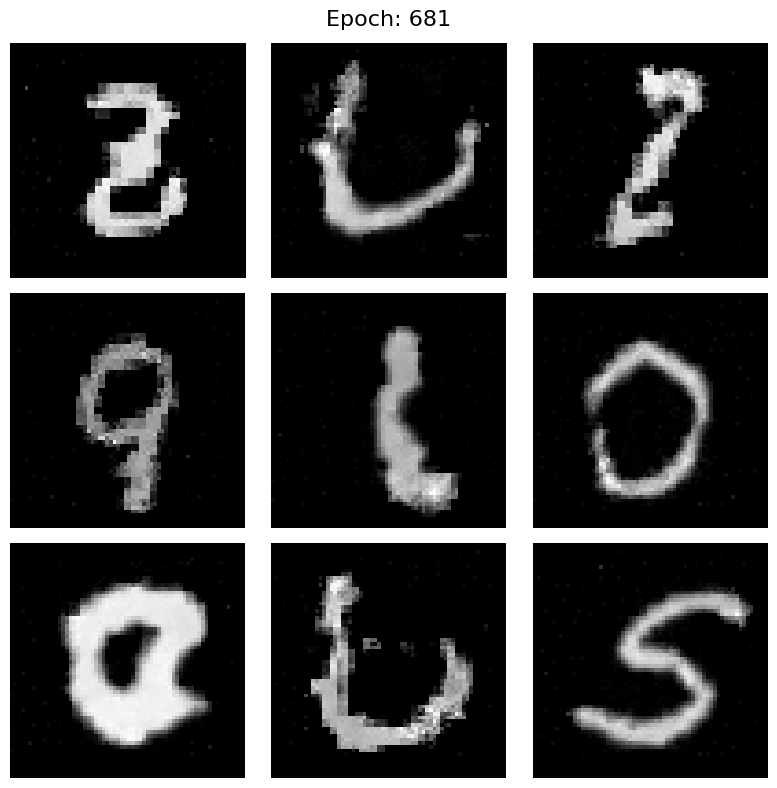

Epoch: 682/1000, d_loss: -1.0635, g_loss: 0.5426, time: 14.8148 sec


Epoch: 683/1000, d_loss: -1.0658, g_loss: 0.5372, time: 14.7577 sec


Epoch: 684/1000, d_loss: -1.0671, g_loss: 0.5438, time: 14.7681 sec


Epoch: 685/1000, d_loss: -1.0659, g_loss: 0.5403, time: 14.7620 sec


Epoch: 686/1000, d_loss: -1.0669, g_loss: 0.5447, time: 14.8276 sec


Epoch: 687/1000, d_loss: -1.0687, g_loss: 0.5401, time: 14.8190 sec


Epoch: 688/1000, d_loss: -1.0685, g_loss: 0.5446, time: 14.7724 sec


Epoch: 689/1000, d_loss: -1.0691, g_loss: 0.5399, time: 14.7221 sec


Epoch: 690/1000, d_loss: -1.0708, g_loss: 0.5478, time: 14.7182 sec


Epoch: 691/1000, d_loss: -1.0729, g_loss: 0.5446, time: 14.8017 sec


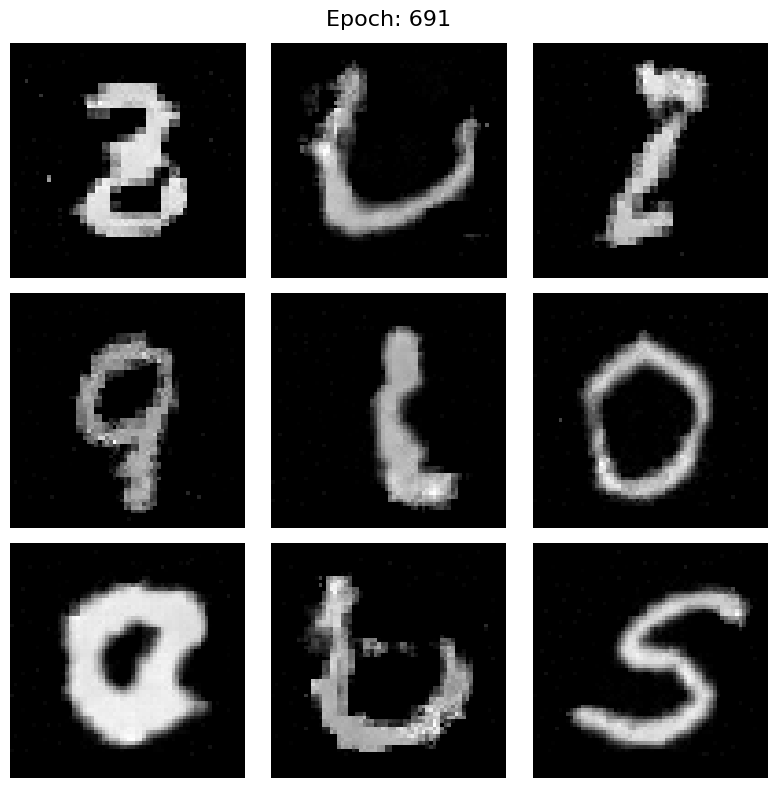

Epoch: 692/1000, d_loss: -1.0716, g_loss: 0.5425, time: 14.7991 sec


Epoch: 693/1000, d_loss: -1.0703, g_loss: 0.5460, time: 14.6507 sec


Epoch: 694/1000, d_loss: -1.0719, g_loss: 0.5419, time: 14.7728 sec


Epoch: 695/1000, d_loss: -1.0725, g_loss: 0.5472, time: 14.7743 sec


Epoch: 696/1000, d_loss: -1.0748, g_loss: 0.5429, time: 14.6701 sec


Epoch: 697/1000, d_loss: -1.0775, g_loss: 0.5490, time: 14.6309 sec


Epoch: 698/1000, d_loss: -1.0779, g_loss: 0.5455, time: 14.6978 sec


Epoch: 699/1000, d_loss: -1.0785, g_loss: 0.5474, time: 14.6303 sec


Epoch: 700/1000, d_loss: -1.0800, g_loss: 0.5479, time: 14.7016 sec


Epoch: 701/1000, d_loss: -1.0818, g_loss: 0.5471, time: 14.8376 sec


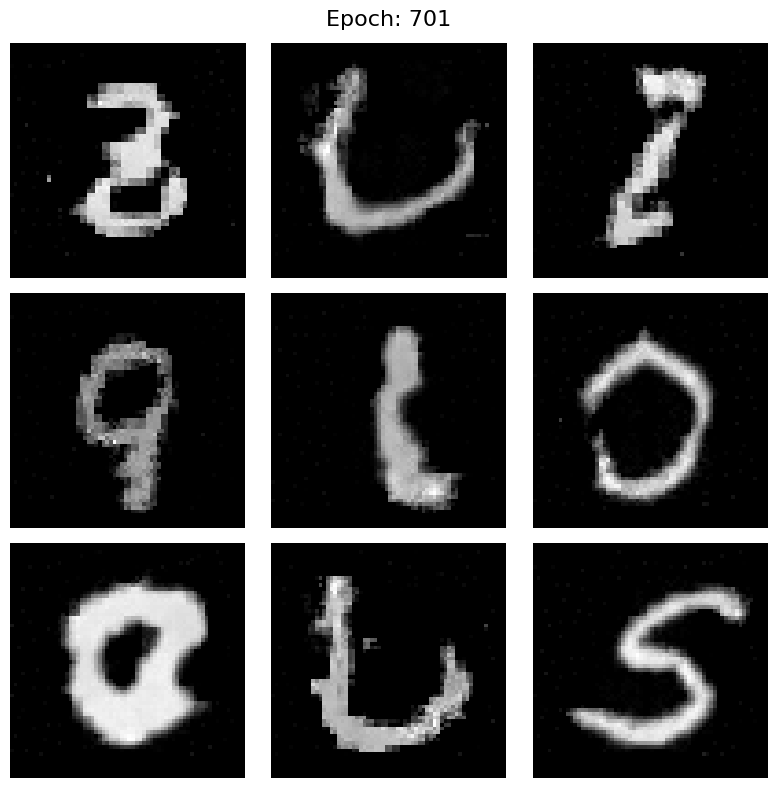

Epoch: 702/1000, d_loss: -1.0815, g_loss: 0.5471, time: 14.8511 sec


Epoch: 703/1000, d_loss: -1.0830, g_loss: 0.5514, time: 14.7042 sec


Epoch: 704/1000, d_loss: -1.0847, g_loss: 0.5468, time: 14.6853 sec


Epoch: 705/1000, d_loss: -1.0861, g_loss: 0.5461, time: 14.7409 sec


Epoch: 706/1000, d_loss: -1.0886, g_loss: 0.5485, time: 14.7476 sec


Epoch: 707/1000, d_loss: -1.0898, g_loss: 0.5489, time: 14.6993 sec


Epoch: 708/1000, d_loss: -1.0884, g_loss: 0.5534, time: 14.7463 sec


Epoch: 709/1000, d_loss: -1.0891, g_loss: 0.5488, time: 14.7070 sec


Epoch: 710/1000, d_loss: -1.0897, g_loss: 0.5531, time: 14.7806 sec


Epoch: 711/1000, d_loss: -1.0927, g_loss: 0.5516, time: 14.7340 sec


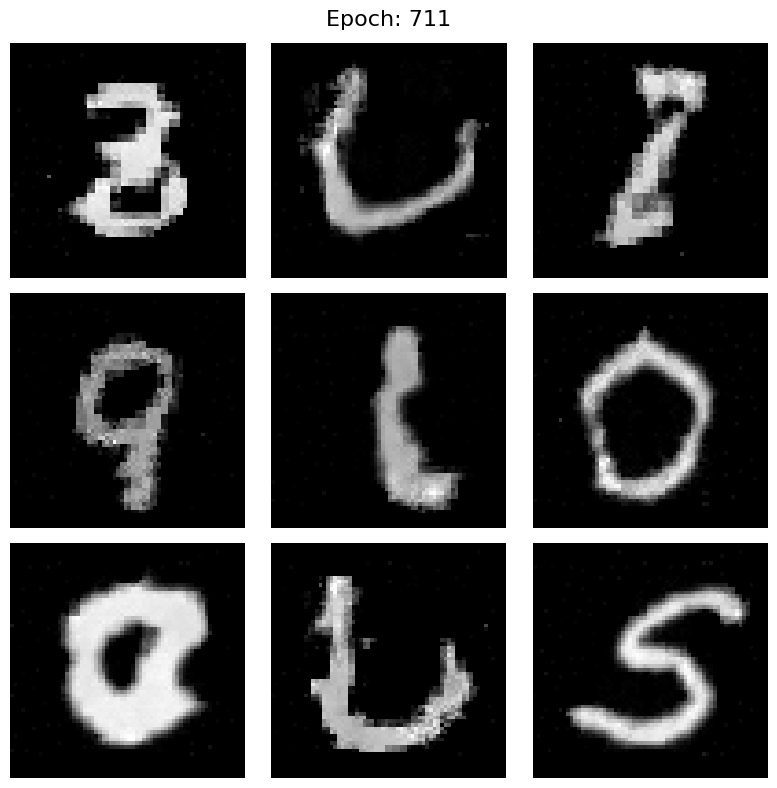

Epoch: 712/1000, d_loss: -1.0935, g_loss: 0.5561, time: 14.8134 sec


Epoch: 713/1000, d_loss: -1.0935, g_loss: 0.5566, time: 14.7613 sec


Epoch: 714/1000, d_loss: -1.0938, g_loss: 0.5519, time: 14.7215 sec


Epoch: 715/1000, d_loss: -1.0948, g_loss: 0.5562, time: 14.7068 sec


Epoch: 716/1000, d_loss: -1.0981, g_loss: 0.5547, time: 14.7065 sec


Epoch: 717/1000, d_loss: -1.0968, g_loss: 0.5567, time: 14.7391 sec


Epoch: 718/1000, d_loss: -1.0989, g_loss: 0.5516, time: 14.6709 sec


Epoch: 719/1000, d_loss: -1.0996, g_loss: 0.5561, time: 14.7088 sec


Epoch: 720/1000, d_loss: -1.1016, g_loss: 0.5548, time: 14.7335 sec


Epoch: 721/1000, d_loss: -1.1033, g_loss: 0.5570, time: 14.6926 sec


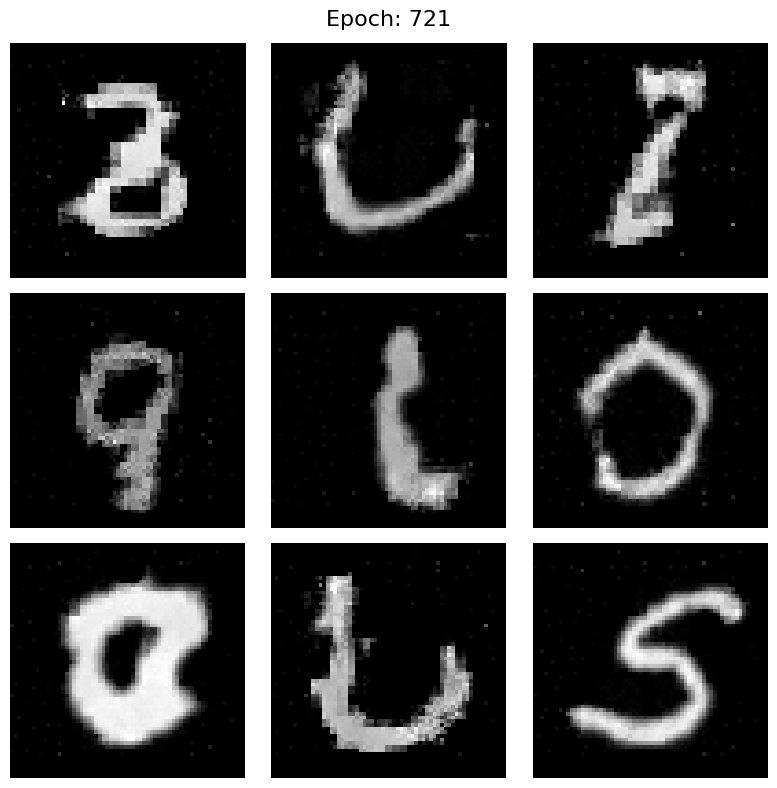

Epoch: 722/1000, d_loss: -1.1220, g_loss: 0.5664, time: 14.8992 sec


Epoch: 723/1000, d_loss: -1.1019, g_loss: 0.5592, time: 14.7579 sec


Epoch: 724/1000, d_loss: -1.1055, g_loss: 0.5650, time: 14.7825 sec


Epoch: 725/1000, d_loss: -1.1047, g_loss: 0.5596, time: 14.7391 sec


Epoch: 726/1000, d_loss: -1.1058, g_loss: 0.5606, time: 14.6344 sec


Epoch: 727/1000, d_loss: -1.1114, g_loss: 0.5591, time: 14.7532 sec


Epoch: 728/1000, d_loss: -1.1139, g_loss: 0.5651, time: 14.7345 sec


Epoch: 729/1000, d_loss: -1.1076, g_loss: 0.5569, time: 14.6674 sec


Epoch: 730/1000, d_loss: -1.1083, g_loss: 0.5601, time: 14.6666 sec


Epoch: 731/1000, d_loss: -1.1134, g_loss: 0.5668, time: 14.6843 sec


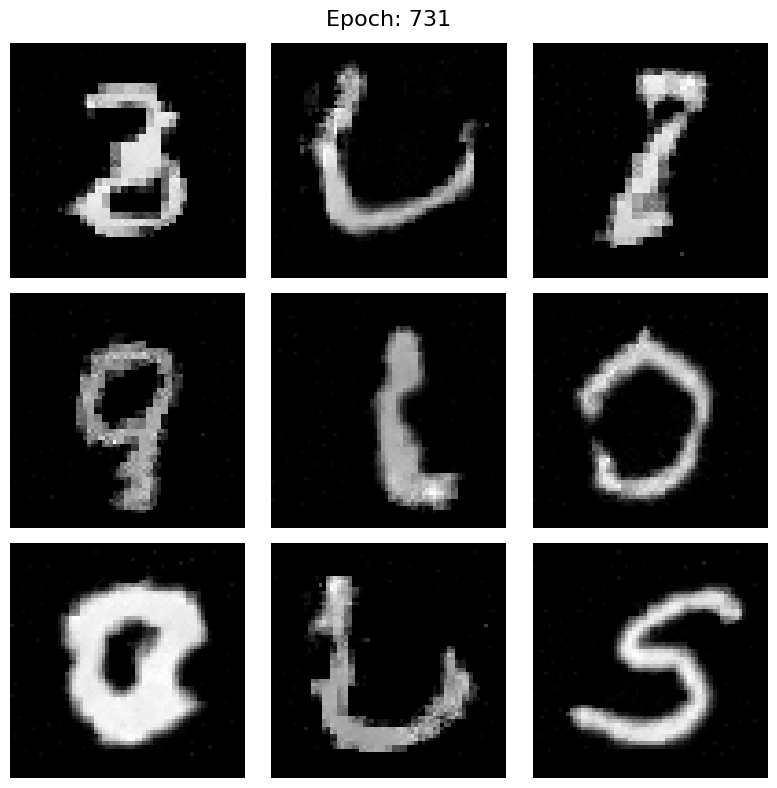

Epoch: 732/1000, d_loss: -1.1090, g_loss: 0.5640, time: 14.8499 sec


Epoch: 733/1000, d_loss: -1.1135, g_loss: 0.5614, time: 14.6782 sec


Epoch: 734/1000, d_loss: -1.1178, g_loss: 0.5639, time: 14.6606 sec


Epoch: 735/1000, d_loss: -1.1114, g_loss: 0.5669, time: 14.7409 sec


Epoch: 736/1000, d_loss: -1.1120, g_loss: 0.5611, time: 14.6760 sec


Epoch: 737/1000, d_loss: -1.1150, g_loss: 0.5637, time: 14.7431 sec


Epoch: 738/1000, d_loss: -1.1128, g_loss: 0.5600, time: 14.7265 sec


Epoch: 739/1000, d_loss: -1.1155, g_loss: 0.5666, time: 14.6684 sec


Epoch: 740/1000, d_loss: -1.1246, g_loss: 0.5668, time: 14.6738 sec


Epoch: 741/1000, d_loss: -1.1173, g_loss: 0.5710, time: 14.6756 sec


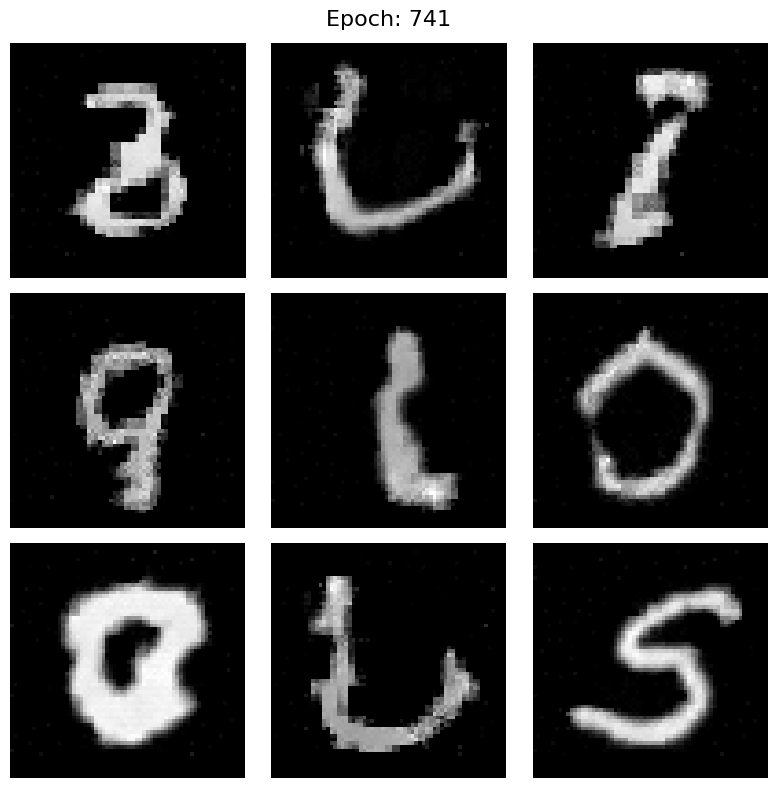

Epoch: 742/1000, d_loss: -1.1167, g_loss: 0.5647, time: 14.7044 sec


Epoch: 743/1000, d_loss: -1.1176, g_loss: 0.5698, time: 14.8016 sec


Epoch: 744/1000, d_loss: -1.1180, g_loss: 0.5644, time: 14.7543 sec


Epoch: 745/1000, d_loss: -1.1214, g_loss: 0.5685, time: 14.8213 sec


Epoch: 746/1000, d_loss: -1.1314, g_loss: 0.5716, time: 14.6806 sec


Epoch: 747/1000, d_loss: -1.1205, g_loss: 0.5710, time: 14.7372 sec


Epoch: 748/1000, d_loss: -1.1252, g_loss: 0.5693, time: 14.7492 sec


Epoch: 749/1000, d_loss: -1.1234, g_loss: 0.5680, time: 14.6971 sec


Epoch: 750/1000, d_loss: -1.1236, g_loss: 0.5699, time: 14.7472 sec


Epoch: 751/1000, d_loss: -1.1254, g_loss: 0.5670, time: 14.7951 sec


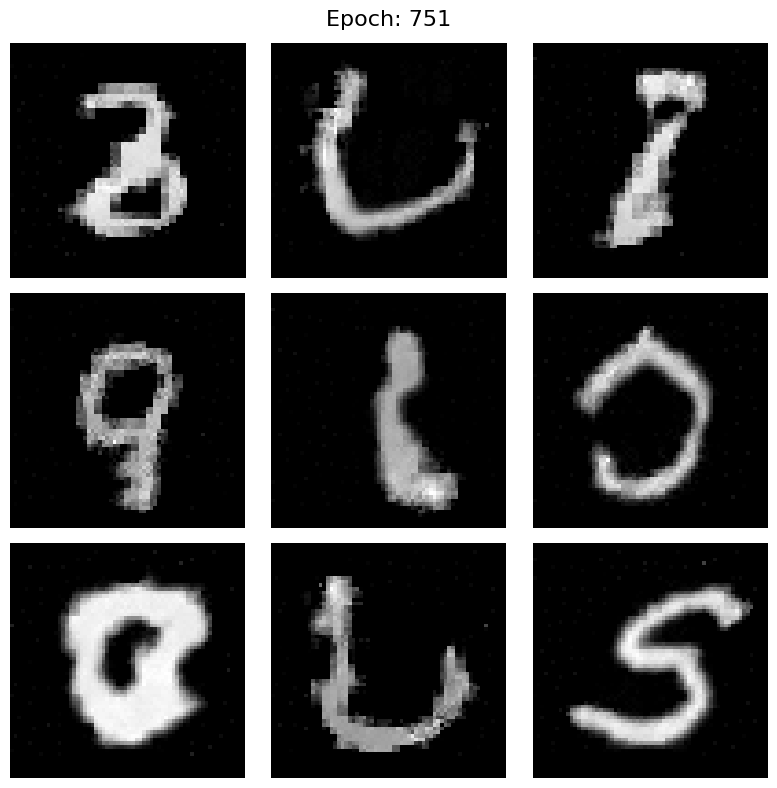

Epoch: 752/1000, d_loss: -1.1273, g_loss: 0.5724, time: 14.7577 sec


Epoch: 753/1000, d_loss: -1.1274, g_loss: 0.5683, time: 14.7816 sec


Epoch: 754/1000, d_loss: -1.1320, g_loss: 0.5716, time: 14.6383 sec


Epoch: 755/1000, d_loss: -1.1393, g_loss: 0.5752, time: 14.6639 sec


Epoch: 756/1000, d_loss: -1.1355, g_loss: 0.5736, time: 14.7491 sec


Epoch: 757/1000, d_loss: -1.1323, g_loss: 0.5746, time: 14.7806 sec


Epoch: 758/1000, d_loss: -1.1352, g_loss: 0.5721, time: 14.6827 sec


Epoch: 759/1000, d_loss: -1.1354, g_loss: 0.5757, time: 14.6860 sec


Epoch: 760/1000, d_loss: -1.1364, g_loss: 0.5725, time: 14.7833 sec


Epoch: 761/1000, d_loss: -1.1382, g_loss: 0.5721, time: 14.7004 sec


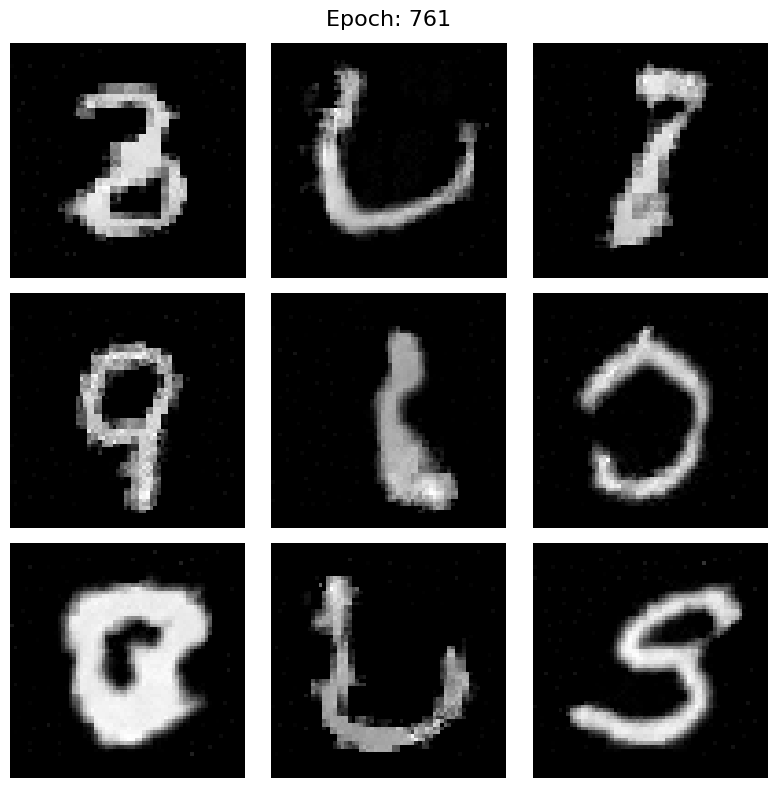

Epoch: 762/1000, d_loss: -1.1396, g_loss: 0.5768, time: 14.7903 sec


Epoch: 763/1000, d_loss: -1.1396, g_loss: 0.5792, time: 14.7545 sec


Epoch: 764/1000, d_loss: -1.1414, g_loss: 0.5777, time: 14.6401 sec


Epoch: 765/1000, d_loss: -1.1504, g_loss: 0.5820, time: 14.7845 sec


Epoch: 766/1000, d_loss: -1.1474, g_loss: 0.5742, time: 14.6917 sec


Epoch: 767/1000, d_loss: -1.1434, g_loss: 0.5829, time: 14.6421 sec


Epoch: 768/1000, d_loss: -1.1432, g_loss: 0.5782, time: 14.7358 sec


Epoch: 769/1000, d_loss: -1.1448, g_loss: 0.5804, time: 14.6612 sec


Epoch: 770/1000, d_loss: -1.1547, g_loss: 0.5813, time: 14.7349 sec


Epoch: 771/1000, d_loss: -1.1508, g_loss: 0.5818, time: 14.6262 sec


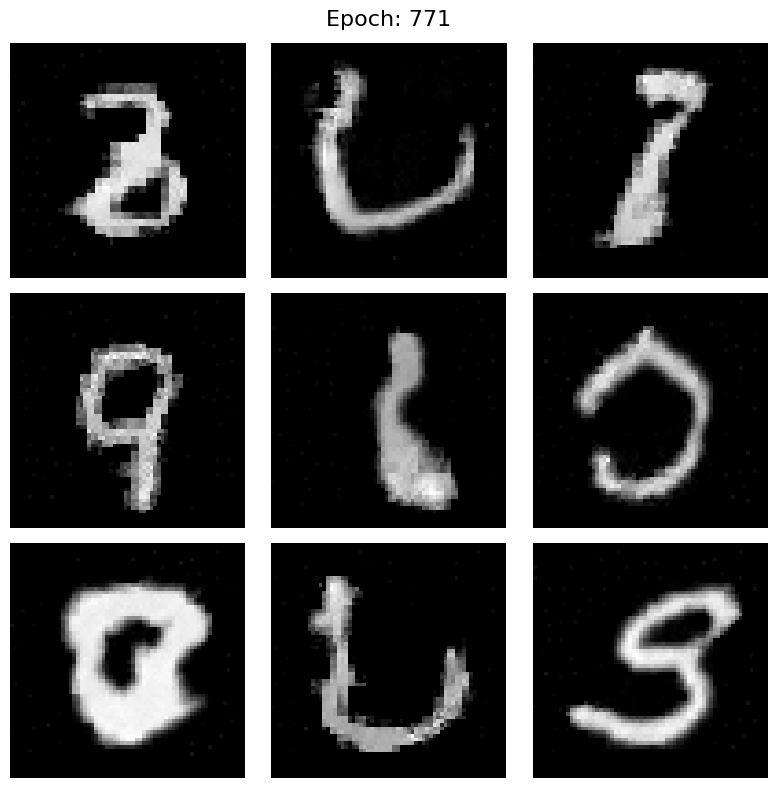

Epoch: 772/1000, d_loss: -1.1511, g_loss: 0.5861, time: 14.7997 sec


Epoch: 773/1000, d_loss: -1.1507, g_loss: 0.5815, time: 14.7127 sec


Epoch: 774/1000, d_loss: -1.1504, g_loss: 0.5847, time: 14.6817 sec


Epoch: 775/1000, d_loss: -1.1597, g_loss: 0.5828, time: 14.6888 sec


Epoch: 776/1000, d_loss: -1.1112, g_loss: 0.5689, time: 14.6552 sec


Epoch: 777/1000, d_loss: -1.1080, g_loss: 0.5669, time: 14.6837 sec


Epoch: 778/1000, d_loss: -1.1201, g_loss: 0.5715, time: 14.8172 sec


Epoch: 779/1000, d_loss: -1.1582, g_loss: 0.5823, time: 14.7900 sec


Epoch: 780/1000, d_loss: -1.1605, g_loss: 0.5802, time: 14.8475 sec


Epoch: 781/1000, d_loss: -1.1578, g_loss: 0.5877, time: 14.6248 sec


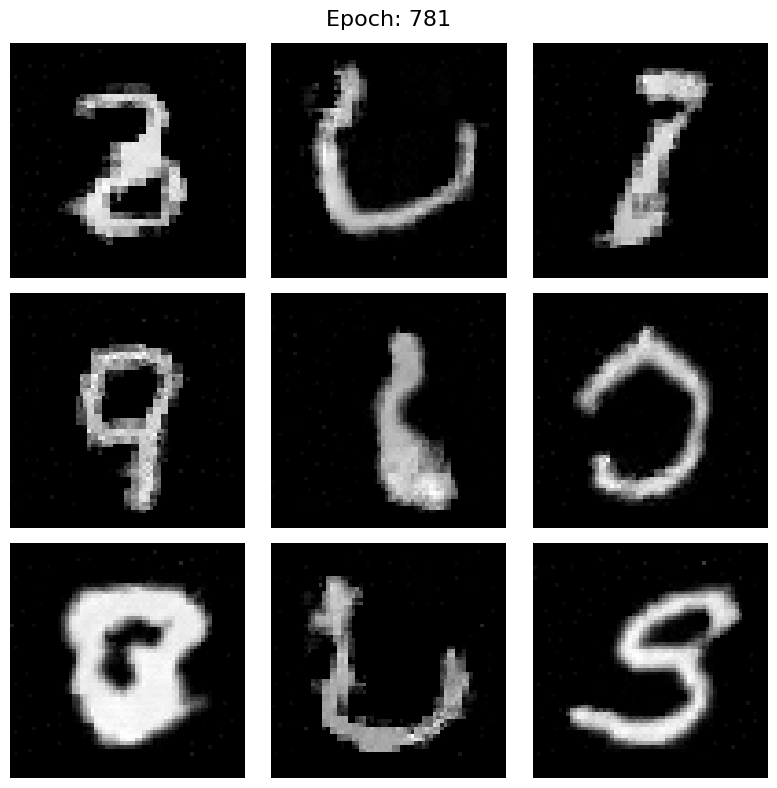

Epoch: 782/1000, d_loss: -1.1564, g_loss: 0.5848, time: 14.8527 sec


Epoch: 783/1000, d_loss: -1.1581, g_loss: 0.5866, time: 14.7076 sec


Epoch: 784/1000, d_loss: -1.1610, g_loss: 0.5855, time: 14.7100 sec


Epoch: 785/1000, d_loss: -1.1599, g_loss: 0.5878, time: 14.7262 sec


Epoch: 786/1000, d_loss: -1.1639, g_loss: 0.5834, time: 14.7716 sec


Epoch: 787/1000, d_loss: -1.1652, g_loss: 0.5855, time: 14.6702 sec


Epoch: 788/1000, d_loss: -1.1643, g_loss: 0.5899, time: 14.6461 sec


Epoch: 789/1000, d_loss: -1.1724, g_loss: 0.5891, time: 14.8281 sec


Epoch: 790/1000, d_loss: -1.1693, g_loss: 0.5887, time: 14.7091 sec


Epoch: 791/1000, d_loss: -1.1695, g_loss: 0.5797, time: 14.6644 sec


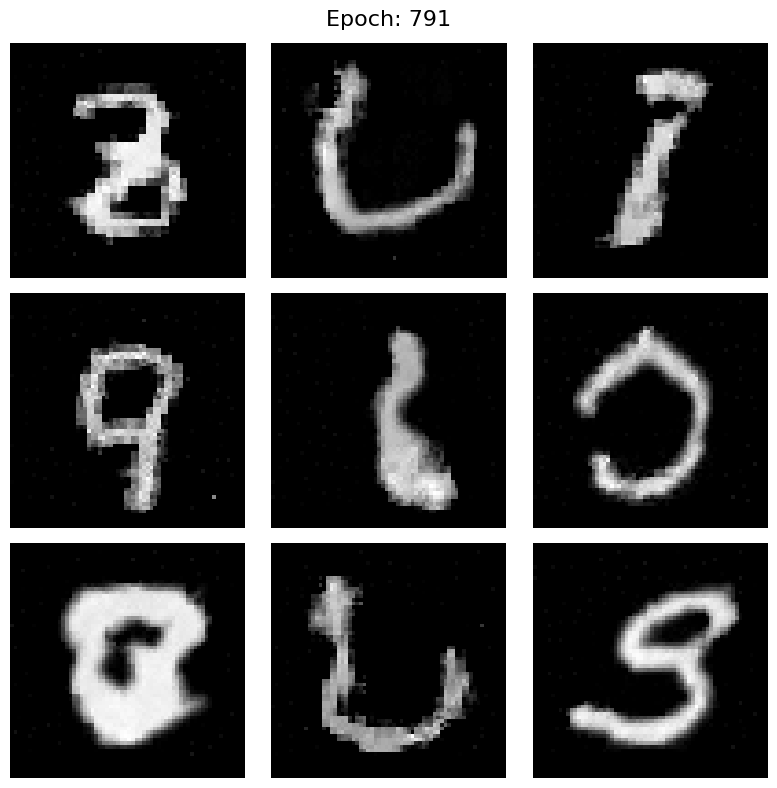

Epoch: 792/1000, d_loss: -1.1665, g_loss: 0.5929, time: 14.7485 sec


Epoch: 793/1000, d_loss: -1.1683, g_loss: 0.5869, time: 14.8173 sec


Epoch: 794/1000, d_loss: -1.1697, g_loss: 0.5898, time: 14.6367 sec


Epoch: 795/1000, d_loss: -1.1733, g_loss: 0.5922, time: 14.6823 sec


Epoch: 796/1000, d_loss: -1.1749, g_loss: 0.5902, time: 14.6331 sec


Epoch: 797/1000, d_loss: -1.1721, g_loss: 0.5940, time: 14.7343 sec


Epoch: 798/1000, d_loss: -1.1730, g_loss: 0.5904, time: 14.7562 sec


Epoch: 799/1000, d_loss: -1.1759, g_loss: 0.5958, time: 14.7832 sec


Epoch: 800/1000, d_loss: -1.1765, g_loss: 0.5924, time: 14.6742 sec


Epoch: 801/1000, d_loss: -1.1841, g_loss: 0.5994, time: 14.7824 sec


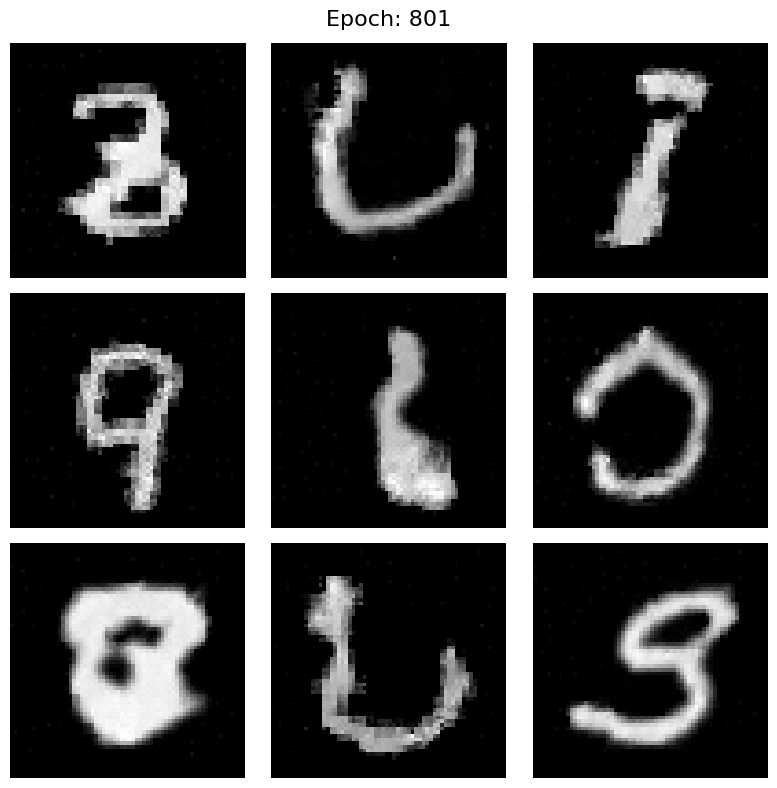

Epoch: 802/1000, d_loss: -1.1780, g_loss: 0.5966, time: 14.7829 sec


Epoch: 803/1000, d_loss: -1.1605, g_loss: 0.5829, time: 14.6197 sec


Epoch: 804/1000, d_loss: -1.1363, g_loss: 0.5809, time: 14.6422 sec


Epoch: 805/1000, d_loss: -1.1340, g_loss: 0.5836, time: 14.6221 sec


Epoch: 806/1000, d_loss: -1.1348, g_loss: 0.5762, time: 14.6833 sec


Epoch: 807/1000, d_loss: -1.1357, g_loss: 0.5770, time: 14.7530 sec


Epoch: 808/1000, d_loss: -1.1374, g_loss: 0.5765, time: 14.6881 sec


Epoch: 809/1000, d_loss: -1.1350, g_loss: 0.5803, time: 14.6621 sec


Epoch: 810/1000, d_loss: -1.1379, g_loss: 0.5762, time: 14.8132 sec


Epoch: 811/1000, d_loss: -1.1364, g_loss: 0.5787, time: 14.7390 sec


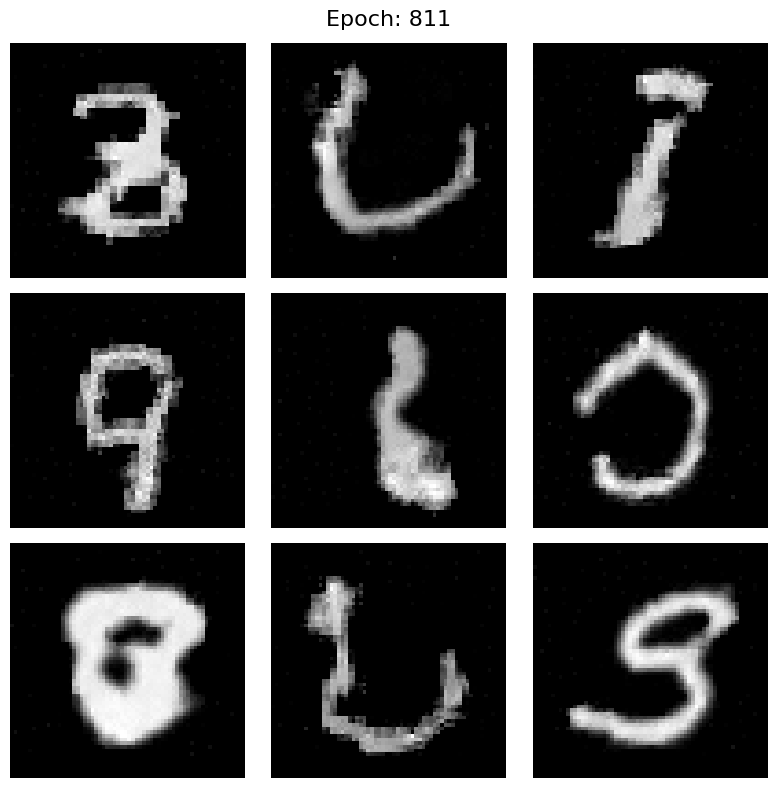

Epoch: 812/1000, d_loss: -1.1376, g_loss: 0.5772, time: 14.8035 sec


Epoch: 813/1000, d_loss: -1.1899, g_loss: 0.5985, time: 14.6594 sec


Epoch: 814/1000, d_loss: -1.1849, g_loss: 0.5991, time: 14.8444 sec


Epoch: 815/1000, d_loss: -1.1886, g_loss: 0.5900, time: 14.6911 sec


Epoch: 816/1000, d_loss: -1.1870, g_loss: 0.6008, time: 14.7328 sec


Epoch: 817/1000, d_loss: -1.1850, g_loss: 0.5972, time: 14.7172 sec


Epoch: 818/1000, d_loss: -1.1869, g_loss: 0.5989, time: 14.6483 sec


Epoch: 819/1000, d_loss: -1.1929, g_loss: 0.5986, time: 14.7375 sec


Epoch: 820/1000, d_loss: -1.1894, g_loss: 0.6023, time: 14.7784 sec


Epoch: 821/1000, d_loss: -1.1926, g_loss: 0.5978, time: 14.7182 sec


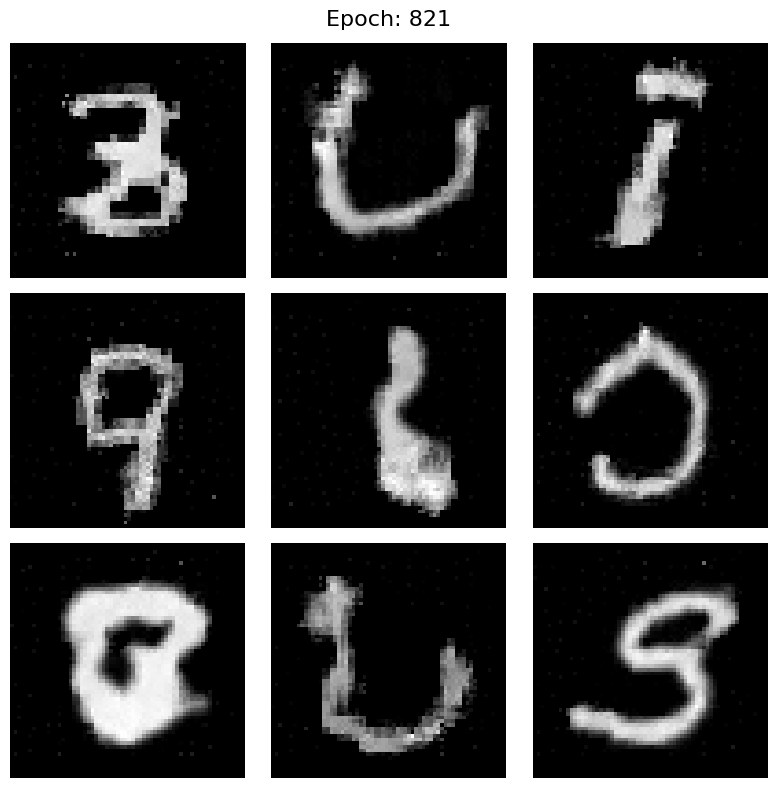

Epoch: 822/1000, d_loss: -1.1817, g_loss: 0.5896, time: 14.8467 sec


Epoch: 823/1000, d_loss: -1.1491, g_loss: 0.5921, time: 14.7324 sec


Epoch: 824/1000, d_loss: -1.1505, g_loss: 0.5849, time: 14.6632 sec


Epoch: 825/1000, d_loss: -1.1483, g_loss: 0.5818, time: 14.7497 sec


Epoch: 826/1000, d_loss: -1.1472, g_loss: 0.5824, time: 14.7105 sec


Epoch: 827/1000, d_loss: -1.1475, g_loss: 0.5880, time: 14.6450 sec


Epoch: 828/1000, d_loss: -1.1491, g_loss: 0.5819, time: 14.8736 sec


Epoch: 829/1000, d_loss: -1.1718, g_loss: 0.5931, time: 14.7376 sec


Epoch: 830/1000, d_loss: -1.2013, g_loss: 0.6034, time: 14.6637 sec


Epoch: 831/1000, d_loss: -1.1962, g_loss: 0.6035, time: 14.6352 sec


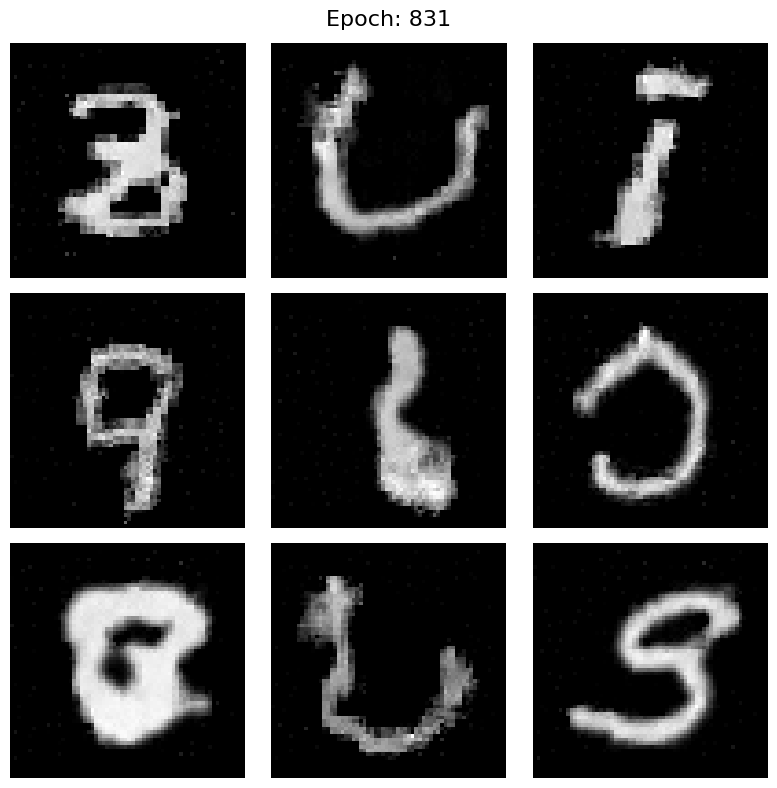

Epoch: 832/1000, d_loss: -1.1979, g_loss: 0.6031, time: 14.7517 sec


Epoch: 833/1000, d_loss: -1.1960, g_loss: 0.6035, time: 14.7350 sec


Epoch: 834/1000, d_loss: -1.2017, g_loss: 0.6052, time: 14.7510 sec


Epoch: 835/1000, d_loss: -1.1979, g_loss: 0.6036, time: 14.7762 sec


Epoch: 836/1000, d_loss: -1.1998, g_loss: 0.6056, time: 14.7176 sec


Epoch: 837/1000, d_loss: -1.2040, g_loss: 0.6038, time: 14.6470 sec


Epoch: 838/1000, d_loss: -1.2036, g_loss: 0.6061, time: 14.7245 sec


Epoch: 839/1000, d_loss: -1.2010, g_loss: 0.6079, time: 14.6685 sec


Epoch: 840/1000, d_loss: -1.2022, g_loss: 0.6028, time: 14.7307 sec


Epoch: 841/1000, d_loss: -1.2023, g_loss: 0.6068, time: 14.7595 sec


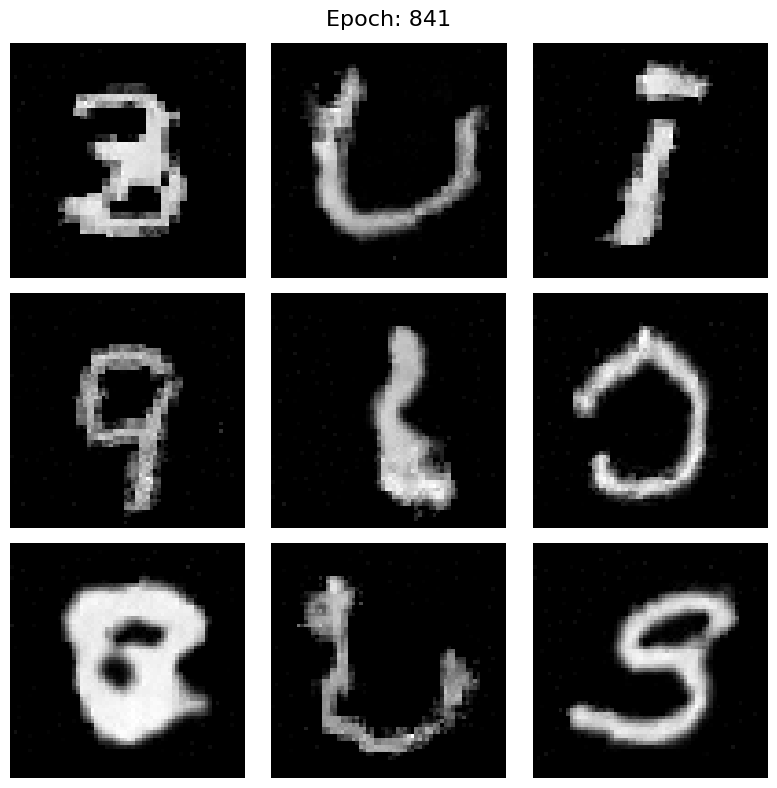

Epoch: 842/1000, d_loss: -1.2031, g_loss: 0.6012, time: 14.8777 sec


Epoch: 843/1000, d_loss: -1.2024, g_loss: 0.6076, time: 14.6710 sec


Epoch: 844/1000, d_loss: -1.2080, g_loss: 0.6058, time: 14.7377 sec


Epoch: 845/1000, d_loss: -1.2058, g_loss: 0.6106, time: 14.6463 sec


Epoch: 846/1000, d_loss: -1.2040, g_loss: 0.6072, time: 14.7599 sec


Epoch: 847/1000, d_loss: -1.2041, g_loss: 0.6076, time: 14.7048 sec


Epoch: 848/1000, d_loss: -1.2059, g_loss: 0.6049, time: 14.7330 sec


Epoch: 849/1000, d_loss: -1.2073, g_loss: 0.6084, time: 14.7198 sec


Epoch: 850/1000, d_loss: -1.2066, g_loss: 0.6072, time: 14.6901 sec


Epoch: 851/1000, d_loss: -1.2080, g_loss: 0.6077, time: 14.6727 sec


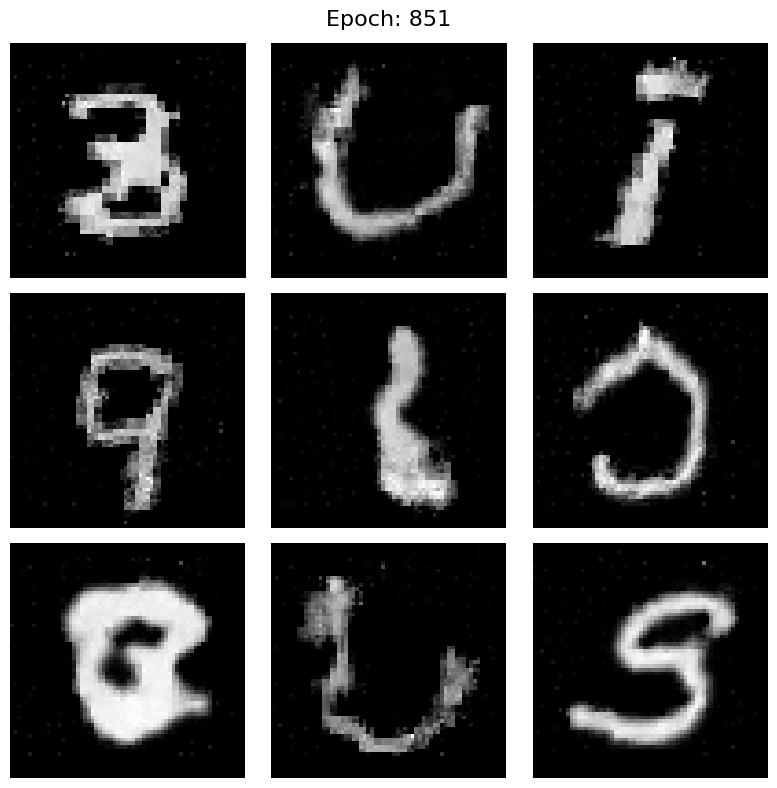

Epoch: 852/1000, d_loss: -1.2127, g_loss: 0.6065, time: 14.7985 sec


Epoch: 853/1000, d_loss: -1.2094, g_loss: 0.6118, time: 14.7268 sec


Epoch: 854/1000, d_loss: -1.2086, g_loss: 0.6077, time: 14.6185 sec


Epoch: 855/1000, d_loss: -1.2095, g_loss: 0.6109, time: 14.7111 sec


Epoch: 856/1000, d_loss: -1.2106, g_loss: 0.6070, time: 14.6990 sec


Epoch: 857/1000, d_loss: -1.2118, g_loss: 0.6098, time: 14.7619 sec


Epoch: 858/1000, d_loss: -1.2124, g_loss: 0.6102, time: 14.7297 sec


Epoch: 859/1000, d_loss: -1.2139, g_loss: 0.6101, time: 14.7405 sec


Epoch: 860/1000, d_loss: -1.2193, g_loss: 0.6100, time: 14.7938 sec


Epoch: 861/1000, d_loss: -1.2155, g_loss: 0.6158, time: 14.8514 sec


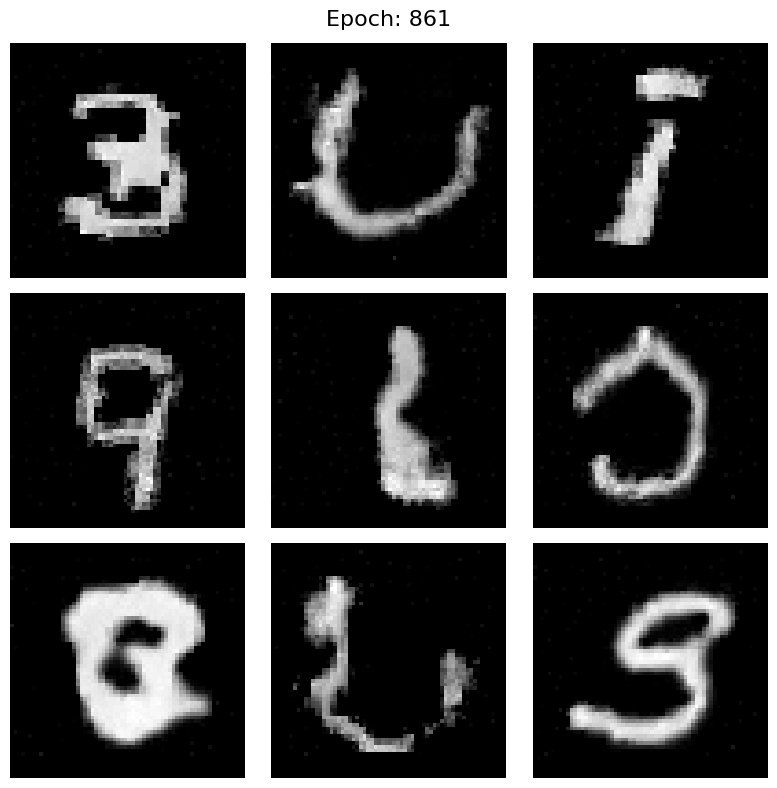

Epoch: 862/1000, d_loss: -1.2141, g_loss: 0.6132, time: 14.7586 sec


Epoch: 863/1000, d_loss: -1.2161, g_loss: 0.6075, time: 14.6694 sec


Epoch: 864/1000, d_loss: -1.2176, g_loss: 0.6134, time: 14.6325 sec


Epoch: 865/1000, d_loss: -1.2192, g_loss: 0.6100, time: 14.6893 sec


Epoch: 866/1000, d_loss: -1.2194, g_loss: 0.6142, time: 14.8256 sec


Epoch: 867/1000, d_loss: -1.2169, g_loss: 0.6138, time: 14.8129 sec


Epoch: 868/1000, d_loss: -1.2173, g_loss: 0.6110, time: 14.7216 sec


Epoch: 869/1000, d_loss: -1.2195, g_loss: 0.6143, time: 14.7107 sec


Epoch: 870/1000, d_loss: -1.2199, g_loss: 0.6109, time: 14.6604 sec


Epoch: 871/1000, d_loss: -1.2232, g_loss: 0.6141, time: 14.7029 sec


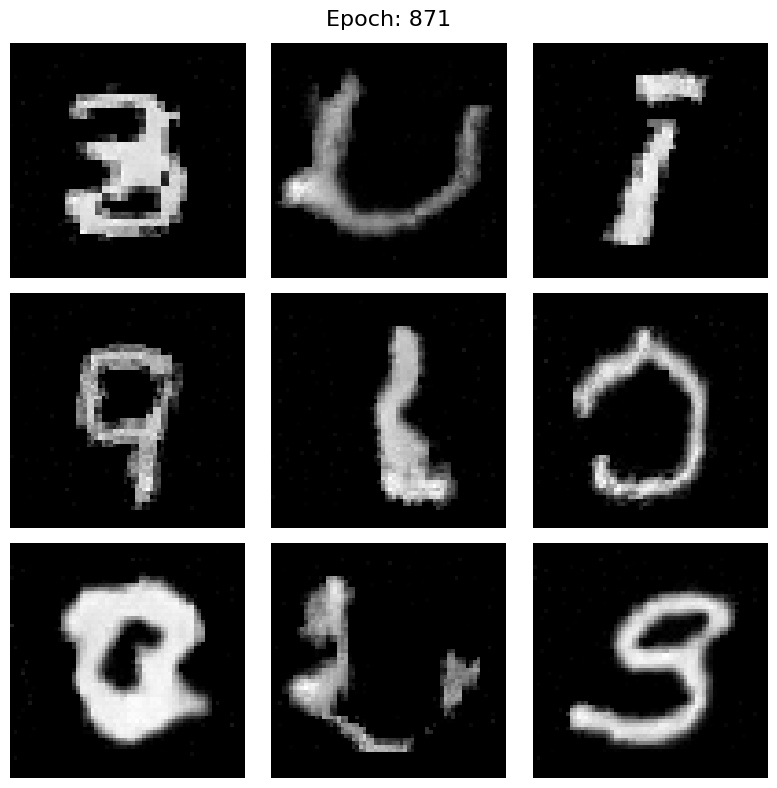

Epoch: 872/1000, d_loss: -1.2219, g_loss: 0.6122, time: 14.8098 sec


Epoch: 873/1000, d_loss: -1.2054, g_loss: 0.5969, time: 14.7487 sec


Epoch: 874/1000, d_loss: -1.2151, g_loss: 0.6045, time: 14.7627 sec


Epoch: 875/1000, d_loss: -1.2150, g_loss: 0.6044, time: 14.7949 sec


Epoch: 876/1000, d_loss: -1.2148, g_loss: 0.6069, time: 14.7020 sec


Epoch: 877/1000, d_loss: -1.2165, g_loss: 0.6085, time: 14.6878 sec


Epoch: 878/1000, d_loss: -1.2160, g_loss: 0.6090, time: 14.7583 sec


Epoch: 879/1000, d_loss: -1.2175, g_loss: 0.6083, time: 14.7859 sec


Epoch: 880/1000, d_loss: -1.2185, g_loss: 0.6072, time: 14.7407 sec


Epoch: 881/1000, d_loss: -1.2209, g_loss: 0.6097, time: 14.6847 sec


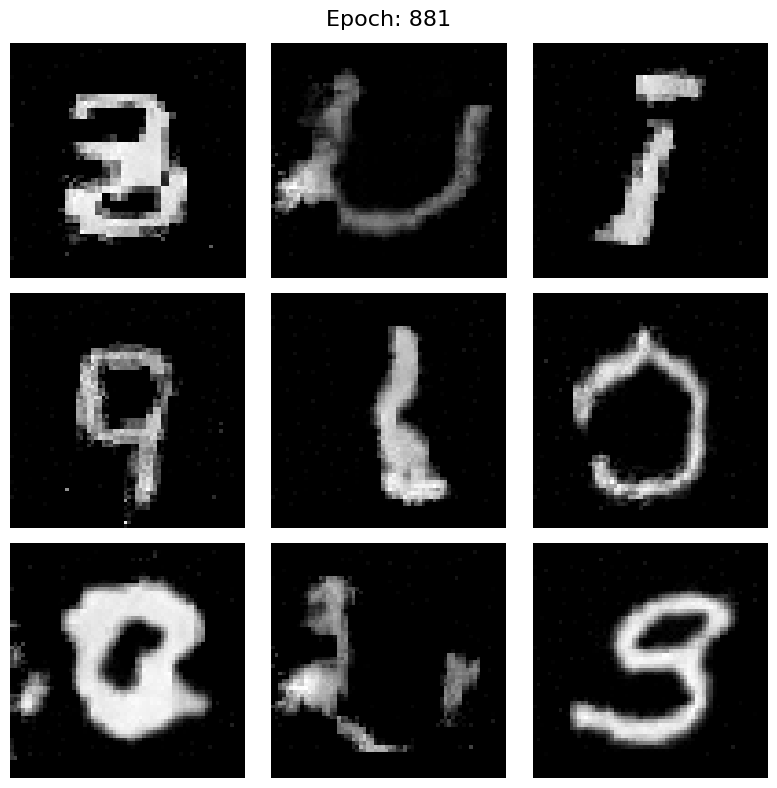

Epoch: 882/1000, d_loss: -1.2229, g_loss: 0.6128, time: 14.7492 sec


Epoch: 883/1000, d_loss: -1.2211, g_loss: 0.6092, time: 14.7425 sec


Epoch: 884/1000, d_loss: -1.2219, g_loss: 0.6124, time: 14.7741 sec


Epoch: 885/1000, d_loss: -1.2239, g_loss: 0.6112, time: 14.7410 sec


Epoch: 886/1000, d_loss: -1.2251, g_loss: 0.6134, time: 14.6946 sec


Epoch: 887/1000, d_loss: -1.2253, g_loss: 0.6129, time: 14.7088 sec


Epoch: 888/1000, d_loss: -1.2240, g_loss: 0.6136, time: 14.7979 sec


Epoch: 889/1000, d_loss: -1.2244, g_loss: 0.6116, time: 14.6821 sec


Epoch: 890/1000, d_loss: -1.2284, g_loss: 0.6174, time: 14.7604 sec


Epoch: 891/1000, d_loss: -1.2261, g_loss: 0.6121, time: 14.7503 sec


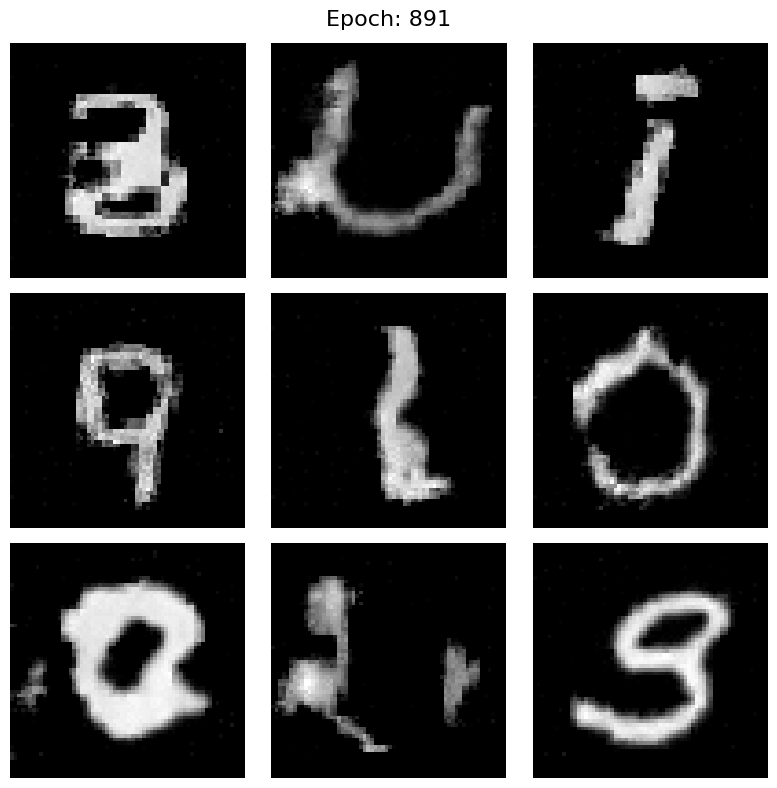

Epoch: 892/1000, d_loss: -1.2263, g_loss: 0.6145, time: 14.9086 sec


Epoch: 893/1000, d_loss: -1.2276, g_loss: 0.6130, time: 14.7909 sec


Epoch: 894/1000, d_loss: -1.2260, g_loss: 0.6127, time: 14.7822 sec


Epoch: 895/1000, d_loss: -1.2277, g_loss: 0.6143, time: 14.7443 sec


Epoch: 896/1000, d_loss: -1.2286, g_loss: 0.6136, time: 14.7432 sec


Epoch: 897/1000, d_loss: -1.2290, g_loss: 0.6162, time: 14.7307 sec


Epoch: 898/1000, d_loss: -1.2314, g_loss: 0.6143, time: 14.7428 sec


Epoch: 899/1000, d_loss: -1.2278, g_loss: 0.6149, time: 14.7576 sec


Epoch: 900/1000, d_loss: -1.2300, g_loss: 0.6181, time: 14.7257 sec


Epoch: 901/1000, d_loss: -1.2297, g_loss: 0.6145, time: 14.6728 sec


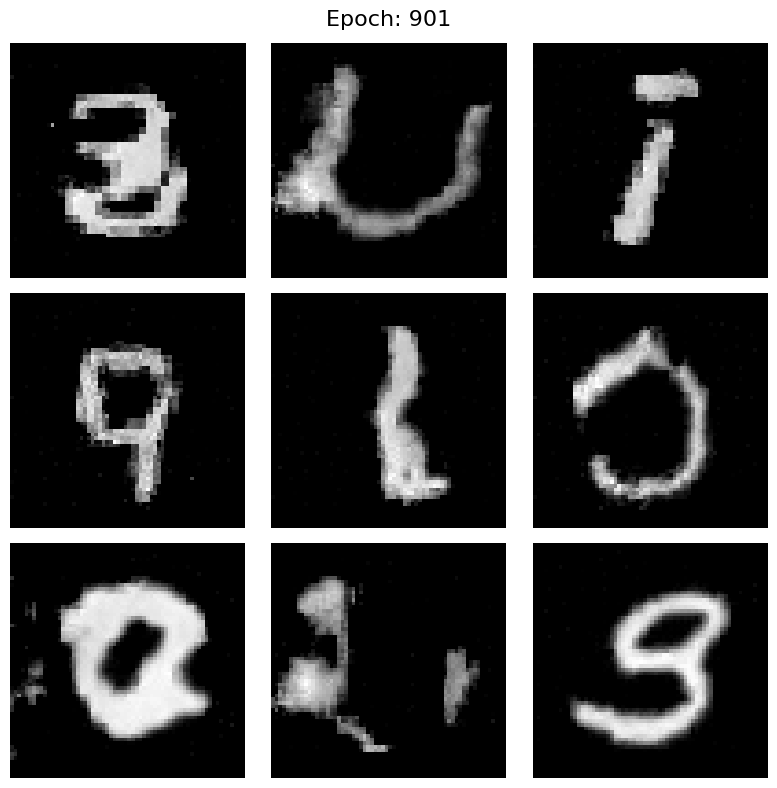

Epoch: 902/1000, d_loss: -1.2289, g_loss: 0.6161, time: 14.8455 sec


Epoch: 903/1000, d_loss: -1.2299, g_loss: 0.6183, time: 14.7410 sec


Epoch: 904/1000, d_loss: -1.2288, g_loss: 0.6127, time: 14.6693 sec


Epoch: 905/1000, d_loss: -1.2292, g_loss: 0.6167, time: 14.7734 sec


Epoch: 906/1000, d_loss: -1.2292, g_loss: 0.6144, time: 14.7599 sec


Epoch: 907/1000, d_loss: -1.2308, g_loss: 0.6164, time: 14.8056 sec


Epoch: 908/1000, d_loss: -1.2304, g_loss: 0.6159, time: 14.6471 sec


Epoch: 909/1000, d_loss: -1.2291, g_loss: 0.6154, time: 14.7239 sec


Epoch: 910/1000, d_loss: -1.2294, g_loss: 0.6174, time: 14.7363 sec


Epoch: 911/1000, d_loss: -1.2307, g_loss: 0.6155, time: 14.7923 sec


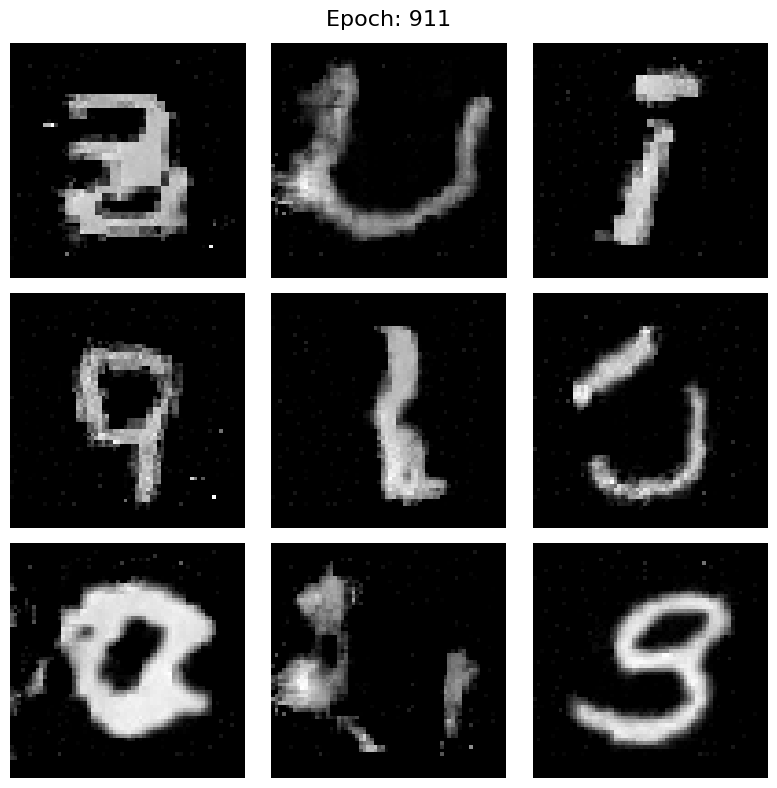

Epoch: 912/1000, d_loss: -1.2332, g_loss: 0.6198, time: 14.7952 sec


Epoch: 913/1000, d_loss: -1.2292, g_loss: 0.6143, time: 14.7294 sec


Epoch: 914/1000, d_loss: -1.2302, g_loss: 0.6188, time: 14.8027 sec


Epoch: 915/1000, d_loss: -1.2299, g_loss: 0.6140, time: 14.7685 sec


Epoch: 916/1000, d_loss: -1.2301, g_loss: 0.6170, time: 14.8318 sec


Epoch: 917/1000, d_loss: -1.2297, g_loss: 0.6137, time: 14.8001 sec


Epoch: 918/1000, d_loss: -1.2297, g_loss: 0.6169, time: 14.7300 sec


Epoch: 919/1000, d_loss: -1.2310, g_loss: 0.6163, time: 14.7187 sec


Epoch: 920/1000, d_loss: -1.2313, g_loss: 0.6161, time: 14.6839 sec


Epoch: 921/1000, d_loss: -1.2330, g_loss: 0.6170, time: 14.7061 sec


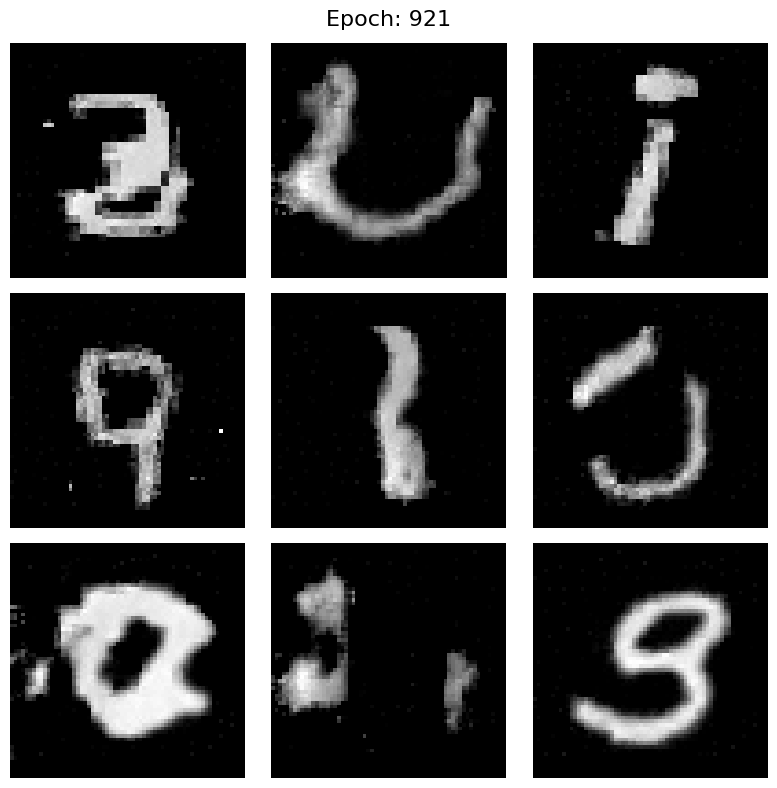

Epoch: 922/1000, d_loss: -1.2323, g_loss: 0.6166, time: 14.8166 sec


Epoch: 923/1000, d_loss: -1.2326, g_loss: 0.6178, time: 14.8093 sec


Epoch: 924/1000, d_loss: -1.2323, g_loss: 0.6159, time: 14.6768 sec


Epoch: 925/1000, d_loss: -1.2318, g_loss: 0.6181, time: 14.7405 sec


Epoch: 926/1000, d_loss: -1.2345, g_loss: 0.6178, time: 14.7976 sec


Epoch: 927/1000, d_loss: -1.2336, g_loss: 0.6182, time: 14.8066 sec


Epoch: 928/1000, d_loss: -1.2353, g_loss: 0.6193, time: 14.7951 sec


Epoch: 929/1000, d_loss: -1.2348, g_loss: 0.6184, time: 14.8120 sec


Epoch: 930/1000, d_loss: -1.2355, g_loss: 0.6157, time: 14.7825 sec


Epoch: 931/1000, d_loss: -1.2365, g_loss: 0.6179, time: 14.7746 sec


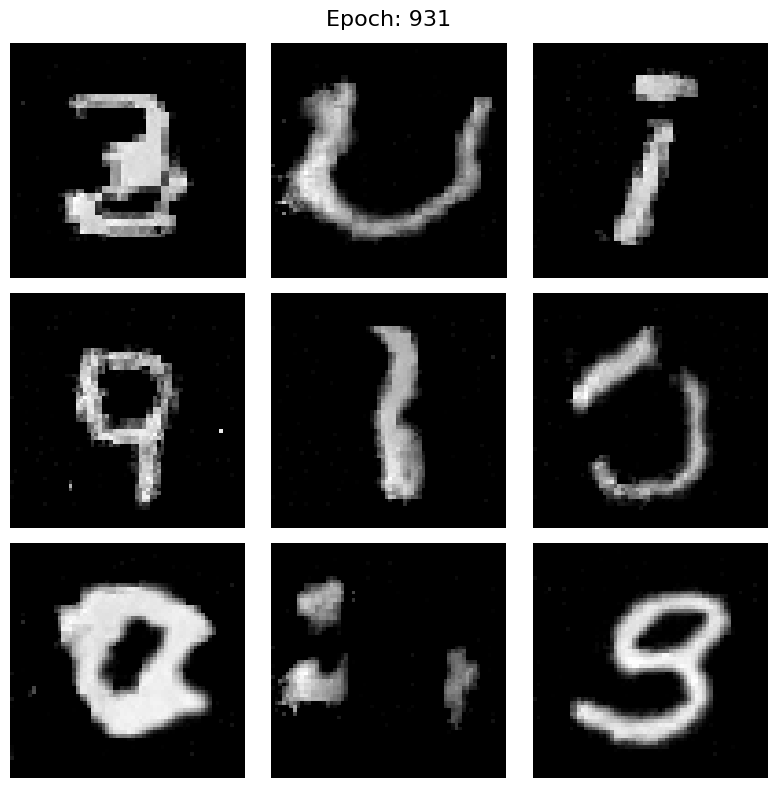

Epoch: 932/1000, d_loss: -1.2367, g_loss: 0.6210, time: 14.8361 sec


Epoch: 933/1000, d_loss: -1.2377, g_loss: 0.6185, time: 14.7783 sec


Epoch: 934/1000, d_loss: -1.2350, g_loss: 0.6193, time: 14.6727 sec


Epoch: 935/1000, d_loss: -1.2372, g_loss: 0.6203, time: 14.8005 sec


Epoch: 936/1000, d_loss: -1.2377, g_loss: 0.6199, time: 14.7303 sec


Epoch: 937/1000, d_loss: -1.2376, g_loss: 0.6191, time: 14.7442 sec


Epoch: 938/1000, d_loss: -1.2376, g_loss: 0.6211, time: 14.8058 sec


Epoch: 939/1000, d_loss: -1.2380, g_loss: 0.6179, time: 14.7338 sec


Epoch: 940/1000, d_loss: -1.2393, g_loss: 0.6233, time: 14.8583 sec


Epoch: 941/1000, d_loss: -1.2377, g_loss: 0.6180, time: 14.8589 sec


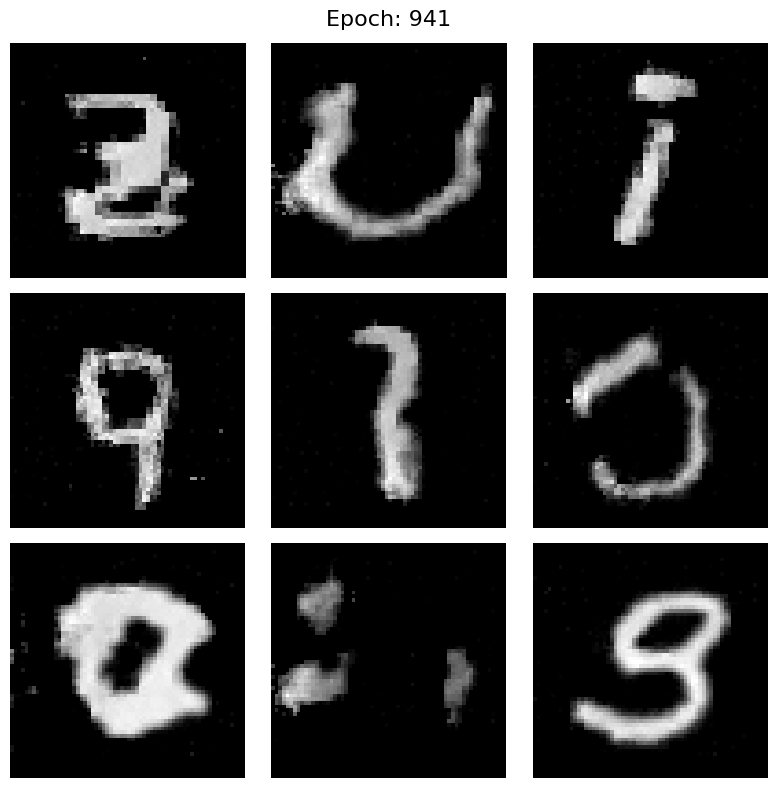

Epoch: 942/1000, d_loss: -1.2384, g_loss: 0.6199, time: 14.7822 sec


Epoch: 943/1000, d_loss: -1.2377, g_loss: 0.6202, time: 14.7910 sec


Epoch: 944/1000, d_loss: -1.2401, g_loss: 0.6206, time: 14.7263 sec


Epoch: 945/1000, d_loss: -1.2399, g_loss: 0.6206, time: 14.7944 sec


Epoch: 946/1000, d_loss: -1.2415, g_loss: 0.6198, time: 14.9092 sec


Epoch: 947/1000, d_loss: -1.2417, g_loss: 0.6200, time: 14.7873 sec


Epoch: 948/1000, d_loss: -1.2420, g_loss: 0.6232, time: 14.7551 sec


Epoch: 949/1000, d_loss: -1.2431, g_loss: 0.6217, time: 14.8224 sec


Epoch: 950/1000, d_loss: -1.2418, g_loss: 0.6209, time: 14.7299 sec


Epoch: 951/1000, d_loss: -1.2426, g_loss: 0.6227, time: 14.7234 sec


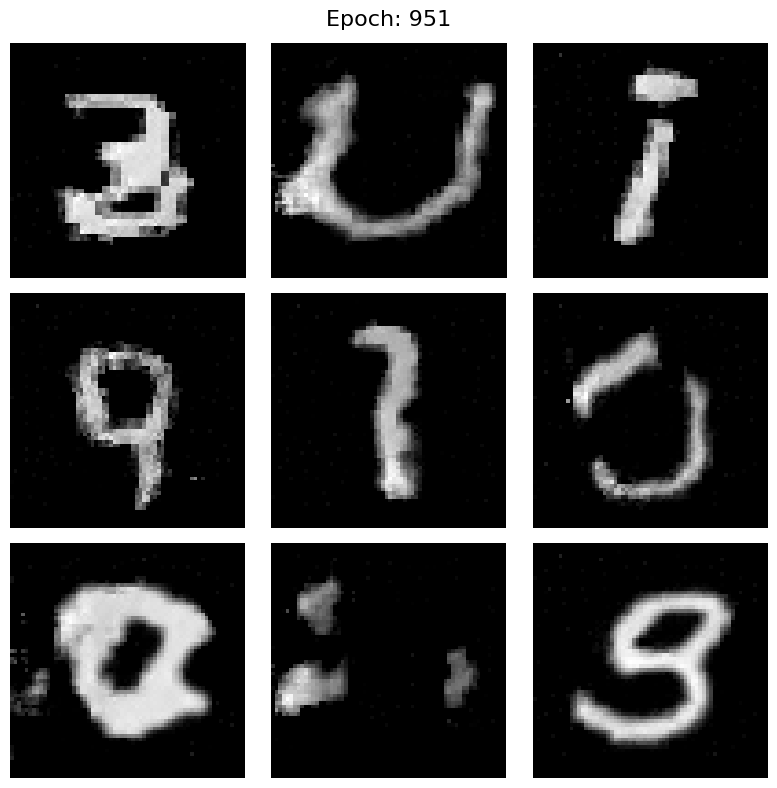

Epoch: 952/1000, d_loss: -1.2416, g_loss: 0.6211, time: 14.8049 sec


Epoch: 953/1000, d_loss: -1.2173, g_loss: 0.6098, time: 14.7681 sec


Epoch: 954/1000, d_loss: -1.2231, g_loss: 0.6153, time: 14.7026 sec


Epoch: 955/1000, d_loss: -1.2412, g_loss: 0.6203, time: 14.7595 sec


Epoch: 956/1000, d_loss: -1.2401, g_loss: 0.6199, time: 14.8214 sec


Epoch: 957/1000, d_loss: -1.2419, g_loss: 0.6206, time: 14.6739 sec


Epoch: 958/1000, d_loss: -1.2406, g_loss: 0.6194, time: 14.8321 sec


Epoch: 959/1000, d_loss: -1.2420, g_loss: 0.6183, time: 14.7558 sec


Epoch: 960/1000, d_loss: -1.2436, g_loss: 0.6235, time: 14.7800 sec


Epoch: 961/1000, d_loss: -1.2430, g_loss: 0.6194, time: 14.7409 sec


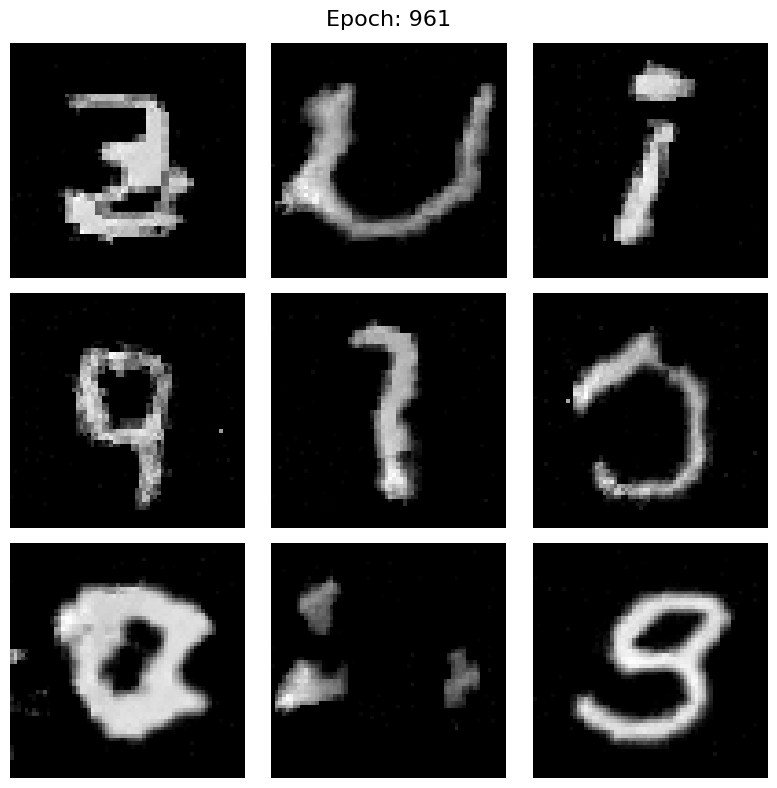

Epoch: 962/1000, d_loss: -1.2447, g_loss: 0.6244, time: 14.8955 sec


Epoch: 963/1000, d_loss: -1.2428, g_loss: 0.6189, time: 14.8247 sec


Epoch: 964/1000, d_loss: -1.2435, g_loss: 0.6254, time: 14.6602 sec


Epoch: 965/1000, d_loss: -1.2428, g_loss: 0.6186, time: 14.6464 sec


Epoch: 966/1000, d_loss: -1.2454, g_loss: 0.6226, time: 14.6923 sec


Epoch: 967/1000, d_loss: -1.2455, g_loss: 0.6228, time: 14.7973 sec


Epoch: 968/1000, d_loss: -1.2455, g_loss: 0.6211, time: 14.8022 sec


Epoch: 969/1000, d_loss: -1.2435, g_loss: 0.6207, time: 14.7323 sec


Epoch: 970/1000, d_loss: -1.2456, g_loss: 0.6235, time: 14.7554 sec


Epoch: 971/1000, d_loss: -1.2457, g_loss: 0.6194, time: 14.9650 sec


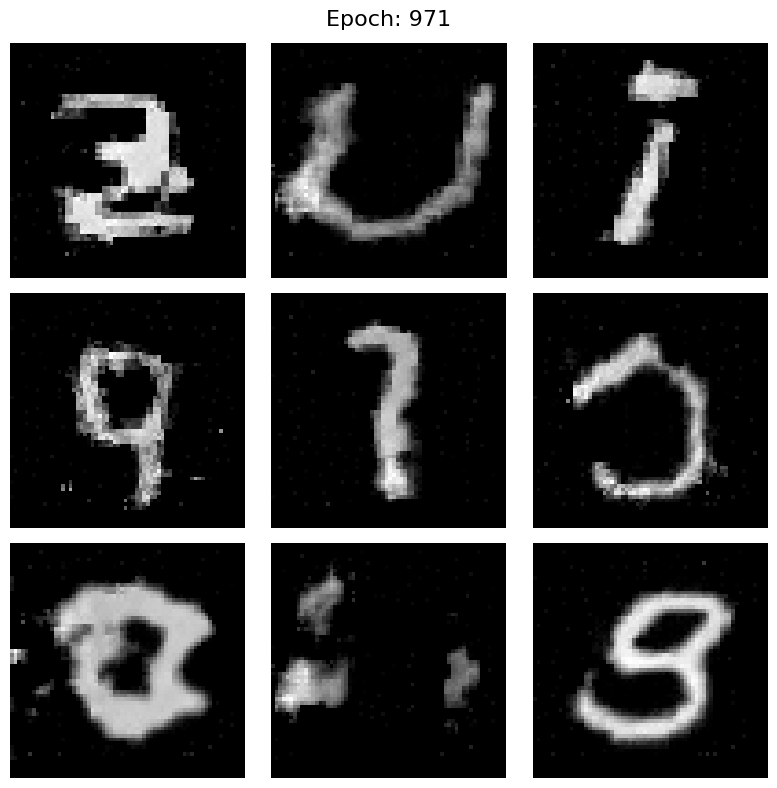

Epoch: 972/1000, d_loss: -1.2465, g_loss: 0.6221, time: 14.7436 sec


Epoch: 973/1000, d_loss: -1.2462, g_loss: 0.6245, time: 14.6251 sec


Epoch: 974/1000, d_loss: -1.2461, g_loss: 0.6193, time: 14.7433 sec


Epoch: 975/1000, d_loss: -1.2464, g_loss: 0.6264, time: 14.7135 sec


Epoch: 976/1000, d_loss: -1.2454, g_loss: 0.6197, time: 14.7958 sec


Epoch: 977/1000, d_loss: -1.2491, g_loss: 0.6240, time: 14.7756 sec


Epoch: 978/1000, d_loss: -1.2486, g_loss: 0.6270, time: 14.6811 sec


Epoch: 979/1000, d_loss: -1.2477, g_loss: 0.6207, time: 14.7145 sec


Epoch: 980/1000, d_loss: -1.2474, g_loss: 0.6250, time: 14.6899 sec


Epoch: 981/1000, d_loss: -1.2480, g_loss: 0.6210, time: 14.7293 sec


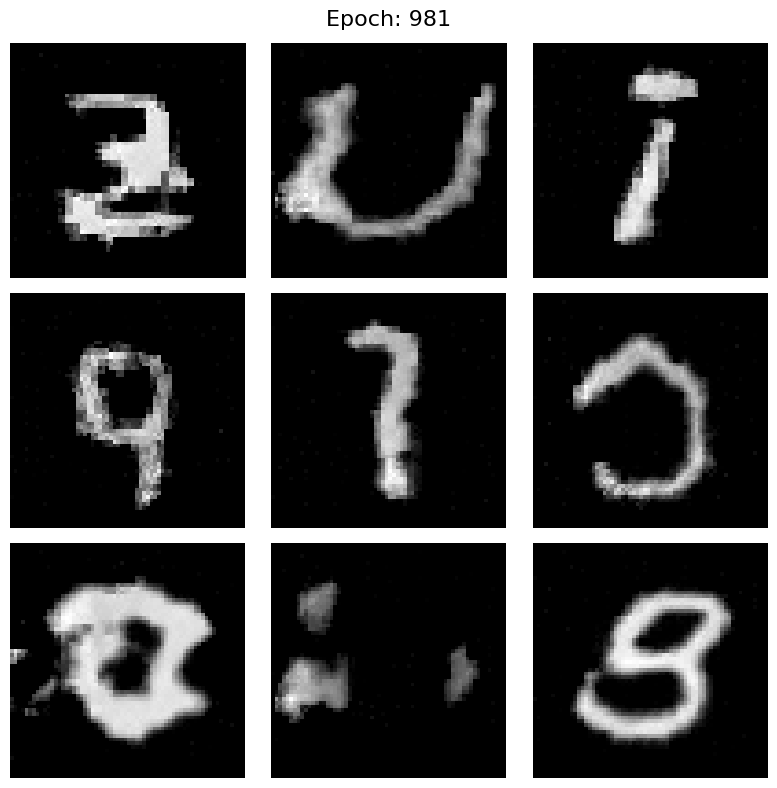

Epoch: 982/1000, d_loss: -1.2485, g_loss: 0.6258, time: 14.8996 sec


Epoch: 983/1000, d_loss: -1.2469, g_loss: 0.6206, time: 14.6516 sec


Epoch: 984/1000, d_loss: -1.2485, g_loss: 0.6249, time: 14.7379 sec


Epoch: 985/1000, d_loss: -1.2486, g_loss: 0.6240, time: 14.8095 sec


Epoch: 986/1000, d_loss: -1.2495, g_loss: 0.6232, time: 14.7204 sec


Epoch: 987/1000, d_loss: -1.2502, g_loss: 0.6251, time: 14.7575 sec


Epoch: 988/1000, d_loss: -1.2488, g_loss: 0.6235, time: 14.7401 sec


Epoch: 989/1000, d_loss: -1.2499, g_loss: 0.6231, time: 14.7045 sec


Epoch: 990/1000, d_loss: -1.2529, g_loss: 0.6223, time: 14.7589 sec


Epoch: 991/1000, d_loss: -1.2510, g_loss: 0.6215, time: 14.7158 sec


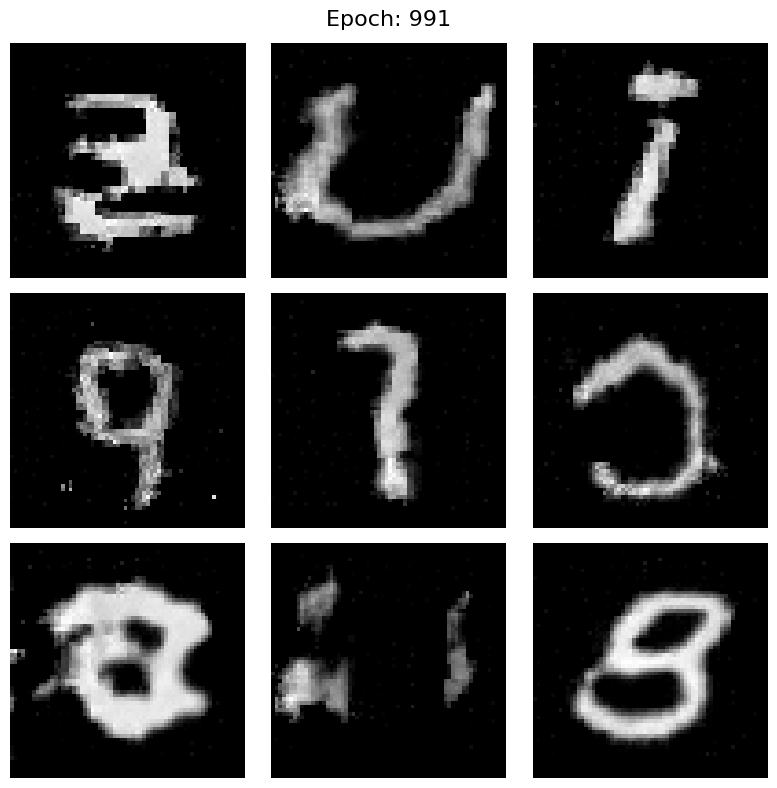

Epoch: 992/1000, d_loss: -1.2522, g_loss: 0.6277, time: 14.7715 sec


Epoch: 993/1000, d_loss: -1.2514, g_loss: 0.6267, time: 14.7333 sec


Epoch: 994/1000, d_loss: -1.2522, g_loss: 0.6229, time: 14.7623 sec


Epoch: 995/1000, d_loss: -1.2523, g_loss: 0.6276, time: 14.7691 sec


Epoch: 996/1000, d_loss: -1.2512, g_loss: 0.6232, time: 14.6611 sec


Epoch: 997/1000, d_loss: -1.2391, g_loss: 0.6160, time: 14.8380 sec


Epoch: 998/1000, d_loss: -1.2182, g_loss: 0.6146, time: 14.6825 sec


Epoch: 999/1000, d_loss: -1.2166, g_loss: 0.6155, time: 14.7028 sec


Epoch: 1000/1000, d_loss: -1.2191, g_loss: 0.6118, time: 14.7346 sec


In [14]:
g_losses = []
d_losses = []
generator = generator.to(device)
discriminator = discriminator.to(device)

print("Start training")
for epoch in range(num_epochs):
    start.record()
    minibatch_d_losses = []
    minibatch_g_losses = []

    generator.train()
    discriminator.train()

    for i, (images, _) in enumerate(train_data_loader):
        mini_batch = images.size()[0]
        images = images.to(device)
        if mini_batch == 1:
            continue

        for _ in range(n_critics):
            # train discriminator
            discriminator.zero_grad()
            with torch.cuda.amp.autocast(dtype=torch.float16):
                z = torch.randn(mini_batch, z_dim, 1, 1, device=device)

                fake_images = generator(z)
                loss_d_real = discriminator(images).mean()
                loss_d_fake = discriminator(fake_images.detach()).mean()
                loss_d = -loss_d_real + loss_d_fake
            scaler.scale(loss_d).backward()
            scaler.step(optimizer_d)
            scaler.update()
            minibatch_d_losses.append(loss_d.item())
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

        # train generator
        generator.zero_grad()
        with torch.cuda.amp.autocast(dtype=torch.float16):
            loss_g = -discriminator(fake_images).mean()
        scaler.scale(loss_g).backward()
        scaler.step(optimizer_g)
        scaler.update()
        minibatch_g_losses.append(loss_g.item())

    end.record()
    torch.cuda.synchronize()
    print(
        f"Epoch: {epoch+1}/{num_epochs}, d_loss: {np.mean(minibatch_d_losses):.4f}, g_loss: {np.mean(minibatch_g_losses):.4f}, time: {start.elapsed_time(end)/1000:.4f} sec"
    )
    g_losses.append(np.mean(minibatch_g_losses))
    d_losses.append(np.mean(minibatch_d_losses))

    if epoch % 10 == 0:
        show_generated(
            generator,
            z_dim,
            device,
            title=f"Epoch: {epoch+1}",
            save_path=os.path.join(save_dir, f"dcgan-improved-epoch-{epoch+1}.png"),
        )

In [15]:
# save model
torch.save(generator.state_dict(), os.path.join(save_dir, "dcgan-generator.pth"))
torch.save(
    discriminator.state_dict(), os.path.join(save_dir, "dcgan-discriminator.pth")
)
# save losses
losses = pd.DataFrame({"g_losses": g_losses, "d_losses": d_losses})
losses.to_csv(os.path.join(save_dir, "dcgan-losses.csv"), index=False)

## 学習結果の確認

まず、下の損失のグラフを確認すると、Discriminatorは単調減少、Generatorは単調増加する傾向にあることが概ね確認できる。Discriminatorは過学習してしまっており、そのため、Generatorはどんなに頑張ってもDiscriminatorを騙すことができなかったのだと推察される。

また、生成された画像を確認すると、同じような数字ばかりが生成されてしまっていることが分かる。Generatorの立場からすると、0~9の数字をそれぞれ作成するのと0のみを生成するので、損失関数の結果に変わりはないので、初期パラメータの具合によっては同じ数字ばかり生成するように収束してしまうことになる。これはモード崩壊と呼ばれる。

これらに対する対処方法を`5-dcgan-improved.ipynb`に作成することにする。

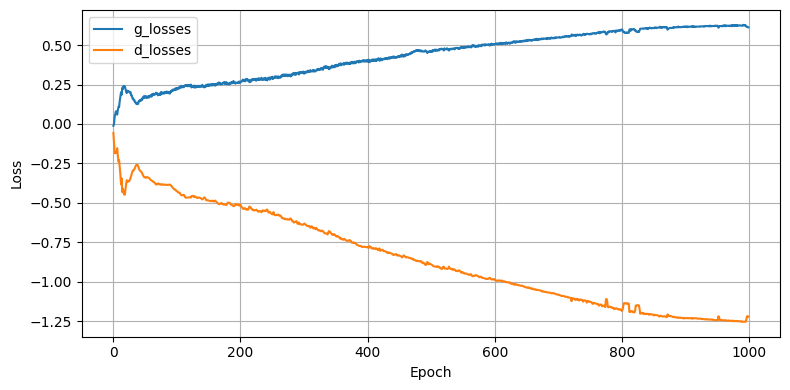

In [16]:
# display losses
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(g_losses, label="g_losses")
ax.plot(d_losses, label="d_losses")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

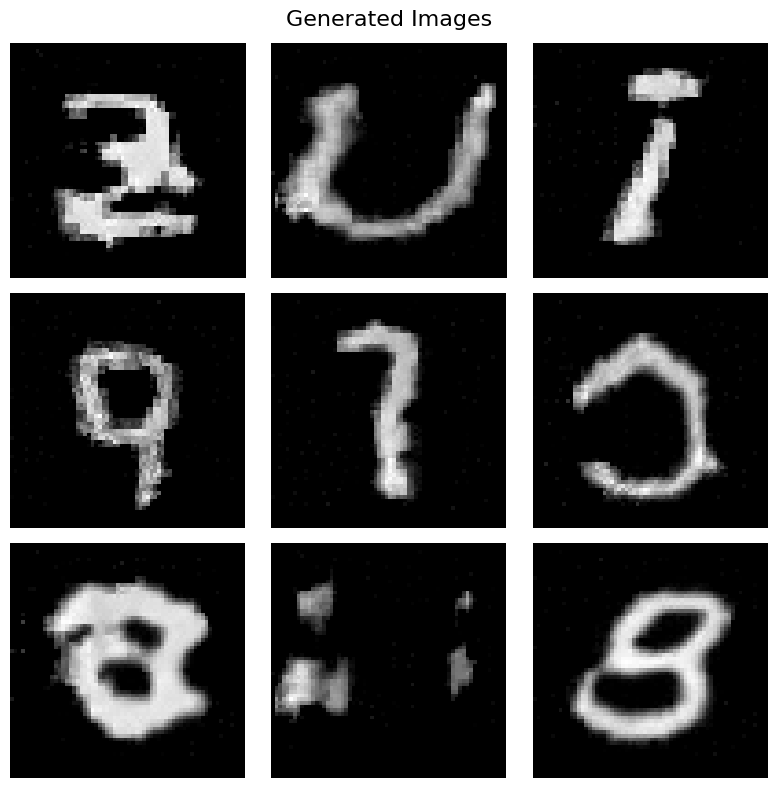

In [17]:
show_generated(generator, z_dim, device)

## 参考文献

- [つくりながら学ぶ！PyTorchによる発展ディープラーニング | 小川 雄太郎 | 工学 | Kindleストア | Amazon](https://www.amazon.co.jp/%E3%81%A4%E3%81%8F%E3%82%8A%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6%EF%BC%81PyTorch%E3%81%AB%E3%82%88%E3%82%8B%E7%99%BA%E5%B1%95%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0-%E5%B0%8F%E5%B7%9D-%E9%9B%84%E5%A4%AA%E9%83%8E-ebook/dp/B07VPDVNKW/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&crid=39VBRPTDUUH0F&keywords=%E4%BD%9C%E3%82%8A%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6+pytorch&qid=1701503265&sprefix=%E4%BD%9C%E3%82%8A%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6+pytorch%2Caps%2C221&sr=8-1)
- [Common Problems  |  Machine Learning  |  Google for Developers](https://developers.google.com/machine-learning/gan/problems)
- [Loss Functions  |  Machine Learning  |  Google for Developers](https://developers.google.com/machine-learning/gan/loss)
- [Lornatang/WassersteinGAN_GP-PyTorch: Improved training of Wasserstein GANs](https://github.com/Lornatang/WassersteinGAN_GP-PyTorch)
- [tiruota/WGAN-PyTorch](https://github.com/tiruota/WGAN-PyTorch)